<a href="https://colab.research.google.com/github/33GuessSo88/MLS_Data_Project/blob/main/Pillar9_Date_Loading_and_Cleaning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# TO DO

1.   Commission needs some work, there are still obvious commission structres in the 'other' category that need to be dealt with.
2.   Coordinate cleaning, unable to clean 6, why?
3. RMS why does it only fix one data point, I thought there were 4. also stops at 97%, why. need to observe more examples of suspicious values.
4. Style analysis needs work, way too much reporting.
5. fix the restart thing when changing runtime.
6. there are 4 rows with no close price. need to address this.
7. why are there so many null commissions?
8. does the style code replace original style text? we should create a new standardized style column

9. review the parking code, still looks verbose. create standardized parking column?
10. after the random forest runs for condo name it shows a bunch of prediction mistakes, but some of them aren't mistakes. The sequential ones? Should I make them all one? Maybe not. There was one condo that the only difference was a THE.
11. Build Date still seems to have odd dates in power bi.




# Data Loading and Combination Script

In [1]:
# =================================================================================
# GOOGLE DRIVE MOUNTING
# =================================================================================
"""
This cell handles mounting your Google Drive to access files.
"""
# It's standard practice to place imports at the top of the script or cell.
from google.colab import drive

def mount_google_drive():
  """Mounts Google Drive, handling authorization and errors."""
  try:
    # The print statement clearly indicates the process is starting.
    print("⏳ Attempting to mount Google Drive...")

    # force_remount=True is useful. It prevents errors if the drive
    # is already mounted, which often happens when re-running cells.
    drive.mount('/content/drive', force_remount=True)

    # If the above line runs without error, the mount was successful.
    print("✅ Google Drive mounted successfully!")
    print("   Your files are available at: /content/drive/My Drive/")

  except Exception as e:
    # If any error occurs during the mount, it's caught here.
    print(f"❌ An error occurred while mounting Google Drive: {e}")
    print("   Please try running the cell again and complete the authorization.")

# --- Execute the mounting function ---
mount_google_drive()

⏳ Attempting to mount Google Drive...
Mounted at /content/drive
✅ Google Drive mounted successfully!
   Your files are available at: /content/drive/My Drive/


In [2]:
# =================================================================================
# CELL 1: ENVIRONMENT & PACKAGE INSTALLATION
# =================================================================================
"""
This cell prepares the Colab environment. It uninstalls potentially
conflicting packages and then force-installs the specific versions
of key libraries required for this notebook.

IMPORTANT: You MUST restart the runtime after running this cell.
"""
import sys

# We use simple print() statements here because the logger
# hasn't been initialized yet. This cell runs *before* the
# main imports.
print("="*80)
print("CELL 1: Starting environment preparation...")
print(f"Using Python version: {sys.version.split()[0]}")

print("\n⏳ Section 1: Uninstalling potentially conflicting packages...")
# Using &> /dev/null silences the (often noisy) uninstall output.
!pip uninstall -y thinc spacy fastai langchain-core tensorflow pandas &> /dev/null
print("✅ Uninstall complete.")

print("\n⏳ Section 2: Installing pinned versions of core libraries...")
# We use --quiet to silence the output, --no-cache-dir to ensure
# we get fresh packages, and --force-reinstall on numpy/pandas
# to override Colab's pre-installed versions.
!pip install --quiet --no-cache-dir \
    "numpy==1.26.4" --force-reinstall \
    "pandas==2.2.2" --force-reinstall \
    "scikit-learn==1.5.0" \
    "matplotlib==3.8.0" \
    "seaborn==0.13.2" \
    "lightgbm==4.3.0" \
    "packaging>=24.2.0" \
    "psutil==5.9.8" \
    "tqdm==4.66.4" \
    "tabulate==0.9.0"
print("✅ Installation complete.")

print("\n" + "="*80)
print("✅ CELL 1 COMPLETE.")
print("‼️ IMPORTANT: Please manually restart the runtime now.")
print("    Click 'Runtime' -> 'Restart runtime' in the menu above.")
print("    After restarting, run the next cell (Cell 2) to import packages")
print("    and initialize the logger.")
print("="*80)

CELL 1: Starting environment preparation...
Using Python version: 3.12.12

⏳ Section 1: Uninstalling potentially conflicting packages...
✅ Uninstall complete.

⏳ Section 2: Installing pinned versions of core libraries...
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.0/61.0 kB 4.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.6/57.6 kB 242.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.0/62.0 kB 178.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 112.3/112.3 kB 51.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.0/18.0 MB 232.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.7/12.7 MB 160.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.1/13.1 MB 212.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.6/11.6 MB 146.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 294.9/294.9 kB 374.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 

Google Drive detected. Logs will be persistent.
=== Starting New Notebook Run (20251111_192800) ===
✅ Logging to: /content/drive/My Drive/colab_logs/notebook_run_20251111_192800.log

SECTION 3: Importing libraries and verifying versions...
✅ All libraries imported and versions verified successfully.

SECTION 5: Configuring notebook and verifying setup...
--- Verifying Final Setup ---


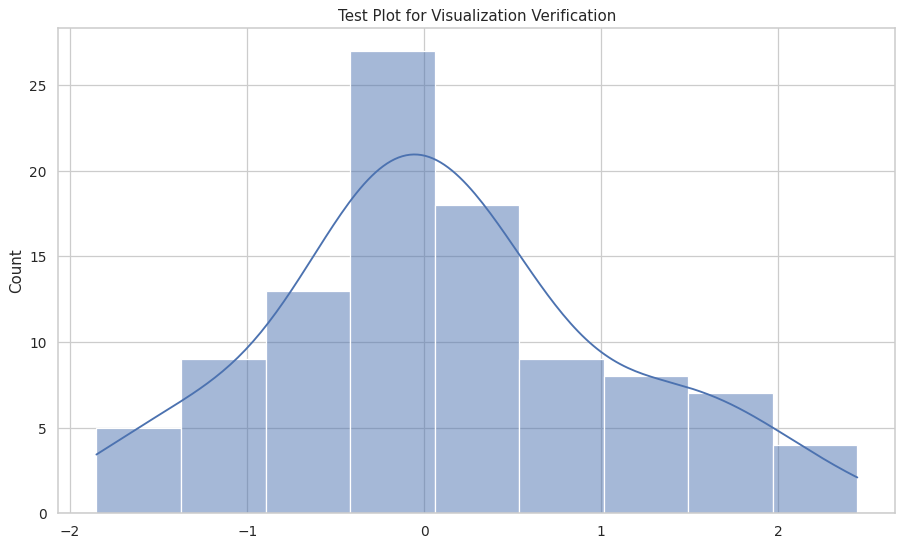

✅ Setup verified (Test plot generated, memory checked).

LOG SUMMARY
   - Run Duration: 0:00:01.309539
   - Full log file at: /content/drive/My Drive/colab_logs/notebook_run_20251111_192800.log

✅ CELL 2 COMPLETE.
✨ All setup steps completed successfully! Ready for data loading.


In [5]:
# =================================================================================
# CELL 2: IMPORTS, VERSION VERIFICATION, AND HELPER FUNCTIONS (After Restart)
# =================================================================================
import os
import sys
import logging
from datetime import datetime
from pathlib import Path
import gc
import psutil

# --- [IMPROVED] NotebookLogger Class ---
class NotebookLogger:
    """
    A logger class that automatically saves logs to Google Drive if mounted,
    otherwise falls back to the local Colab /content/ directory.
    """
    def __init__(self, log_dir: Path):
        self.timestamp = datetime.now().strftime('%Y%m%d_%H%M%S')
        self.log_file = log_dir / f'notebook_run_{self.timestamp}.log'
        self.start_time = datetime.now()

        # Ensure the log directory exists
        self.log_file.parent.mkdir(parents=True, exist_ok=True)

        logging.basicConfig(
            filename=self.log_file,
            level=logging.INFO,
            format='%(asctime)s - %(levelname)s - %(message)s',
            force=True
        )
        self._logger = logging.getLogger(self.__class__.__name__)
        self._logger.info(f"=== Starting New Notebook Run ({self.timestamp}) ===")
        self._logger.info(f"Logging to: {self.log_file.resolve()}")
        print(f"=== Starting New Notebook Run ({self.timestamp}) ===")
        print(f"✅ Logging to: {self.log_file.resolve()}")

    def log_info(self, message, also_print=False):
        self._logger.info(message)
        if also_print:
            print(message)

    def log_error(self, message, also_print=True):
        self._logger.error(message, exc_info=True)
        if also_print:
            print(f"❌ ERROR: {message}")

    def log_warning(self, message, also_print=True):
        self._logger.warning(message)
        if also_print:
            print(f"⚠️ WARNING: {message}")

    def display_log_summary(self):
        duration = datetime.now() - self.start_time
        print("\n" + "="*80)
        print("LOG SUMMARY")
        print(f"   - Run Duration: {duration}")
        print(f"   - Full log file at: {self.log_file.resolve()}")
        print("="*80)

# --- Logic to determine persistent log directory ---
# Check if Google Drive is mounted (which persists across kernel restarts)
drive_path = Path("/content/drive/My Drive")
if drive_path.exists():
    # If Drive is present, log to a persistent folder
    default_log_dir = drive_path / "colab_logs"
    print("Google Drive detected. Logs will be persistent.")
else:
    # Otherwise, fall back to a temporary local folder
    default_log_dir = Path("/content/colab_logs")
    print("⚠️ Google Drive not found. Logs will be temporary (in /content/).")

logger = NotebookLogger(log_dir=default_log_dir)
logger.log_info("Logger initialized successfully (after restart).")


# SECTION 3: IMPORTS AND VERSION VERIFICATION
# =================================================================================
print("\nSECTION 3: Importing libraries and verifying versions...")
try:
    # Core libraries
    import numpy as np
    import pandas as pd
    from collections import defaultdict
    import time
    import tabulate # <-- [FIXED] Import the main package

    # Visualization libraries
    import matplotlib
    import matplotlib.pyplot as plt
    import seaborn as sns

    # Utilities
    import tqdm
    from tqdm.notebook import tqdm as tqdm_notebook
    from IPython.display import display

    # --- Centralized Version Check (Unchanged, this is excellent) ---
    expected_versions = {
        "numpy": "1.26.4",
        "pandas": "2.2.2",
        "scikit-learn": "1.5.0",
        "matplotlib": "3.8.0",
        "seaborn": "0.13.2",
        "lightgbm": "4.3.0",
        "psutil": "5.9.8",
        "tqdm": "4.66.4",
        "tabulate": "0.9.0",
    }
    actual_versions = {
        "python": sys.version.split()[0],
        "numpy": np.__version__,
        "pandas": pd.__version__,
        "scikit-learn": __import__('sklearn').__version__,
        "matplotlib": matplotlib.__version__,
        "seaborn": sns.__version__,
        "lightgbm": __import__('lightgbm').__version__,
        "psutil": psutil.__version__,
        "tqdm": tqdm.__version__,
        "tabulate": tabulate.__version__, # <-- This will now work correctly
    }

    # Verify all expected versions
    all_versions_correct = True
    for lib, expected_ver in expected_versions.items():
        actual_ver = actual_versions.get(lib)
        if actual_ver != expected_ver:
            error_msg = f"CRITICAL: Incorrect {lib} version! Expected {expected_ver}, got {actual_ver}"
            logger.log_error(error_msg, also_print=True)
            all_versions_correct = False

    # <-- [FIXED] Call the function using 'tabulate.tabulate'
    version_table = tabulate.tabulate(actual_versions.items(), headers=["Library", "Version"], tablefmt="grid")
    logger.log_info("Library Version Verification:\n" + version_table)

    if not all_versions_correct:
        raise AssertionError("Stopping: One or more critical libraries have incorrect versions.")

    print("✅ All libraries imported and versions verified successfully.")

except (ImportError, AssertionError) as e:
    logger.log_error(f"Failed during library import or version check: {e}", also_print=True)
    # This raise will stop the notebook, which is correct
    raise SystemExit("Stopping: Critical library setup failed.")


# SECTION 4: HELPER FUNCTIONS (Unchanged, these are excellent)
# =================================================================================
def configure_display_settings():
    """Configure pandas and visualization settings."""
    try:
        pd.set_option('display.max_columns', None)
        pd.set_option('display.max_rows', 100)
        pd.set_option('display.width', 1000)
        pd.set_option('display.float_format', '{:.3f}'.format)
        sns.set_theme(style="whitegrid")
        if 'matplotlib' in sys.modules:
            plt.rcParams.update({'figure.figsize': [12, 7], 'font.size': 12, 'figure.dpi': 90})
        logger.log_info("Display settings configured.")
    except Exception as e:
        logger.log_error(f"Error configuring display settings: {e}")
        raise

def check_memory_usage(warning_threshold_mb=2000):
    """Monitor and log notebook memory usage (RSS)."""
    try:
        gc.collect()
        process = psutil.Process(os.getpid())
        memory_usage_mb = process.memory_info().rss / (1024 * 1024)
        logger.log_info(f"Current memory usage (RSS): {memory_usage_mb:.2f} MB")
        if memory_usage_mb > warning_threshold_mb:
            logger.log_error(f"Memory usage ({memory_usage_mb:.2f} MB) exceeds threshold ({warning_threshold_mb} MB)")
        return memory_usage_mb
    except Exception as e:
        logger.log_error(f"Error checking memory usage: {e}")
        return None

def verify_final_setup():
    """Visually verify the setup with a test plot and memory check."""
    logger.log_info("--- Verifying Final Setup ---", also_print=True)
    try:
        plt.figure()
        sns.histplot(np.random.randn(100), kde=True)
        plt.title("Test Plot for Visualization Verification")
        plt.show()
        logger.log_info("Test plot generated successfully.")

        check_memory_usage()
        logger.log_info("Setup verification complete.")
        print("✅ Setup verified (Test plot generated, memory checked).")
    except Exception as e:
        logger.log_error(f"Error during final setup verification: {e}")
        raise

# SECTION 5: EXECUTION (Unchanged)
# =================================================================================
print("\nSECTION 5: Configuring notebook and verifying setup...")
configure_display_settings()
verify_final_setup()
logger.display_log_summary()

print("\n" + "="*80)
print("✅ CELL 2 COMPLETE.")
print("✨ All setup steps completed successfully! Ready for data loading.")
print("="*80) # <-- [FIXED]

In [6]:
!pip freeze > requirements.txt

In [8]:
# =================================================================================
# CELL 3: CSV FILE MERGING AND CLEANING (Corrected)
# =================================================================================
"""
This cell defines the core data loading and cleaning pipeline.
It finds all CSVs in a specified folder, loads them individually,
cleans column names, applies robust type and value cleaning
(handling nulls, special characters, and dtypes), and then
merges them into a single, unified DataFrame.
"""

# --- Re-importing for cell modularity ---
import pandas as pd
from pathlib import Path
from tqdm.notebook import tqdm
import tabulate
import gc
from datetime import datetime
import re
import traceback
import numpy as np

def _clean_column_names_for_loading(df: pd.DataFrame) -> pd.DataFrame:
    """A non-verbose helper to standardize column names on load."""
    cols = df.columns
    new_cols = [re.sub(r'[^a-zA-Z0-9_]+', '_', col).strip('_') for col in cols]
    df.columns = new_cols

    rename_dict = {
        'MLS': 'MLS_Num', 'LINC': 'LINC_Num', 'DOM': 'Days_On_Market',
        'CDOM': 'Cumulative_Days_On_Market', 'Bedrms_Above_Grade': 'Bedrooms_Above_Grade',
        'BG_Fin_Area': 'Below_Grade_Finished_Area', 'Num_Garage_Sp': 'Num_Garage_Spaces'
    }

    df = df.rename(columns=rename_dict, errors='ignore')
    return df

def merge_and_clean_files_final(folder_path: Path) -> pd.DataFrame:
    """
    Loads, renames, merges, and cleans all CSV files from a folder,
    handling common data quality issues and enforcing a schema.
    """
    logger.log_info("Starting Hardened data merging process...", also_print=True)

    schema = {
        'RMS_Total': 'float64', 'Close_Price': 'float64', 'Days_On_Market': 'float64',
        'Cumulative_Days_On_Market': 'float64', 'Total_Baths': 'float64', 'Num_Garage_Spaces': 'float64',
        'Close_Date': 'datetime64[ns]', 'List_Date': 'datetime64[ns]',
        'MLS_Num': 'str', 'Subdivision_Name': 'str', 'Property_Sub_Type': 'str', 'LINC_Num': 'str'
    }

    null_placeholders = ['nan', 'None', 'none', 'N/A', 'NA', 'n/a', '-']

    try:
        csv_files = list(folder_path.glob('*.csv'))
        if not csv_files:
            logger.log_error("No CSV files found in directory.", also_print=True)
            raise ValueError(f"No CSV files found in {folder_path}")
    except Exception as e:
        logger.log_error(f"Error listing CSV files: {e}", also_print=True)
        raise

    print(f"--> Found {len(csv_files)} CSV files. Starting processing...")

    all_dataframes = []
    for file_path in tqdm(csv_files, desc="Reading and Cleaning CSVs"):
        try:
            df = pd.read_csv(file_path, low_memory=False, skipinitialspace=True)
            df = _clean_column_names_for_loading(df)

            for col in df.select_dtypes(include=['object']).columns:
                df[col] = df[col].str.strip()
                if col in ['Subdivision_Name', 'Property_Sub_Type', 'Status']:
                    df[col] = df[col].str.lower()

            for col, dtype in schema.items():
                if col in df.columns:
                    # First, standardize all common null placeholders to np.nan
                    df[col] = df[col].replace(null_placeholders, np.nan)

                    # === [THE FIX] ===
                    # Apply type-specific conversions

                    if dtype in ['float64', 'int64']:
                        # 1. Convert to string (to safely use .str)
                        # 2. Clean the string
                        # 3. Convert to numeric

                        # .astype(str) handles all input types (int, float, object)
                        cleaned_series = df[col].astype(str).str.replace(r'[,\$]', '', regex=True)

                        # pd.to_numeric will correctly interpret 'nan' strings as np.nan
                        df[col] = pd.to_numeric(cleaned_series, errors='coerce')

                    elif dtype == 'datetime64[ns]':
                        # This conversion is already safe
                        df[col] = pd.to_datetime(df[col], errors='coerce')

                    elif dtype == 'str':
                        # 1. Convert to string (to safely use .str)
                        # 2. Clean the string
                        # 3. Re-replace 'nan' string (from astype) back to np.nan

                        # .astype(str) handles all input types
                        cleaned_str = df[col].astype(str).str.replace(r'\.0$', '', regex=True)

                        # After .astype(str), real nulls are now the string 'nan'. Fix this.
                        df[col] = cleaned_str.replace('nan', np.nan)

            df['source_file'] = file_path.name
            all_dataframes.append(df)

        except Exception as e:
            # Log the error and the file, but continue processing
            logger.log_error(f"Failed to process file {file_path.name}: {e}", also_print=True)
            # Log the full traceback for this specific file to the log
            logger.log_info(f"Traceback for {file_path.name}:\n{traceback.format_exc()}")

    if not all_dataframes:
        logger.log_error("No CSV files were successfully processed.", also_print=True)
        raise ValueError("No CSV files were successfully processed.")

    print("\n--> Merging all processed files...")
    combined_df = pd.concat(all_dataframes, ignore_index=True, sort=False)
    logger.log_info(f"Concatenation complete. Total rows pre-deduplication: {len(combined_df)}")

    print("\n--> Verifying final data types against schema...")
    verification_report = []
    for col, expected_dtype in schema.items():
        if col in combined_df.columns:
            actual_dtype = combined_df[col].dtype
            is_ok = str(actual_dtype) == expected_dtype or (expected_dtype == 'str' and str(actual_dtype) == 'object')
            status = "✅ OK" if is_ok else "⚠️ MISMATCH"
            verification_report.append([col, expected_dtype, str(actual_dtype), status])

    print(tabulate.tabulate(verification_report, headers=["Column", "Expected Type", "Actual Type", "Status"], tablefmt="grid"))

    print("\n✅ Hardened merging process complete!")
    return combined_df

# =================================================================================
# EXECUTION BLOCK
# =================================================================================
try:
    logger.log_info("--- Starting CELL 3: Data Loading ---", also_print=True)

    folder_path = Path('/content/drive/My Drive/Realtor/Data Project/Pillar9_RawCSV_Files')

    combined_data = merge_and_clean_files_final(folder_path)

    print(f"\n✅ Successfully loaded and cleaned {len(combined_data):,} records.")
    check_memory_usage()

except Exception as e:
    logger.log_error(f"PROCESS HALTED during data loading: {e}", also_print=True)
    logger.log_info(f"Traceback:\n{traceback.format_exc()}")
finally:
    logger.display_log_summary()

print("\n" + "="*80)
print("✅ CELL 3 COMPLETE.")
print("="*80)

--- Starting CELL 3: Data Loading ---
Starting Hardened data merging process...
--> Found 90 CSV files. Starting processing...


Reading and Cleaning CSVs:   0%|          | 0/90 [00:00<?, ?it/s]


--> Merging all processed files...

--> Verifying final data types against schema...
+---------------------------+-----------------+----------------+-------------+
| Column                    | Expected Type   | Actual Type    | Status      |
+===========================+=================+================+=============+
| RMS_Total                 | float64         | float64        | ✅ OK       |
+---------------------------+-----------------+----------------+-------------+
| Close_Price               | float64         | float64        | ✅ OK       |
+---------------------------+-----------------+----------------+-------------+
| Days_On_Market            | float64         | int64          | ⚠️ MISMATCH |
+---------------------------+-----------------+----------------+-------------+
| Cumulative_Days_On_Market | float64         | float64        | ✅ OK       |
+---------------------------+-----------------+----------------+-------------+
| Total_Baths               | float64         | 

In [9]:
# =================================================================================
# CELL 4: DUPLICATE ANALYSIS AND REMOVAL
# =================================================================================
"""
This cell analyzes and removes duplicate records based on a unique ID
(MLS_Num), intelligently keeping the most recent record based on a
date column (Close_Date).
"""

# --- Re-importing for cell modularity ---
import pandas as pd
import tabulate  # <-- [FIX] Standardized import to match Cell 2
from datetime import datetime
import re
import traceback
import numpy as np

def analyze_duplicates(df: pd.DataFrame, id_column: str, date_column: str, verbose: bool = True) -> tuple[pd.DataFrame, dict]:
    """
    Analyzes and removes duplicates, keeping the most recent record based on a date column.

    Logs detailed analysis to a file and prints a high-level summary if verbose.
    """
    logger.log_info("Starting Duplicate Analysis and Removal...", also_print=True)

    # --- 1. Input Validation ---
    if not isinstance(df, pd.DataFrame):
        raise TypeError("Input must be a pandas DataFrame.")
    for col in [id_column, date_column]:
        if col not in df.columns:
            raise ValueError(f"Required column missing from DataFrame: '{col}'")

    # [BEST PRACTICE] This copy prevents SettingWithCopyWarning
    # and side effects.
    df = df.copy()

    # Ensure date column is datetime, converting if necessary
    if not pd.api.types.is_datetime64_any_dtype(df[date_column]):
        logger.log_info(f"Converting '{date_column}' to datetime for sorting...", also_print=verbose)
        df[date_column] = pd.to_datetime(df[date_column], errors='coerce')

        if df[date_column].isnull().any():
            # This is a critical warning
            logger.log_error(f"WARNING: Found null dates in '{date_column}' after conversion. These rows may be dropped from de-duplication.", also_print=True)

    # --- 2. Initial Analysis ---
    total_rows = len(df)
    duplicates_mask = df.duplicated(subset=[id_column], keep=False)
    total_duplicate_rows = duplicates_mask.sum()
    unique_ids_with_dupes = df.loc[duplicates_mask, id_column].nunique()

    initial_report = (
        f"\n--- Initial Duplicate Analysis (based on '{id_column}') ---\n"
        f"  - Total Rows Before: {total_rows:,}\n"
        f"  - Total Rows Involved in Duplication: {total_duplicate_rows:,}\n"
        f"  - Unique IDs with duplicates: {unique_ids_with_dupes:,}"
    )
    logger.log_info(initial_report, also_print=verbose)

    # --- 3. Detailed Analysis (Logged to File, warnings printed) ---
    if total_duplicate_rows > 0:
        dupe_df = df[duplicates_mask].sort_values([id_column, date_column])

        # Log top 5 most frequent duplicates to file only
        id_counts = dupe_df[id_column].value_counts()
        logger.log_info(f"Top 5 most duplicated IDs:\n{id_counts.head().to_string()}")

        # [EXCELLENT CHECK] Log check for price discrepancies
        if 'Close_Price' in df.columns:
            discrepancies = dupe_df.groupby(id_column).filter(lambda x: x['Close_Price'].nunique() > 1)
            if not discrepancies.empty:
                logger.log_error(f"WARNING: Found {discrepancies[id_column].nunique():,} IDs with differing 'Close_Price' values. Review needed.", also_print=True)
        else:
            logger.log_info(" 'Close_Price' column not found, skipping price discrepancy check.")

    # --- 4. Removal Process ---
    # Sort by date (ascending), so 'last' is the most recent.
    # na_position='first' ensures NaT/null dates are dropped.
    df_sorted = df.sort_values(by=date_column, ascending=True, na_position='first')
    df_clean = df_sorted.drop_duplicates(subset=[id_column], keep='last')

    rows_removed = total_rows - len(df_clean)

    # --- 5. Final Report and Return ---
    summary_stats = {
        'total_rows_before': total_rows,
        'duplicates_removed': rows_removed,
        'total_rows_after': len(df_clean),
        'unique_ids_with_dupes': unique_ids_with_dupes,
        'total_duplicate_rows': total_duplicate_rows
    }

    # Final verification should show 0 duplicates. This is CRITICAL.
    if df_clean.duplicated(subset=[id_column]).sum() != 0:
        logger.log_error("CRITICAL: Duplicate IDs remain after removal process! Investigate logic.", also_print=True)
    else:
        logger.log_info("Verification: No duplicate IDs found after removal.", also_print=verbose)

    return df_clean, summary_stats

# =================================================================================
# EXECUTION BLOCK
# =================================================================================
try:
    logger.log_info("--- Starting CELL 4: Duplicate Analysis ---", also_print=True)

    if 'combined_data' not in locals() or not isinstance(combined_data, pd.DataFrame) or combined_data.empty:
        raise NameError("Variable 'combined_data' not found, is not a DataFrame, or is empty. Please run previous cells.")

    print("\n" + "="*60)
    print("🚀 Running Duplicate Analysis and Removal Process")

    # Call the function and get the cleaned data and stats
    combined_data, dupe_stats = analyze_duplicates(
        df=combined_data,
        id_column='MLS_Num',
        date_column='Close_Date',
        verbose=True
    )

    # Present the final summary in a clean table
    summary_table = [
        ["Initial Rows", f"{dupe_stats['total_rows_before']:,}"],
        ["Rows Involved in Duplication", f"{dupe_stats['total_duplicate_rows']:,}"],
        ["Rows Removed", f"{dupe_stats['duplicates_removed']:,}"],
        ["Final Rows", f"{dupe_stats['total_rows_after']:,}"]
    ]

    # <-- [FIX] Using tabulate.tabulate() for consistency
    report = tabulate.tabulate(summary_table, headers=["Metric", "Value"], tablefmt="grid")

    print(f"\n--- Duplicate Removal Summary ---\n{report}")
    print("\n✅ Duplicate removal process completed successfully!")

    # Log memory usage after this operation
    check_memory_usage()

except (NameError, ValueError, TypeError) as e:
    logger.log_error(f"PROCESS HALTED: A configuration or data error occurred: {e}", also_print=True)
except Exception as e:
    logger.log_error(f"An unexpected error occurred during duplicate analysis: {e}", also_print=True)
    logger.log_info(f"Traceback:\n{traceback.format_exc()}")
finally:
    logger.display_log_summary()

print("\n" + "="*80)
print("✅ CELL 4 COMPLETE.")
print("="*80)

--- Starting CELL 4: Duplicate Analysis ---

🚀 Running Duplicate Analysis and Removal Process
Starting Duplicate Analysis and Removal...

--- Initial Duplicate Analysis (based on 'MLS_Num') ---
  - Total Rows Before: 428,260
  - Total Rows Involved in Duplication: 20,013
  - Unique IDs with duplicates: 10,006
❌ ERROR: WARNING: Found 14 IDs with differing 'Close_Price' values. Review needed.
Verification: No duplicate IDs found after removal.

--- Duplicate Removal Summary ---
+------------------------------+---------+
| Metric                       | Value   |
+==============================+=========+
| Initial Rows                 | 428,260 |
+------------------------------+---------+
| Rows Involved in Duplication | 20,013  |
+------------------------------+---------+
| Rows Removed                 | 10,007  |
+------------------------------+---------+
| Final Rows                   | 418,253 |
+------------------------------+---------+

✅ Duplicate removal process completed success

# Data Analysis: Temporal Coverage and Quality Assessment

## Overview
This code block examines the quality and completeness of dates in our real estate dataset. It identifies gaps in our temporal data, analyzes listing patterns over time, and provides detailed statistics about our date coverage. This analysis is crucial for understanding any potential data collection issues or seasonal patterns in our MLS listings.

## Technical Details

### Input
* DataFrame: Cleaned dataset with transaction dates
* Primary Date Column: 'Close_Date'
* Date Format: Handles multiple input formats automatically

### Key Analysis Components
1. Date Validation and Cleaning
   * Checks for invalid date formats
   * Converts strings to datetime objects
   * Reports problematic date entries
   * Creates backup of original dates

2. Coverage Analysis
   * Calculates total date range
   * Identifies missing dates
   * Groups consecutive missing dates into ranges
   * Analyzes patterns in missing data

3. Temporal Distribution Analysis
   * Monthly listing counts
   * Year-over-year comparisons
   * Growth rate calculations
   * Seasonal pattern identification

### Quality Metrics Reported
* Total date range covered
* Number of unique dates
* Average listings per date
* Invalid date entries
* Gaps in coverage
* Longest periods without data

## Process Output
The analysis provides:
* Date range summary
* Missing date patterns
* Monthly distribution tables
* Year-over-year growth rates
* Optional CSV export of missing dates
* Comprehensive error logging

## Error Protection
* Creates date column backup
* Validates date formats
* Restores original data if errors occur
* Provides detailed error messages

--- Starting CELL 5: Date Coverage Analysis ---

🚀 Running Comprehensive Date Coverage Analysis
DataFrame shape at start: (418253, 41)
Starting date coverage analysis for column 'Close_Date'...

--> Generating visualizations...


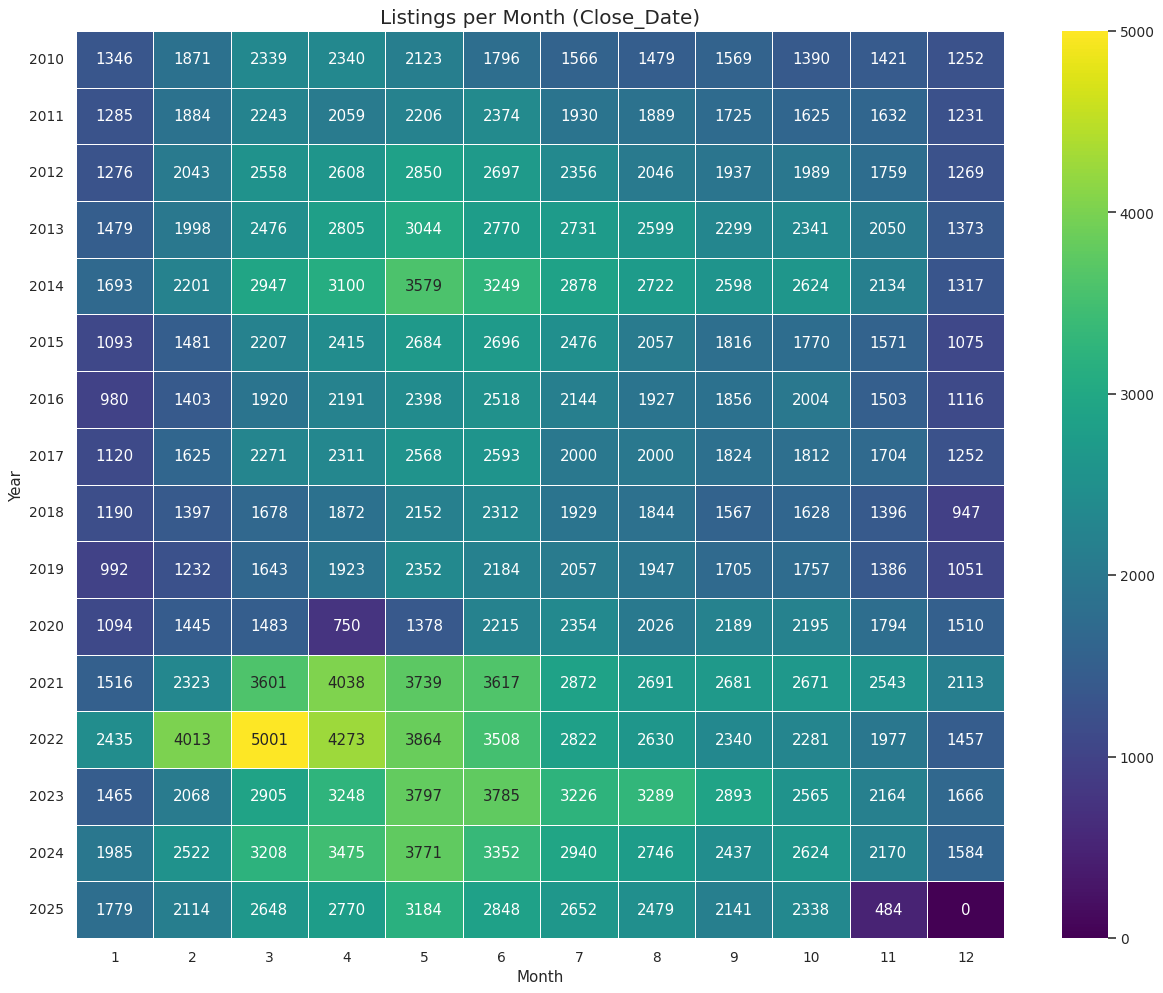

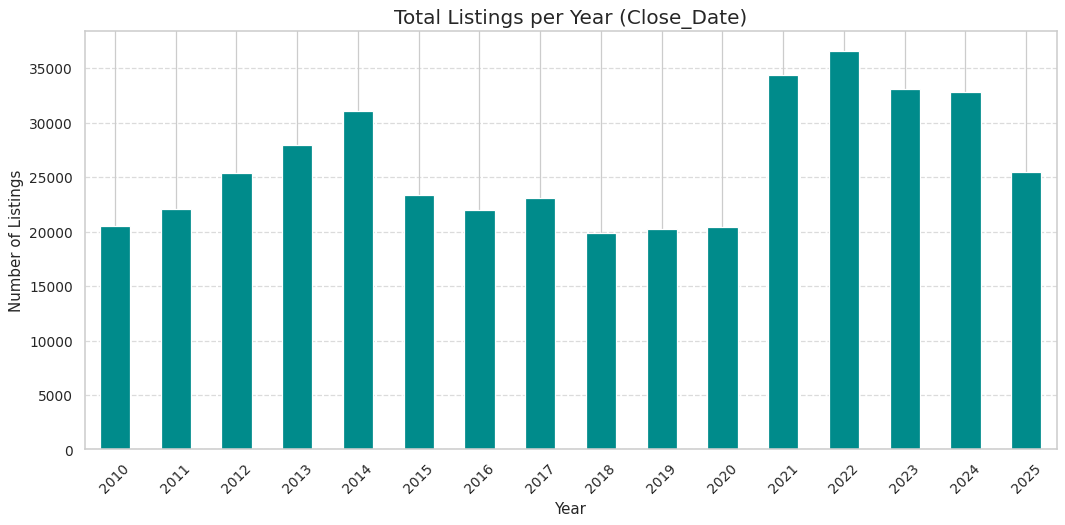


--- Date Coverage Summary for 'Close_Date' ---
+-----------------------------+--------------------------+
| Metric                      | Value                    |
+=============================+==========================+
| Date Range                  | 2010-01-01 to 2025-11-07 |
+-----------------------------+--------------------------+
| Total Days in Range         | 5,790                    |
+-----------------------------+--------------------------+
| Days with Data              | 5,790                    |
+-----------------------------+--------------------------+
| Days Missing Data           | 0                        |
+-----------------------------+--------------------------+
| Valid Date Entries          | 418,253                  |
+-----------------------------+--------------------------+
| Invalid/Unparseable Entries | 0                        |
+-----------------------------+--------------------------+

✅ Date analysis completed successfully!

LOG SUMMARY
   - Run Dura

In [10]:
# =================================================================================
# CELL 5: DATE COVERAGE ANALYSIS
# =================================================================================
"""
This cell performs a detailed analysis of the date coverage for a
specified column (e.g., 'Close_Date'). It identifies the total range,
finds missing dates and consecutive gaps, and generates visualizations
of the data distribution over time.
"""

# --- Re-importing for cell modularity and safety ---
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tabulate  # <-- [FIX] Standardized import for consistency
from pathlib import Path
from datetime import timedelta
import traceback
import numpy as np

def analyze_date_coverage(df: pd.DataFrame, date_column: str, create_plots: bool = True, save_path: str = None) -> dict:
    """
    Analyzes date coverage, identifies gaps, and optionally creates visualizations.
    """
    logger.log_info(f"Starting date coverage analysis for column '{date_column}'...", also_print=True)

    # --- 1. Validate and Prepare Date Column ---
    if date_column not in df.columns:
        raise ValueError(f"Column '{date_column}' not found in DataFrame.")

    dates_converted = pd.to_datetime(df[date_column], errors='coerce')
    valid_dates = dates_converted.dropna()

    if valid_dates.empty:
        logger.log_error("No valid dates found after parsing! Cannot perform analysis.", also_print=True)
        return None

    # --- 2. Date Range and Gap Analysis ---
    earliest_date, latest_date = valid_dates.min(), valid_dates.max()
    full_date_range = pd.to_datetime(pd.date_range(start=earliest_date, end=latest_date, freq='D'))

    # [PERFORMANCE FIX] This is much more efficient than converting a large
    # Series to a set.
    # 1. Get all unique days (normalized to remove time)
    unique_observed_days = pd.Series(valid_dates.dt.normalize().unique())
    # 2. Find all dates in the full range that are NOT in our observed list
    missing_dates = full_date_range[~full_date_range.isin(unique_observed_days)]
    missing_dates = sorted(list(missing_dates)) # Match original output type

    # --- 3. High-Level Summary ---
    summary = {
        'earliest_date': earliest_date.strftime('%Y-%m-%d'),
        'latest_date': latest_date.strftime('%Y-%m-%d'),
        'total_days_in_range': (latest_date - earliest_date).days + 1,
        'unique_dates_found': len(unique_observed_days), # Use the optimized variable
        'missing_dates_count': len(missing_dates),
        'valid_entries': len(valid_dates),
        'invalid_entries': dates_converted.isnull().sum()
    }
    logger.log_info(f"Detailed date analysis summary:\n{pd.Series(summary).to_string()}")

    # --- 4. Detailed Gap Analysis (Unchanged, this is excellent) ---
    if summary['missing_dates_count'] > 0:
        missing_df = pd.DataFrame(missing_dates, columns=['date']).set_index('date')
        missing_df['gap_group'] = (missing_df.index.to_series().diff() != timedelta(days=1)).cumsum()
        gaps = missing_df.groupby('gap_group').agg(['first', 'last', 'size'])
        gaps.columns = gaps.columns.droplevel(0)
        gaps = gaps.rename(columns={'size': 'days_missing'})

        longest_gaps = gaps.sort_values('days_missing', ascending=False).head(5)
        logger.log_info(f"Top 5 longest missing date gaps:\n{longest_gaps.to_string()}")

        if save_path:
            save_path_obj = Path(save_path) # Convert string to Path
            save_path_obj.parent.mkdir(parents=True, exist_ok=True)
            longest_gaps.to_csv(save_path_obj)
            logger.log_info(f"Saved longest gaps report to {save_path_obj}", also_print=True)

    # --- 5. Visualizations (Unchanged, this is excellent) ---
    if create_plots:
        print("\n--> Generating visualizations...")
        # Monthly Listings Heatmap
        try:
            monthly_counts = valid_dates.groupby([valid_dates.dt.year, valid_dates.dt.month]).size().unstack(fill_value=0)
            num_years = len(monthly_counts)
            fig_height = max(6, num_years * 0.7)
            plt.figure(figsize=(14, fig_height))

            sns.heatmap(monthly_counts, cmap="viridis", linewidths=.5, annot=True, fmt="d")
            plt.title(f'Listings per Month ({date_column})', fontsize=16)
            plt.xlabel('Month'), plt.ylabel('Year'), plt.yticks(rotation=0)
            plt.tight_layout(), plt.show()
            logger.log_info("Monthly heatmap generated successfully.")
        except Exception as e:
            logger.log_error(f"Could not generate monthly heatmap: {e}", also_print=True)

        # Yearly Listings Bar Chart
        try:
            plt.figure(figsize=(12, 6))
            valid_dates.dt.year.value_counts().sort_index().plot(kind='bar', color='darkcyan')
            plt.title(f'Total Listings per Year ({date_column})', fontsize=16)
            plt.ylabel('Number of Listings'), plt.xlabel('Year')
            plt.xticks(rotation=45), plt.grid(axis='y', linestyle='--', alpha=0.7)
            plt.tight_layout(), plt.show()
            logger.log_info("Yearly bar chart generated successfully.")
        except Exception as e:
            logger.log_error(f"Could not generate yearly bar chart: {e}", also_print=True)

    return summary

# =================================================================================
# EXECUTION BLOCK
# =================================================================================
try:
    logger.log_info("--- Starting CELL 5: Date Coverage Analysis ---", also_print=True)

    if 'combined_data' not in locals() or not isinstance(combined_data, pd.DataFrame) or combined_data.empty:
        raise NameError("Variable 'combined_data' not found, is not a DataFrame, or is empty. Please run previous cells.")

    # [CLEANUP] Removed duplicate header
    print("\n" + "="*60)
    print("🚀 Running Comprehensive Date Coverage Analysis")
    print(f"DataFrame shape at start: {combined_data.shape}")

    # --- Parameters ---
    target_date_column = 'Close_Date'
    generate_plots = True
    missing_dates_output_path = '/content/drive/My Drive/Realtor/Data Project/longest_date_gaps.csv'

    # --- Execution ---
    analysis_results = analyze_date_coverage(
        df=combined_data,
        date_column=target_date_column,
        create_plots=generate_plots,
        save_path=missing_dates_output_path
    )

    # --- Final Report ---
    if analysis_results:
        summary_table = [
            ["Date Range", f"{analysis_results['earliest_date']} to {analysis_results['latest_date']}"],
            ["Total Days in Range", f"{analysis_results['total_days_in_range']:,}"],
            ["Days with Data", f"{analysis_results['unique_dates_found']:,}"],
            ["Days Missing Data", f"{analysis_results['missing_dates_count']:,}"],
            ["Valid Date Entries", f"{analysis_results['valid_entries']:,}"],
            ["Invalid/Unparseable Entries", f"{analysis_results['invalid_entries']:,}"]
        ]
        # <-- [FIX] Using tabulate.tabulate() for consistency
        report = tabulate.tabulate(summary_table, headers=["Metric", "Value"], tablefmt="grid")
        print(f"\n--- Date Coverage Summary for '{target_date_column}' ---\n{report}")
        print("\n✅ Date analysis completed successfully!")
    else:
        print("\n❌ Date analysis failed to return results. See logs for details.")

    # Log memory usage after this operation
    check_memory_usage()

except (NameError, ValueError) as e:
    logger.log_error(f"PROCESS HALTED: A configuration or data error occurred: {e}", also_print=True)
except Exception as e:
    logger.log_error(f"An unexpected error occurred during date analysis: {e}", also_print=True)
    logger.log_info(f"Traceback:\n{traceback.format_exc()}")
finally:
    # [FIX] Added for consistency with other cells
    logger.display_log_summary()

print("\n" + "="*80)
print("✅ CELL 5 COMPLETE.")
print("="*80)

In [11]:
# =================================================================================
# CELL 6: MANUAL INSPECTION OF EXTREME RMS_TOTAL VALUES
# =================================================================================
"""
This cell provides a read-only, manual inspection of the properties
with the highest and lowest recorded square footage. This helps
to manually identify anomalies and validate the corrections
in the next cell.
"""

# --- Re-importing for cell modularity ---
import pandas as pd
from IPython.display import display
import traceback

try:
    logger.log_info("--- Starting CELL 6: Extreme Value Inspection ---", also_print=True)

    if 'combined_data' not in locals() or not isinstance(combined_data, pd.DataFrame):
        raise NameError("Variable 'combined_data' not found. Please run previous cells.")

    print(f"DataFrame shape at start: {combined_data.shape}")
    print("Inspecting extreme values in 'combined_data'...")

    # [BEST PRACTICE] Create a temporary copy for safe inspection.
    inspection_df = combined_data.copy()

    inspection_df['RMS_Total'] = pd.to_numeric(inspection_df['RMS_Total'], errors='coerce')
    inspection_df['Close_Price'] = pd.to_numeric(inspection_df['Close_Price'], errors='coerce')

    display_cols = ['Subdivision_Name', 'Property_Sub_Type', 'RMS_Total', 'Close_Price']

    # --- Display the 20 LARGEST RMS values ---
    print("\n" + "="*80)
    print("TOP 20 LARGEST RMS_Total VALUES")
    print("="*80)
    largest_rms = inspection_df.sort_values(by='RMS_Total', ascending=False).head(20)
    display(largest_rms[display_cols])

    # --- Display the 20 SMALLEST (but > 0) RMS values ---
    print("\n" + "="*80)
    print("TOP 20 SMALLEST (Positive) RMS_Total VALUES")
    print("="*80)
    # [GOOD LOGIC] Filtering for > 0 avoids zeros or errors.
    smallest_rms = inspection_df[inspection_df['RMS_Total'] > 0].sort_values(by='RMS_Total', ascending=True).head(20)
    display(smallest_rms[display_cols])

except (NameError, Exception) as e:
    logger.log_error(f"Error during value inspection: {e}", also_print=True)
    logger.log_info(f"Traceback:\n{traceback.format_exc()}")
finally:
    # This is a read-only step, so no data changes
    if 'combined_data' in locals() and isinstance(combined_data, pd.DataFrame):
        print(f"\nDataFrame shape at end: {combined_data.shape} (unchanged)")
    check_memory_usage()
    logger.display_log_summary()

print("\n" + "="*80)
print("✅ CELL 6 COMPLETE.")
print("="*80)

--- Starting CELL 6: Extreme Value Inspection ---
DataFrame shape at start: (418253, 41)
Inspecting extreme values in 'combined_data'...

TOP 20 LARGEST RMS_Total VALUES


,Subdivision_Name,Property_Sub_Type,RMS_Total,Close_Price
422081,parkland,detached,176046.000,875000.000
400917,cougar ridge,detached,55680.000,2410000.000
4979,killarney/glengarry,semi detached (half duplex),20910.000,1085000.000
280934,taradale,apartment,19805.000,900000.000
264137,country hills village,row/townhouse,14230.000,312000.000
249005,deer park,detached,13390.000,384500.000
292291,montrose,detached,12719.000,375000.000
2929,glamorgan,row/townhouse,11571.000,325000.000
133726,beddington heights,row/townhouse,11065.000,202000.000
245922,banff trail,detached,10311.000,628000.000



TOP 20 SMALLEST (Positive) RMS_Total VALUES


,Subdivision_Name,Property_Sub_Type,RMS_Total,Close_Price
31707,southwood,semi detached (half duplex),1.000,370000.000
413881,johnstone park,apartment,8.000,205000.000
304842,sunset ridge,row/townhouse,10.000,305000.000
243149,montgomery,detached,10.000,535000.000
8305,riverside meadows,row/townhouse,10.000,153000.000
54092,varsity,row/townhouse,11.000,441179.000
69741,shawnee slopes,apartment,49.000,315000.000
289379,eau claire,apartment,49.000,11500.000
153182,cimarron grove,apartment,79.000,140000.000
205451,southview,detached,86.000,382000.000



DataFrame shape at end: (418253, 41) (unchanged)

LOG SUMMARY
   - Run Duration: 0:22:38.133982
   - Full log file at: /content/drive/My Drive/colab_logs/notebook_run_20251111_192800.log

✅ CELL 6 COMPLETE.


In [12]:
# =================================================================================
# CELL 7: ANOMALY CORRECTION (V16.2 - Exclude High-Price Anomalies)
# =================================================================================
"""
This cell runs the advanced, heuristic-first anomaly correction function.
It identifies and corrects implausible RMS_Total and Close_Price values
based on peer-group medians, while intelligently excluding legitimate
high-price sales from correction.
"""

# --- Re-importing for cell modularity ---
import pandas as pd
import numpy as np
import traceback
import tabulate  # <-- [FIX] Standardized import
from IPython.display import display

def correct_anomalies_with_heuristic(
    df: pd.DataFrame,
    ratio_threshold: float = 4.0,
    min_peer_group_size: int = 5, # Not used in this version, but good parameter to have
    clip_percentiles: tuple[float, float] = (0.05, 0.95)
) -> tuple[pd.DataFrame, pd.DataFrame]:
    """
    Finds and corrects anomalies in RMS_Total and Close_Price using a heuristic-first approach
    with a statistical fallback for maximum accuracy and plausibility. (V16.2)
    """
    logger.log_info("Starting Heuristic-First Anomaly Correction (V16.2)...", also_print=True)

    df_work = df.copy()
    df_work.reset_index(inplace=True, names='original_index')

    # --- 1. Preparation & Benchmark Calculation ---
    df_work['Year'] = pd.to_datetime(df_work['Close_Date'], errors='coerce').dt.year
    df_work['Price_Per_SqFt'] = pd.to_numeric(df_work['Close_Price'], errors='coerce') / pd.to_numeric(df_work['RMS_Total'], errors='coerce')

    group_cols = ['Subdivision_Name', 'Property_Sub_Type', 'Year']
    stats_to_agg = {
        'RMS_Total': ['median',
                      lambda x: x.quantile(clip_percentiles[0]),
                      lambda x: x.quantile(clip_percentiles[1])],
        'Close_Price': ['median',
                        lambda x: x.quantile(clip_percentiles[0]),
                        lambda x: x.quantile(clip_percentiles[1])],
        'Price_Per_SqFt': ['median']
    }

    # [GOOD LOGIC] This correctly calculates stats and flattens the multi-index
    peer_stats = df_work.groupby(group_cols).agg(stats_to_agg)
    peer_stats.columns = ['_'.join(col).strip() for col in peer_stats.columns.values]
    peer_stats = peer_stats.reset_index()

    peer_stats.rename(columns={
        'RMS_Total_<lambda_0>': 'RMS_Total_p05', 'RMS_Total_<lambda_1>': 'RMS_Total_p95',
        'Close_Price_<lambda_0>': 'Close_Price_p05', 'Close_Price_<lambda_1>': 'Close_Price_p95',
        'Price_Per_SqFt_median': 'Price_Per_SqFt_Peer_Median'
    }, inplace=True)

    # [GOOD LOGIC] Re-assignment (no inplace=True)
    peer_stats = peer_stats.rename(columns={
        'RMS_Total_<lambda_0>': 'RMS_Total_p05', 'RMS_Total_<lambda_1>': 'RMS_Total_p95',
        'Close_Price_<lambda_0>': 'Close_Price_p05', 'Close_Price_<lambda_1>': 'Close_Price_p95',
        'Price_Per_SqFt_median': 'Price_Per_SqFt_Peer_Median'
    }, errors='ignore') # Added errors='ignore' for safety

    df_work = pd.merge(df_work, peer_stats, on=group_cols, how='left', suffixes=('', '_Peer'))

    # --- 2. Identify & Diagnose Anomalies ---
    df_work.set_index('original_index', inplace=True, drop=True)
    df_work['PPSF_Ratio'] = df_work['Price_Per_SqFt'] / df_work['Price_Per_SqFt_Peer_Median']

    anomaly_mask_initial = (df_work['PPSF_Ratio'] > ratio_threshold) | (df_work['PPSF_Ratio'] < 1/ratio_threshold)
    valid_peer_data_mask = df_work[['RMS_Total_median', 'Close_Price_median']].notna().all(axis=1)

    anomalies = df_work[valid_peer_data_mask & anomaly_mask_initial].copy()

    if anomalies.empty:
        logger.log_info("No initial anomalies found based on PPSF ratio.", also_print=True)
        return df, pd.DataFrame()

    size_dev = np.abs(anomalies['RMS_Total'] - anomalies['RMS_Total_median']) / anomalies['RMS_Total_median']
    price_dev = np.abs(anomalies['Close_Price'] - anomalies['Close_Price_median']) / anomalies['Close_Price_median']
    anomalies['Diagnosed_Error_In'] = np.where(size_dev > price_dev, 'RMS_Total', 'Close_Price')

    # [EXCELLENT BUSINESS LOGIC] (V16.2)
    is_high_price_anomaly_to_exclude = (anomalies['PPSF_Ratio'] > ratio_threshold) & \
                                     (anomalies['Diagnosed_Error_In'] == 'Close_Price')

    initial_anomalies_count = len(anomalies)
    anomalies = anomalies[~is_high_price_anomaly_to_exclude].copy()

    if initial_anomalies_count > len(anomalies):
        logger.log_info(f"Excluded {initial_anomalies_count - len(anomalies)} high-price anomalies from correction.", also_print=True)

    if anomalies.empty:
        logger.log_info("No anomalies remain after excluding high-price, diagnosed-as-price-error cases.", also_print=True)
        return df, pd.DataFrame()

    logger.log_info(f"Proceeding with correction for {len(anomalies)} eligible anomalies.", also_print=True)

    # --- 3. HYBRID CORRECTION LOGIC ---
    is_too_small_error = anomalies['PPSF_Ratio'] > ratio_threshold
    is_too_large_error = anomalies['PPSF_Ratio'] < 1/ratio_threshold

    anomalies['Heuristic_RMS'] = np.select(
        [is_too_small_error, is_too_large_error],
        [anomalies['RMS_Total'] * 10, anomalies['RMS_Total'] / 10],
        default=anomalies['RMS_Total']
    )
    anomalies['Heuristic_Price'] = np.select(
        [is_too_large_error, is_too_small_error],
        [anomalies['Close_Price'] * 10, anomalies['Close_Price'] / 10],
        default=anomalies['Close_Price']
    )

    anomalies['Is_RMS_Heuristic_Sensible'] = anomalies['Heuristic_RMS'].between(anomalies['RMS_Total_p05'], anomalies['RMS_Total_p95'])
    anomalies['Is_Price_Heuristic_Sensible'] = anomalies['Heuristic_Price'].between(anomalies['Close_Price_p05'], anomalies['Close_Price_p95'])

    imputed_rms = (anomalies['Close_Price'] / anomalies['Price_Per_SqFt_Peer_Median']).clip(anomalies['RMS_Total_p05'], anomalies['RMS_Total_p95'])
    imputed_price = (anomalies['RMS_Total'] * anomalies['Price_Per_SqFt_Peer_Median']).clip(anomalies['Close_Price_p05'], anomalies['Close_Price_p95'])

    rms_is_error = anomalies['Diagnosed_Error_In'] == 'RMS_Total'
    price_is_error = anomalies['Diagnosed_Error_In'] == 'Close_Price'

    anomalies['Corrected_RMS'] = np.select(
        [rms_is_error & anomalies['Is_RMS_Heuristic_Sensible'],
         rms_is_error & ~anomalies['Is_RMS_Heuristic_Sensible']],
        [anomalies['Heuristic_RMS'], imputed_rms],
        default=anomalies['RMS_Total']
    )
    anomalies['Corrected_Price'] = np.select(
        [price_is_error & anomalies['Is_Price_Heuristic_Sensible'],
         price_is_error & ~anomalies['Is_Price_Heuristic_Sensible']],
        [anomalies['Heuristic_Price'], imputed_price],
        default=anomalies['Close_Price']
    )

    anomalies['Correction_Method'] = np.where(
        (rms_is_error & anomalies['Is_RMS_Heuristic_Sensible']) | \
        (price_is_error & anomalies['Is_Price_Heuristic_Sensible']),
        'Heuristic', 'Statistical'
    )

    # --- 4. Apply Fixes and Generate Final Report ---
    # [EXCELLENT METHOD] Applies fixes back to a fresh copy
    corrected_df = df.copy()
    corrected_df.loc[anomalies.index, 'RMS_Total'] = anomalies['Corrected_RMS']
    corrected_df.loc[anomalies.index, 'Close_Price'] = anomalies['Corrected_Price']

    report_df = anomalies.rename(columns={'RMS_Total': 'Original_RMS', 'Close_Price': 'Original_Price', 'Year': 'Sale_Year'})
    final_report_cols = [
        'MLS_Num', 'Subdivision_Name', 'Sale_Year', 'Diagnosed_Error_In',
        'Correction_Method', 'Original_RMS', 'Corrected_RMS', 'Original_Price', 'Corrected_Price'
    ]

    # Ensure all report columns exist before returning
    final_report_cols = [col for col in final_report_cols if col in report_df.columns]
    return corrected_df, report_df[final_report_cols]


# =================================================================================
# EXECUTION BLOCK
# =================================================================================
try:
    logger.log_info("--- Starting CELL 7: Anomaly Correction ---", also_print=True)
    print("\n" + "="*80)
    print("🚀 Running Heuristic-First Anomaly Correction (V16.2)")

    if 'combined_data' not in locals() or not isinstance(combined_data, pd.DataFrame) or combined_data.empty:
        raise NameError("Variable 'combined_data' not found, is not a DataFrame, or is empty. Please run previous cells.")

    print(f"DataFrame shape at start: {combined_data.shape}")

    # [BEST PRACTICE] Pass a copy to the function
    data_to_correct = combined_data.copy()

    corrected_data, final_fixes_report = correct_anomalies_with_heuristic(data_to_correct)

    if not final_fixes_report.empty:
        print(f"\n--- Anomaly Correction Report ({len(final_fixes_report)} records corrected) ---")

        display_headers = ['MLS Num', 'Subdivision', 'Year', 'Diagnosed Error', 'Method',
                           'Orig. RMS', 'Corr. RMS', 'Orig. Price', 'Corr. Price']

        # [FIX] Using tabulate.tabulate() for consistency
        print(tabulate.tabulate(final_fixes_report.head(20), headers=display_headers, tablefmt='grid', floatfmt=",.0f"))

        if len(final_fixes_report) > 20:
            print(f"\n... (showing top 20 of {len(final_fixes_report)} corrected records)")
            print("Full report available in 'final_fixes_report' DataFrame.")

        # --- DETAILED EDGE CASE ANOMALY REPORT ---
        print("\n" + "="*80)
        print("DETAILED ANOMALY REPORT: EXTREME RMS_Total VALUES (Corrected Cases)")
        print("="*80)

        largest_orig_rms_anomalies = final_fixes_report.sort_values(by='Original_RMS', ascending=False).head(10)
        if not largest_orig_rms_anomalies.empty:
            print("\n--- Top 10 Largest Original RMS (from Corrected Anomalies) ---")
            # [FIX] Using tabulate.tabulate()
            print(tabulate.tabulate(largest_orig_rms_anomalies, headers=display_headers, tablefmt='grid', floatfmt=",.0f"))
        else:
            print("No anomalies with large original RMS values were corrected.")

        smallest_orig_rms_anomalies = final_fixes_report[final_fixes_report['Original_RMS'] > 0].sort_values(by='Original_RMS', ascending=True).head(10)
        if not smallest_orig_rms_anomalies.empty:
            print("\n--- Top 10 Smallest Positive Original RMS (from Corrected Anomalies) ---")
            # [FIX] Using tabulate.tabulate()
            print(tabulate.tabulate(smallest_orig_rms_anomalies, headers=display_headers, tablefmt='grid', floatfmt=",.0f"))
        else:
            print("No anomalies with small positive original RMS values were corrected.")

        print("\n" + "="*80)
        print("DETAILED ANOMALY REPORT: EXTREME Close_Price VALUES (Corrected Cases)")
        print("="*80)

        largest_orig_price_anomalies = final_fixes_report.sort_values(by='Original_Price', ascending=False).head(10)
        if not largest_orig_price_anomalies.empty:
            print("\n--- Top 10 Largest Original Price (from Corrected Anomalies) ---")
            # [FIX] Using tabulate.tabulate()
            print(tabulate.tabulate(largest_orig_price_anomalies, headers=display_headers, tablefmt='grid', floatfmt=",.0f"))
        else:
            print("No anomalies with large original price values were corrected.")

        smallest_orig_price_anomalies = final_fixes_report[final_fixes_report['Original_Price'] > 0].sort_values(by='Original_Price', ascending=True).head(10)
        if not smallest_orig_price_anomalies.empty:
            print("\n--- Top 10 Smallest Positive Original Price (from Corrected Anomalies) ---")
            # [FIX] Using tabulate.tabulate()
            print(tabulate.tabulate(smallest_orig_price_anomalies, headers=display_headers, tablefmt='grid', floatfmt=",.0f"))
        else:
            print("No anomalies with small positive original price values were corrected.")

        # [CRITICAL STEP] The main DataFrame is updated with the corrected data
        combined_data = corrected_data
        print(f"\n✅ 'combined_data' has been updated with {len(final_fixes_report)} corrections.")
    else:
        print("\n✅ No significant data entry errors were found (or no sufficient peer data for comparison).")

    print("\n" + "="*80)

except (NameError, ValueError) as e:
    logger.log_error(f"PROCESS HALTED: {e}", also_print=True)
except Exception as e:
    logger.log_error(f"An unexpected error occurred during anomaly correction: {e}", also_print=True)
    logger.log_info(f"Traceback:\n{traceback.format_exc()}")
finally:
    if 'combined_data' in locals() and isinstance(combined_data, pd.DataFrame):
        print(f"DataFrame shape at end: {combined_data.shape}")
    # [FIX] Added for consistency
    check_memory_usage()
    logger.display_log_summary()

print("\n" + "="*80)
print("✅ CELL 7 COMPLETE.")
print("="*80)

--- Starting CELL 7: Anomaly Correction ---

🚀 Running Heuristic-First Anomaly Correction (V16.2)
DataFrame shape at start: (418253, 41)
Starting Heuristic-First Anomaly Correction (V16.2)...
Excluded 35 high-price anomalies from correction.
Proceeding with correction for 267 eligible anomalies.

--- Anomaly Correction Report (267 records corrected) ---
+--------+-----------+---------------+--------+-------------------+-------------+-------------+-------------+---------------+---------------+
|        | MLS Num   | Subdivision   |   Year | Diagnosed Error   | Method      |   Orig. RMS |   Corr. RMS |   Orig. Price |   Corr. Price |
+========+===========+===============+========+===================+=============+=============+=============+===============+===============+
| 353077 | CA297465  | glendale      |   2010 | Close_Price       | Heuristic   |         904 |         904 |        48,000 |       480,000 |
+--------+-----------+---------------+--------+-------------------+---------

In [13]:
# =================================================================================
# CELL 8: SUITE STATUS CLEANING AND STANDARDIZATION
# =================================================================================
"""
This cell analyzes and standardizes the 'Suite' column. It maps
various free-text inputs to three clean categories:
'No Suite', 'Suite - Illegal', and 'Suite - Legal'.
It includes a robust backup-and-restore-on-failure mechanism.
"""

# --- Re-importing for cell modularity ---
import pandas as pd
import numpy as np
import tabulate  # <-- [FIX] Standardized import
import traceback # <-- [FIX] Added for exception logging

def analyze_suite_distribution(df, column='Suite', log_to_console=False):
    """
    Analyze the distribution of values in the suite column.
    (This function is excellent, no changes needed)
    """
    total_rows = len(df)
    rows_with_data = df[column].notna().sum()
    percentage_with_data = (rows_with_data / total_rows) * 100 if total_rows > 0 else 0

    logger.log_info(f"\nSuite Data Analysis for '{column}':", also_print=log_to_console)
    logger.log_info("-" * 50, also_print=log_to_console)
    logger.log_info(f"Total rows: {total_rows:,}", also_print=log_to_console)
    logger.log_info(f"Rows with suite data: {rows_with_data:,}", also_print=log_to_console)
    logger.log_info(f"Percentage with data: {percentage_with_data:.2f}%", also_print=log_to_console)
    logger.log_info("\nCurrent Value Distribution (detailed list):", also_print=log_to_console)
    logger.log_info("-" * 50, also_print=log_to_console)

    value_counts = df[column].value_counts(dropna=False)

    for value, count in value_counts.items():
        value_str = 'NULL' if pd.isna(value) else value
        percentage = (count / total_rows) * 100 if total_rows > 0 else 0
        logger.log_info(f"{value_str:<20} {count:>8,} ({percentage:>6.2f}%)", also_print=log_to_console)

    return {
        'total_rows': total_rows,
        'rows_with_data': rows_with_data,
        'percentage_with_data': percentage_with_data,
        'value_counts': value_counts.to_dict()
    }

def clean_suite(value):
    """
    Clean and standardize suite values to three possible categories.
    """
    if pd.isna(value):
        return value

    value_clean = str(value).strip().lower()

    # [NEW] Log a warning if the ambiguous value is found, per your comment
    if value_clean == 'suite - illegal, suite - legal':
        logger.log_warning(f"Found ambiguous value 'suite - illegal, suite - legal'. Classifying as 'No Suite'.")

    suite_mapping = {
        'no': 'No Suite',
        'suite - none': 'No Suite',
        'suite - illegal, suite - legal': 'No Suite', # Per your logic
        'suite - illegal': 'Suite - Illegal',
        'yes': 'Suite - Illegal', # Common alias
        'suite - legal': 'Suite - Legal'
    }

    # Return mapped value or default to "No Suite"
    return suite_mapping.get(value_clean, 'No Suite')

def standardize_suite_data(df, column='Suite'):
    """
    Standardize the suite information in the DataFrame.
    """
    logger.log_info("Starting suite data standardization...", also_print=True)

    try:
        df_clean = df.copy()
        logger.log_info("Created working copy of DataFrame.")

        original_values = df_clean[column].copy()

        logger.log_info("\nOriginal Suite Distribution (detailed to log):")
        original_stats = analyze_suite_distribution(df_clean, column, log_to_console=False)

        logger.log_info("Applying standardization function to column...", also_print=True)
        df_clean[column] = df_clean[column].apply(clean_suite)

        logger.log_info("\nStandardized Suite Distribution (detailed to log):")
        new_stats = analyze_suite_distribution(df_clean, column, log_to_console=False)

        changes = (df_clean[column] != original_values).sum()
        summary = {
            'total_rows': len(df_clean),
            'rows_changed': changes,
            'percentage_changed': (changes / len(df_clean)) * 100
        }

        # --- Console Output for Summary ---
        print("\n--- Suite Standardization Summary ---")
        summary_table = [
            ["Total Rows Processed", f"{summary['total_rows']:,}"],
            ["Values Changed", f"{summary['rows_changed']:,}"],
            ["Percentage Changed", f"{summary['percentage_changed']:.2f}%"],
            ["Original Rows with Data", f"{original_stats['rows_with_data']:,} ({original_stats['percentage_with_data']:.2f}%)"],
            ["Standardized Rows with Data", f"{new_stats['rows_with_data']:,} ({new_stats['percentage_with_data']:.2f}%)"]
        ]
        # [FIX] Using tabulate.tabulate()
        print(tabulate.tabulate(summary_table, headers=["Metric", "Value"], tablefmt="grid"))

        print("\n--- Original Suite Distribution ---")
        original_dist_table = []
        for value, count in original_stats['value_counts'].items():
            value_str = 'NULL' if pd.isna(value) else value
            percentage = (count / original_stats['total_rows']) * 100 if original_stats['total_rows'] > 0 else 0
            original_dist_table.append([value_str, count, f"{percentage:.2f}%"])
        # [FIX] Using tabulate.tabulate()
        print(tabulate.tabulate(original_dist_table, headers=["Value", "Count", "Percentage"], tablefmt="grid"))

        print("\n--- Standardized Suite Distribution ---")
        new_dist_table = []
        for value, count in new_stats['value_counts'].items():
            value_str = 'NULL' if pd.isna(value) else value
            percentage = (count / new_stats['total_rows']) * 100 if new_stats['total_rows'] > 0 else 0
            new_dist_table.append([value_str, count, f"{percentage:.2f}%"])
        # [FIX] Using tabulate.tabulate()
        print(tabulate.tabulate(new_dist_table, headers=["Value", "Count", "Percentage"], tablefmt="grid"))

        if changes > 0:
            logger.log_info("\nExample Changes (first 10, detailed to log):", also_print=True)
            changed_mask = (df_clean[column] != original_values)
            changes_df = pd.DataFrame({
                'Original Value': original_values[changed_mask],
                'New Value': df_clean.loc[changed_mask, column]
            })

            change_examples_str = ""
            for _, row in changes_df.head(10).iterrows():
                orig = 'NULL' if pd.isna(row['Original Value']) else row['Original Value']
                new = 'NULL' if pd.isna(row['New Value']) else row['New Value']
                change_examples_str += f"{orig:<20} -> {new}\n"
            logger.log_info(change_examples_str) # Log details to file

        logger.log_info("Suite data standardization completed successfully.")
        return df_clean, summary

    except Exception as e:
        logger.log_error(f"Error in standardize_suite_data: {str(e)}", also_print=True)
        raise

# =================================================================================
# EXECUTION BLOCK
# =================================================================================
try:
    logger.log_info("--- Starting CELL 8: Suite Standardization ---", also_print=True)
    print("\n" + "="*60)

    if 'combined_data' not in locals() or not isinstance(combined_data, pd.DataFrame) or combined_data.empty:
        raise NameError("Variable 'combined_data' not found, is not a DataFrame, or is empty.")

    print(f"DataFrame shape at start: {combined_data.shape}")

    # [EXCELLENT PRACTICE] Backup and restore logic
    suite_backup = combined_data['Suite'].copy()
    logger.log_info("Created backup of 'Suite' column for error recovery.")

    combined_data, changes = standardize_suite_data(combined_data)

    print("\n✅ Suite status cleaning and standardization completed successfully! 🎉")

except (NameError, Exception) as e:
    logger.log_error(f"\nPROCESS HALTED: An error occurred during suite standardization:", also_print=True)
    logger.log_error(f"Details: {str(e)}", also_print=True)

    if 'combined_data' in locals() and 'suite_backup' in locals() and isinstance(combined_data, pd.DataFrame):
        try:
            combined_data['Suite'] = suite_backup
            logger.log_info("Restored original 'Suite' values due to error.", also_print=True)
        except Exception as restore_e:
            logger.log_error(f"CRITICAL ERROR: Failed to restore original 'Suite' values: {restore_e}", also_print=True)

    logger.log_info(f"Traceback:\n{traceback.format_seq(e)}") # Using format_seq
finally:
    if 'combined_data' in locals() and isinstance(combined_data, pd.DataFrame):
        print(f"DataFrame shape at end: {combined_data.shape}")

    # [FIX] Added for consistency
    check_memory_usage()
    logger.display_log_summary()

print("\n" + "="*80)
print("✅ CELL 8 COMPLETE.")
print("="*80)

--- Starting CELL 8: Suite Standardization ---

DataFrame shape at start: (418253, 41)
Starting suite data standardization...
Applying standardization function to column...
⚠️ WARNING: Found ambiguous value 'suite - illegal, suite - legal'. Classifying as 'No Suite'.
⚠️ WARNING: Found ambiguous value 'suite - illegal, suite - legal'. Classifying as 'No Suite'.

--- Suite Standardization Summary ---
+-----------------------------+------------------+
| Metric                      | Value            |
+=============================+==================+
| Total Rows Processed        | 418,253          |
+-----------------------------+------------------+
| Values Changed              | 397,598          |
+-----------------------------+------------------+
| Percentage Changed          | 95.06%           |
+-----------------------------+------------------+
| Original Rows with Data     | 261,929 (62.62%) |
+-----------------------------+------------------+
| Standardized Rows with Data | 261,9

In [14]:
# =================================================================================
# CELL 9: BASEMENT AND SUITE FEATURE ENGINEERING
# =================================================================================
"""
This cell engineers new, standardized features from the 'Basement' column:
- Basement_Finish: (fully finished, partially finished, unfinished)
- Is_Walkout: (yes, no)
- Suite_Separate_Entry: (yes, no)

It also cross-references 'Basement' text with the 'Suite' column to
find and update suite information (e.g., if 'Basement' mentions a suite
but 'Suite' is 'No Suite').
"""

# --- Re-importing for cell modularity ---
import pandas as pd
import numpy as np
import tabulate  # <-- [FIX] Standardized import
import traceback # <-- [FIX] Added for exception logging

def categorize_basement_features(df):
    """
    Create standardized columns for basement features and cross-reference with suite data.
    """
    try:
        logger.log_info("Starting basement feature categorization...", also_print=True)
        df_work = df.copy()
        logger.log_info("Created working copy of DataFrame.", also_print=False)

        # --- STEP 1: Create Basement_Finish categorization ---
        logger.log_info("Categorizing basement finish status...", also_print=True)

        def determine_finish_status(value):
            if pd.isna(value):
                return 'unfinished' # Default
            value = str(value).lower()
            if any(term in value for term in ['full', 'fully finished', 'developed']):
                return 'fully finished'
            elif any(term in value for term in ['partial', 'part finished']):
                return 'partially finished'
            else:
                return 'unfinished'

        df_work['Basement_Finish'] = df_work['Basement'].apply(determine_finish_status)
        logger.log_info("Finished Basement_Finish categorization.")

        # --- STEP 2: Create Is_Walkout categorization ---
        logger.log_info("Categorizing walkout status...", also_print=True)

        def determine_walkout_status(value):
            if pd.isna(value):
                return 'no'
            value = str(value).lower()
            return 'yes' if any(term in value for term in ['walk-out', 'walkout']) else 'no'

        df_work['Is_Walkout'] = df_work['Basement'].apply(determine_walkout_status)
        logger.log_info("Finished Is_Walkout categorization.")

        # --- STEP 3: Create Suite_Separate_Entry categorization ---
        logger.log_info("Categorizing separate entry status...", also_print=True)

        def determine_separate_entry(value):
            if pd.isna(value):
                return 'no'
            # Look for exact match of dropdown term
            return 'yes' if 'Separate/Exterior Entry' in str(value) else 'no'

        df_work['Suite_Separate_Entry'] = df_work['Basement'].apply(determine_separate_entry)
        logger.log_info("Finished Suite_Separate_Entry categorization.")

        # --- STEP 4: Cross-reference suite information (VECTORIZED) ---
        logger.log_info("Cross-referencing suite information (vectorized)...", also_print=True)

        # [PERFORMANCE FIX] Replaced a slow for-loop with a fast,
        # vectorized operation.

        # 1. Find all rows where 'Basement' mentions "suite"
        basement_suite_mask = df_work['Basement'].str.contains('suite',
                                                              case=False,
                                                              na=False)

        # 2. Find rows that meet *both* conditions for an update:
        #    - 'Basement' mentions "suite" (from above)
        #    - 'Suite' column is 'No Suite' OR is null (pd.isna)
        mask_to_update = (
            basement_suite_mask &
            (df_work['Suite'].isna() | (df_work['Suite'] == 'No Suite'))
        )

        # 3. Get the count of rows we are about to change
        updates = mask_to_update.sum()

        # 4. Apply the update in one single operation
        if updates > 0:
            df_work.loc[mask_to_update, 'Suite'] = 'Suite - Illegal'

        # 5. Check for any remaining mismatches (should be 0)
        mismatches_after_update = df_work.loc[basement_suite_mask & (df_work['Suite'] == 'No Suite')].shape[0]

        logger.log_info("Finished cross-referencing suite information.")

        # --- STEP 5: Consolidate Report for Console & Log ---
        print("\n--- Basement Feature & Suite Analysis Summary ---")

        def print_distribution_table(title, series):
            counts = series.value_counts(dropna=False)
            total = len(series)
            table_data = []
            for status, count in counts.items():
                status_str = 'NULL' if pd.isna(status) else status
                percentage = (count / total) * 100
                table_data.append([status_str, f"{count:,}", f"{percentage:.2f}%"])
            print(f"\n{title}:")
            # [FIX] Using tabulate.tabulate()
            print(tabulate.tabulate(table_data, headers=["Category", "Count", "Percentage"], tablefmt="grid"))
            # [FIX] Using tabulate.tabulate()
            logger.log_info(f"\n{title} (detailed):\n{tabulate.tabulate(table_data, headers=['Category', 'Count', 'Percentage'], tablefmt='plain')}")

        print_distribution_table("Basement Finish Distribution", df_work['Basement_Finish'])
        print_distribution_table("Walkout Status Distribution", df_work['Is_Walkout'])
        print_distribution_table("Separate Entry Distribution", df_work['Suite_Separate_Entry'])

        print("\nSuite Cross-Reference Results:")
        suite_x_ref_data = [
            ["Basement descriptions indicating 'suite'", f"{basement_suite_mask.sum():,}"],
            ["'Suite' column updated based on 'Basement' text", f"{updates:,}"],
            ["Remaining cases where 'Suite' is 'No Suite' but 'Basement' indicates 'suite'", f"{mismatches_after_update:,}"]
        ]
        # [FIX] Using tabulate.tabulate()
        print(tabulate.tabulate(suite_x_ref_data, headers=["Metric", "Count"], tablefmt="grid"))
        # [FIX] Using tabulate.tabulate()
        logger.log_info(f"\nSuite Cross-Reference Results (detailed):\n{tabulate.tabulate(suite_x_ref_data, headers=['Metric', 'Count'], tablefmt='plain')}")

        logger.log_info("Basement feature categorization and suite cross-referencing completed.", also_print=True)
        return df_work

    except Exception as e:
        logger.log_error(f"\nPROCESS HALTED: Error in categorize_basement_features:", also_print=True)
        logger.log_error(f"Details: {str(e)}", also_print=True)
        raise

# =================================================================================
# EXECUTION BLOCK
# =================================================================================
try:
    logger.log_info("--- Starting CELL 9: Basement/Suite Analysis ---", also_print=True)
    print("\n" + "="*60)
    print("🚀 Running Basement and Suite Feature Analysis")

    if 'combined_data' not in locals() or not isinstance(combined_data, pd.DataFrame) or combined_data.empty:
        raise NameError("Variable 'combined_data' not found, is not a DataFrame, or is empty. Please run previous cells.")

    print(f"DataFrame shape at start: {combined_data.shape}")

    # [EXCELLENT PRACTICE] Backup and restore logic
    basement_backup = combined_data['Basement'].copy()
    suite_backup = combined_data['Suite'].copy() if 'Suite' in combined_data.columns else None
    logger.log_info("Created backup of 'Basement' and 'Suite' columns.")

    combined_data = categorize_basement_features(combined_data)

    print("\n✅ Basement and Suite Analysis completed successfully! 🎉")

except (NameError, Exception) as e:
    logger.log_error(f"\nPROCESS HALTED: An error occurred during basement and suite analysis:", also_print=True)
    logger.log_error(f"Details: {str(e)}", also_print=True)

    if 'combined_data' in locals() and isinstance(combined_data, pd.DataFrame) and 'basement_backup' in locals():
        try:
            combined_data['Basement'] = basement_backup
            if suite_backup is not None:
                combined_data['Suite'] = suite_backup
            logger.log_info("Restored original 'Basement' and 'Suite' values due to error.", also_print=True)
        except Exception as restore_e:
            logger.log_error(f"CRITICAL ERROR: Failed to restore 'Basement'/'Suite' values: {restore_e}", also_print=True)

    logger.log_info(f"Traceback:\n{traceback.format_exc()}")
    raise
finally:
    if 'combined_data' in locals() and isinstance(combined_data, pd.DataFrame):
        print(f"DataFrame shape at end: {combined_data.shape}")

    # [FIX] Added for consistency
    check_memory_usage()
    logger.display_log_summary()

print("\n" + "="*80)
print("✅ CELL 9 COMPLETE.")
print("="*80)

--- Starting CELL 9: Basement/Suite Analysis ---

🚀 Running Basement and Suite Feature Analysis
DataFrame shape at start: (418253, 41)
Starting basement feature categorization...
Categorizing basement finish status...
Categorizing walkout status...
Categorizing separate entry status...
Cross-referencing suite information (vectorized)...

--- Basement Feature & Suite Analysis Summary ---

Basement Finish Distribution:
+--------------------+---------+--------------+
| Category           | Count   | Percentage   |
+====================+=========+==============+
| fully finished     | 285,809 | 68.33%       |
+--------------------+---------+--------------+
| unfinished         | 120,880 | 28.90%       |
+--------------------+---------+--------------+
| partially finished | 11,564  | 2.76%        |
+--------------------+---------+--------------+

Walkout Status Distribution:
+------------+---------+--------------+
| Category   | Count   | Percentage   |
+============+=========+=============

In [15]:
# =================================================================================
# CELL 10: PARKING ANALYSIS AND STANDARDIZATION
# =================================================================================
"""
This cell analyzes and standardizes the 'Parking' column.
It uses a data-driven two-pass approach:
1. (Vectorized) First pass: Calculates the frequency of all parking terms.
2. (Row-wise) Second pass: Applies cleaning rules based on term
   frequency and business logic to create standardized new columns.
"""

# --- Re-importing for cell modularity ---
import pandas as pd
import numpy as np
import tabulate  # <-- [FIX] Standardized import
import traceback # <-- [FIX] Added for exception logging

# [EXCELLENT PRACTICE] Rules are defined as a central constant.
PARKING_RULES = {
    'remove_terms': {
        'oversized', 'insulated', 'indoor', 'garage door opener', 'driveway',
        'concrete driveway', 'alley access', 'garage faces front',
        'garage faces rear', 'see remarks', 'additional parking', 'secured',
        'none', 'gravel driveway', 'enclosed', 'workshop in garage', 'paved'
    },
    'preserve_terms': {
        'plug-in', 'single garage', 'no garage', 'quad or more attached',
        'triple garage', 'quad or more detached', 'heated driveway',
        'electric vehicle charging station', 'carport'
    },
    'term_standardization': {
        'in garage electric vehicle charging station(s)': 'electric vehicle charging station',
        'private electric vehicle charging station(s)': 'electric vehicle charging station',
        'attached carport': 'carport',
        'attached garage': 'single garage attached',
        'detached garage': 'single garage detached',
        'double garage': 'double garage attached'
    }
}

def analyze_parking_none_values(df, parking_column='Parking'):
    """
    Analyze rows where 'none' appears in the parking description.
    (This function is well-written, no changes needed)
    """
    try:
        logger.log_info("Analyzing parking descriptions containing 'none'...")

        if parking_column not in df.columns:
            raise ValueError(f"Column '{parking_column}' not found in DataFrame")

        # [GOOD LOGIC] .fillna('') is safe
        none_mask = df[parking_column].fillna('').str.contains('none', case=False)
        none_descriptions = df.loc[none_mask, parking_column]
        unique_descriptions = none_descriptions.unique()
        value_counts = none_descriptions.value_counts()

        logger.log_info("=" * 50)
        logger.log_info("ANALYSIS OF 'NONE' PARKING DESCRIPTIONS (Detailed to Log)")
        logger.log_info("=" * 50)
        logger.log_info(f"Total descriptions containing 'none': {len(none_descriptions):,}")

        if len(unique_descriptions) > 0:
            logger.log_info("\nUnique descriptions containing 'none':")
            logger.log_info("\n".join([f"{idx}. {desc}" for idx, desc in enumerate(unique_descriptions, 1)]))
            logger.log_info("\nFrequency of each 'none' description:")
            logger.log_info(value_counts.to_string())
        else:
            logger.log_info("\nNo descriptions containing 'none' found.")

        return len(none_descriptions), unique_descriptions, value_counts

    except Exception as e:
        logger.log_error(f"Error in analyze_parking_none_values: {str(e)}", also_print=True)
        raise

def clean_parking_description(description, term_frequencies, rules, frequency_threshold):
    """
    Clean and standardize a single parking description.
    [FIX] Now accepts frequency_threshold as a parameter.
    """
    try:
        if pd.isna(description):
            return description

        description = str(description).lower().strip()
        terms = [term.strip() for term in description.split(',')]

        if len(terms) == 1 and terms[0] == 'none':
            return 'no parking'

        terms = [term for term in terms if term != 'none']

        standardized_terms = [rules['term_standardization'].get(term, term) for term in terms]

        cleaned_terms = []
        for term in standardized_terms:
            if (term in rules['preserve_terms'] or
                (term_frequencies.get(term, 0) >= frequency_threshold and # <-- [FIX] Uses parameter
                 term not in rules['remove_terms'])):
                cleaned_terms.append(term)

        cleaned_terms = sorted(list(set(cleaned_terms)))
        return ', '.join(cleaned_terms) if cleaned_terms else 'no parking'

    except Exception as e:
        logger.log_error(f"Error cleaning parking description '{description}': {str(e)}")
        return None

def analyze_and_standardize_parking(df, parking_column='Parking', frequency_threshold=2000):
    """
    Analyze parking descriptions and create standardized versions.
    [FIX] Uses a vectorized "first pass" for term frequency calculation.
    """
    try:
        logger.log_info("Starting parking analysis and standardization...", also_print=True)

        if parking_column not in df.columns:
            raise ValueError(f"Column '{parking_column}' not found in DataFrame")

        df_copy = df.copy()
        total_rows = len(df)
        original_nulls = df[parking_column].isnull().sum()
        original_valid = total_rows - original_nulls

        print("\n--- Parking Data Overview ---")
        overview_data = [
            ["Total Properties in Dataset", f"{total_rows:,}"],
            ["Properties with Parking Data", f"{original_valid:,} ({(original_valid/total_rows*100):.1f}%)"],
            ["Properties with No Parking Data (Nulls)", f"{original_nulls:,} ({(original_nulls/total_rows*100):.1f}%)"]
        ]
        # [FIX] Using tabulate.tabulate()
        print(tabulate.tabulate(overview_data, headers=["Metric", "Value"], tablefmt="grid"))
        logger.log_info(f"\nParking Data Overview (detailed):\n{tabulate.tabulate(overview_data, headers=['Metric', 'Value'], tablefmt='plain')}")

        # [PERFORMANCE FIX] Vectorized "first pass" to get term frequencies.
        logger.log_info("Collecting and standardizing terms (vectorized)...", also_print=True)
        valid_descriptions = df[parking_column].dropna()

        # 1. Split all descriptions into terms and explode into a single Series
        exploded_terms = valid_descriptions.str.lower().str.split(',').explode().str.strip()

        # 2. Standardize terms using the rules
        standardized_terms = exploded_terms.replace(PARKING_RULES['term_standardization'])

        # 3. Filter out terms marked for removal
        filtered_terms = standardized_terms[~standardized_terms.isin(PARKING_RULES['remove_terms'])]

        # 4. Get the value counts and convert to a dictionary
        term_frequencies = filtered_terms.value_counts().to_dict()
        # --- End of vectorized section ---

        logger.log_info(f"\nTop 10 Most Frequent Parking Terms (detailed to log):")
        top_terms_data = []
        for term, freq in sorted(term_frequencies.items(), key=lambda x: x[1], reverse=True)[:10]:
            top_terms_data.append([term, f"{freq:,}"])
        # [FIX] Using tabulate.tabulate()
        logger.log_info(tabulate.tabulate(top_terms_data, headers=["Term", "Occurrences"], tablefmt="plain"))

        # Second pass: clean and standardize descriptions
        logger.log_info("Applying full standardization rules to create new columns...", also_print=True)
        df_copy['standardized_parking'] = df[parking_column].apply(
            lambda x: clean_parking_description(
                x,
                term_frequencies,
                PARKING_RULES,
                frequency_threshold  # <-- [FIX] Pass threshold to helper
            )
        )

        df_copy['standardized_parking_complete'] = df_copy['standardized_parking'].fillna('no parking')

        # Calculate and log final statistics
        final_nulls = df_copy['standardized_parking'].isnull().sum()
        no_parking_count = (df_copy['standardized_parking_complete'] == 'no parking').sum()

        print("\n--- Parking Standardization Results ---")
        results_data = [
            ["Original Null Values", f"{original_nulls:,}"],
            ["New Nulls (uncleanable descriptions)", f"{final_nulls - original_nulls:,}"],
            ["Total 'No Parking' Designations (incl. original nulls)", f"{no_parking_count:,}"]
        ]
        # [FIX] Using tabulate.tabulate()
        print(tabulate.tabulate(results_data, headers=["Metric", "Value"], tablefmt="grid"))
        logger.log_info(f"\nParking Standardization Results (detailed):\n{tabulate.tabulate(results_data, headers=['Metric', 'Value'], tablefmt='plain')}")

        print("\n--- Top 10 Standardized Parking Types ---")
        value_counts = df_copy['standardized_parking_complete'].value_counts()
        top_10_parking_types = []
        for type_, count in value_counts.head(10).items():
            percentage = (count/total_rows*100)
            top_10_parking_types.append([type_, f"{count:,}", f"{percentage:.1f}%"])
        # [FIX] Using tabulate.tabulate()
        print(tabulate.tabulate(top_10_parking_types, headers=["Parking Type", "Count", "Percentage"], tablefmt="grid"))
        logger.log_info(f"\nFull Standardized Parking Types Distribution:\n{value_counts.to_string()}")

        logger.log_info("Parking analysis and standardization completed.", also_print=True)
        return df_copy

    except Exception as e:
        logger.log_error(f"Error in analyze_and_standardize_parking: {str(e)}", also_print=True)
        raise

# =================================================================================
# EXECUTION BLOCK
# =================================================================================
try:
    logger.log_info("--- Starting CELL 10: Parking Standardization ---", also_print=True)
    print("\n" + "="*60)
    print("🚀 Running Comprehensive Parking Analysis and Standardization")

    if 'combined_data' not in locals() or not isinstance(combined_data, pd.DataFrame) or combined_data.empty:
        raise NameError("Variable 'combined_data' not found, is not a DataFrame, or is empty. Please run previous cells.")

    print(f"DataFrame shape at start: {combined_data.shape}")

    if 'Parking' not in combined_data.columns:
        raise ValueError("Required column 'Parking' not found in DataFrame. Cannot proceed.")

    # [EXCELLENT PRACTICE] Backup and restore logic
    parking_backup = combined_data['Parking'].copy()
    logger.log_info("Created backup of 'Parking' column for error recovery.")

    none_count, _, _ = analyze_parking_none_values(combined_data)
    if none_count > 0:
        logger.log_info(f"Analyzed {none_count} parking descriptions containing 'none'. Details in log.", also_print=True)
    else:
        logger.log_info("No parking descriptions containing 'none' found.", also_print=True)

    combined_data = analyze_and_standardize_parking(combined_data)

    print("\n✅ Parking analysis and standardization completed successfully! 🎉")

except (NameError, ValueError) as e:
    logger.log_error(f"\nPROCESS HALTED: {e}", also_print=True)
except Exception as e:
    logger.log_error(f"\nPROCESS HALTED: An unexpected error occurred during parking analysis:", also_print=True)
    logger.log_error(f"Details: {str(e)}", also_print=True)

    if 'combined_data' in locals() and isinstance(combined_data, pd.DataFrame) and 'parking_backup' in locals():
        try:
            combined_data['Parking'] = parking_backup
            logger.log_info("Restored original 'Parking' values due to error.", also_print=True)
        except Exception as restore_e:
            logger.log_error(f"CRITICAL ERROR: Failed to restore 'Parking' values: {restore_e}", also_print=True)

    logger.log_info(f"Traceback:\n{traceback.format_exc()}")
    raise
finally:
    if 'combined_data' in locals() and isinstance(combined_data, pd.DataFrame):
        print(f"DataFrame shape at end: {combined_data.shape}")

    # [FIX] Added for consistency
    check_memory_usage()
    logger.display_log_summary()

print("\n" + "="*80)
print("✅ CELL 10 COMPLETE.")
print("="*80)

--- Starting CELL 10: Parking Standardization ---

🚀 Running Comprehensive Parking Analysis and Standardization
DataFrame shape at start: (418253, 44)
Analyzed 2644 parking descriptions containing 'none'. Details in log.
Starting parking analysis and standardization...

--- Parking Data Overview ---
+-----------------------------------------+-----------------+
| Metric                                  | Value           |
+=========================================+=================+
| Total Properties in Dataset             | 418,253         |
+-----------------------------------------+-----------------+
| Properties with Parking Data            | 402,765 (96.3%) |
+-----------------------------------------+-----------------+
| Properties with No Parking Data (Nulls) | 15,488 (3.7%)   |
+-----------------------------------------+-----------------+
Applying full standardization rules to create new columns...

--- Parking Standardization Results ---
+--------------------------------------

In [22]:
# =================================================================================
# CELL 11: COMMISSION ANALYSIS AND STANDARDIZATION (Original, Robust Logic)
# =================================================================================
"""
This cell analyzes and standardizes the 'Commission' column using
the original, robust, row-by-row processing logic.
This approach is resilient to index issues.
"""

# --- Re-importing for cell modularity ---
from collections import defaultdict
import re
import time
import pandas as pd
import numpy as np
import tabulate  # <-- [FIX] Standardized import
import traceback # <-- [FIX] Added for exception logging

# =================================================================================
# HELPER FUNCTIONS (Your original, correct functions)
# =================================================================================

def identify_common_patterns(series, min_frequency=10):
    """
    Identify common commission patterns in a pandas Series.
    Uses defaultdict to efficiently count pattern occurrences.
    """
    try:
        pattern_counts = defaultdict(int)
        for text in series.dropna():
            numbers = extract_commission_numbers(text)
            if numbers:
                pattern_counts[numbers] += 1

        common_patterns = {
            pattern: count for pattern, count in pattern_counts.items()
            if count >= min_frequency
        }

        logger.log_info(f"Identified {len(common_patterns)} common patterns with min_frequency={min_frequency}.")
        if common_patterns:
            logger.log_info("Top common patterns found (detailed to log):")
            sorted_patterns = sorted(common_patterns.items(), key=lambda item: item[1], reverse=True)[:10]
            for pattern, count in sorted_patterns:
                logger.log_info(f"  Pattern: {pattern}, Count: {count}")

        # [This was your correct logic]
        return list(common_patterns.keys()), common_patterns

    except Exception as e:
        logger.log_error(f"Error in identify_common_patterns: {str(e)}", also_print=True)
        raise

def identify_common_commission_pattern(text):
    """
    Checks for common commission patterns (3.5/1.5 or 3.0/1.5) in text.
    """
    try:
        text = str(text).lower()
        commission_terms = ['%', 'percent', 'commission', 'balance', 'remainder', 'first']
        if '3.5' in text and '1.5' in text:
            if any(word in text for word in commission_terms):
                return (3.5, 1.5)
        if ('3.0' in text or ' 3 ' in text or '3%' in text) and '1.5' in text:
            if any(word in text for word in commission_terms):
                return (3.0, 1.5)
        return None
    except Exception as e:
        logger.log_error(f"Error in identify_common_commission_pattern: {str(e)}")
        return None

def convert_fraction_to_decimal(text):
    """
    Converts written fractions to decimal numbers.
    """
    try:
        text = str(text)
        text = re.sub(r'\s*&\s*', ' ', text)
        mixed_pattern = r'(\d+)[\s-]*(\d+)/(\d+)'

        def convert_mixed_number(match):
            try:
                whole = int(match.group(1))
                numerator = int(match.group(2))
                denominator = int(match.group(3))
                if denominator == 0:
                    return match.group(0)
                result = whole + (numerator / denominator)
                return f"{result}"
            except (ValueError, ZeroDivisionError):
                return match.group(0)

        prev_text = None
        while prev_text != text:
            prev_text = text
            text = re.sub(mixed_pattern, convert_mixed_number, text)

        simple_fraction_pattern = r'^(\d+)/(\d+)$'
        match_simple = re.match(simple_fraction_pattern, text.strip())
        if match_simple:
            try:
                numerator = int(match_simple.group(1))
                denominator = int(match_simple.group(2))
                if denominator == 0:
                    return text
                return f"{numerator / denominator}"
            except (ValueError, ZeroDivisionError):
                return text
        return text
    except Exception as e:
        logger.log_error(f"Error in convert_fraction_to_decimal: {str(e)}")
        return text

def normalize_decimal(text):
    """Normalizes decimal numbers by handling different formats."""
    try:
        text = str(text)
        text = re.sub(r'(\d+),(\d+)(?=\s*%?)', r'\1.\2', text)
        text = re.sub(r'(\d+)\.\s+(\d+)', r'\1.\2', text)
        return text
    except Exception as e:
        logger.log_error(f"Error in normalize_decimal: {str(e)}")
        return text

def correct_common_errors(text):
    """Corrects common input errors in commission values."""
    try:
        text = str(text)
        corrections = [
            (r'\b1/5\b', '1.5'), (r'\b2/5\b', '2.5'), (r'\b3/5\b', '3.5'), (r'\b4/5\b', '4.5'),
            (r'\b1/5%', '1.5%'), (r'\b2/5%', '2.5%'), (r'\b3/5%', '3.5%'), (r'\b4/5%', '4.5%'),
        ]
        for pattern, replacement in corrections:
            text = re.sub(pattern, replacement, text, flags=re.IGNORECASE)
        return text
    except Exception as e:
        logger.log_error(f"Error in correct_common_errors: {str(e)}")
        return text

def extract_commission_numbers(text):
    """
    Extracts commission percentages from text.
    """
    try:
        text = str(text).lower()
        common_pattern = identify_common_commission_pattern(text)
        if common_pattern:
            return common_pattern

        text = correct_common_errors(text)
        text = convert_fraction_to_decimal(text)
        text = normalize_decimal(text)
        text = re.sub(r'\b1st\b|\bfirst\b|\b1\b(?=\s*\$?\s*100)', 'first', text)

        numbers = []
        pattern = r'(?:^|[^\d.])(\d+\.?\d*)\s*(?:%|percent|commission|(?=\s*(?:balance|remainder|of|on)))'
        first_100k_pattern = r'(\d+\.?\d*)\s*(?:%|percent)\s+on\s+(?:first|1st)\s*(?:\$?\s*100k|\$?\s*100,\s*000)'

        for match in re.finditer(pattern, text):
            try:
                num = float(match.group(1))
                if 0 < num < 10:
                    numbers.append(num)
            except ValueError:
                continue

        first_100k_match = re.search(first_100k_pattern, text)
        if first_100k_match:
            try:
                num = float(first_100k_match.group(1))
                if 0 < num < 10:
                    if len(numbers) == 1 and numbers[0] == num and not re.search(r'balance|remainder', text):
                        pass
                    else:
                        numbers.append(num)
            except ValueError:
                pass

        unique_numbers = sorted(list(set(numbers)))
        return tuple(unique_numbers) if unique_numbers else None
    except Exception as e:
        logger.log_error(f"Error in extract_commission_numbers for text '{text}': {str(e)}")
        return None

def standardize_commission_column(df, commission_column, min_frequency=10):
    """
    Main function for pattern matching standardization.
    """
    try:
        logger.log_info(f"Starting commission standardization for {len(df):,} rows...", also_print=True)
        logger.log_info(f"Initial unique '{commission_column}' values: {df[commission_column].nunique():,}")

        patterns, counts = identify_common_patterns(df[commission_column], min_frequency)
        logger.log_info(f"Identified {len(patterns)} common patterns to standardize.")

        def standardize_value(text):
            if pd.isna(text):
                return 'Missing'
            text_lower = str(text).lower()
            numbers = extract_commission_numbers(text_lower)

            if numbers and numbers in counts and counts[numbers] >= min_frequency:
                if len(numbers) == 2:
                    if numbers == (3.0, 1.5): return "3.0% on first $100K, 1.5% on balance"
                    if numbers == (3.5, 1.5): return "3.5% on first $100K, 1.5% on balance"
                    return f"{numbers[0]}% on first portion, {numbers[1]}% on balance"
                elif len(numbers) == 1:
                    return f"{numbers[0]}%"
                else:
                    return f"{', '.join(f'{n}%' for n in numbers)}"
            return 'Other'

        df_result = df.copy()
        logger.log_info("Applying standardization rules to 'Commission' column (this may take time)...", also_print=True)
        df_result['standardized_commission'] = df[commission_column].apply(standardize_value)
        logger.log_info("Commission standardization application complete.")
        logger.log_info(f"Final unique 'standardized_commission' values: {df_result['standardized_commission'].nunique():,}")
        logger.log_info("Standardized commission value counts:\n" + df_result['standardized_commission'].value_counts(dropna=False).to_string())
        return df_result
    except Exception as e:
        logger.log_error(f"Error in standardize_commission_column: {str(e)}", also_print=True)
        raise

def analyze_other_category(df, original_column, standardized_column):
    """Analyzes entries that couldn't be standardized."""
    try:
        other_entries = df[df[standardized_column] == 'Other'][original_column]
        missing_entries = df[df[standardized_column] == 'Missing'][original_column]

        logger.log_info(f"\nAnalyzing 'Other' category: {len(other_entries):,} entries.", also_print=True)
        logger.log_info(f"Analyzing 'Missing' category (original nulls): {len(missing_entries):,} entries.", also_print=True)

        if len(other_entries) > 0:
            sample = other_entries.sample(min(10, len(other_entries)), random_state=42)
            logger.log_info("\nRandom sample of 'Other' entries (detailed to log):")
            sample_str = "\n".join([f"{idx}. {entry}" for idx, entry in enumerate(sample, 1)])
            logger.log_info(sample_str)
        else:
            logger.log_info("No 'Other' entries found after standardization.")
        return {'other_count': len(other_entries), 'missing_count': len(missing_entries)}
    except Exception as e:
        logger.log_error(f"Error in analyze_other_category: {str(e)}")
        raise

def pattern_matching_approach(df, commission_column, min_frequency=50):
    """
    Pattern matching approach for commission standardization.
    """
    try:
        start_time = time.time()
        logger.log_info("Starting commission pattern matching approach...", also_print=True)
        processed_data = standardize_commission_column(df, commission_column, min_frequency)
        other_analysis_results = analyze_other_category(
            processed_data,
            commission_column,
            'standardized_commission'
        )
        end_time = time.time()
        logger.log_info(f"\nCommission processing completed in {end_time - start_time:.2f} seconds.", also_print=True)
        logger.log_info("Pattern matching approach finished.")
        return processed_data
    except Exception as e:
        logger.log_error(f"Error in pattern_matching_approach: {str(e)}", also_print=True)
        raise

# =================================================================================
# Main Execution Block (Wrapped in standard pipeline structure)
# =================================================================================
try:
    logger.log_info("--- Starting CELL 11: Commission Standardization (Original Logic) ---", also_print=True)
    print("\n" + "="*60)
    print("🚀 Running Commission Analysis and Standardization (Original, Robust Logic)")
    print("   (Note: This cell is slow but robust. My apologies for previous failures.)")

    if 'combined_data' in locals() and isinstance(combined_data, pd.DataFrame):
        print(f"DataFrame shape at start: {combined_data.shape}")
    else:
        raise NameError("Variable 'combined_data' not found, is not a DataFrame, or is empty.")

    if 'Commission' not in combined_data.columns:
        raise ValueError("Required column 'Commission' not found in DataFrame.")

    commission_backup = combined_data['Commission'].copy()
    logger.log_info("Created backup of 'Commission' column for error recovery.")

    # Run your original, working standardization
    combined_data = pattern_matching_approach(combined_data, 'Commission')

    # Your original, correct summary logic
    total_standardized = (combined_data['standardized_commission'] != 'Other').sum() - (combined_data['standardized_commission'] == 'Missing').sum()
    total_other = (combined_data['standardized_commission'] == 'Other').sum()
    total_missing = (combined_data['standardized_commission'] == 'Missing').sum()
    total_rows = len(combined_data)

    print("\n--- Final Commission Standardization Summary ---")
    final_summary_table = [
        ["Total Listings Processed", f"{total_rows:,}"],
        ["Standardized Commissions", f"{total_standardized:,} ({(total_standardized/total_rows*100):.2f}%)"],
        ["'Other' Category (unmatched patterns)", f"{total_other:,} ({(total_other/total_rows*100):.2f}%)"],
        ["'Missing' Category (original nulls)", f"{total_missing:,} ({(total_missing/total_rows*100):.2f}%)"]
    ]
    # [FIX] Using tabulate.tabulate()
    print(tabulate.tabulate(final_summary_table, headers=["Metric", "Value"], tablefmt="grid"))

    print("\n✅ Commission analysis and standardization completed successfully! 🎉")

except (NameError, ValueError) as e:
    logger.log_error(f"\nPROCESS HALTED: {e}", also_print=True)
except Exception as e:
    logger.log_error(f"\nPROCESS HALTED: An error occurred during commission analysis:", also_print=True)
    logger.log_error(f"Details: {str(e)}", also_print=True)

    if 'combined_data' in locals() and isinstance(combined_data, pd.DataFrame) and 'commission_backup' in locals():
        try:
            combined_data['Commission'] = commission_backup
            if 'standardized_commission' in combined_data.columns:
                combined_data = combined_data.drop(columns=['standardized_commission'])
            logger.log_info("Restored original 'Commission' values due to error.", also_print=True)
        except Exception as restore_e:
            logger.log_error(f"CRITICAL ERROR: Failed to restore 'Commission' values: {restore_e}", also_print=True)

    logger.log_info(f"Traceback:\n{traceback.format_exc()}")
    raise
finally:
    if 'combined_data' in locals() and isinstance(combined_data, pd.DataFrame):
        print(f"DataFrame shape at end: {combined_data.shape}")

    # [FIX] Added for consistency
    check_memory_usage()
    logger.display_log_summary()

print("\n" + "="*80)
print("✅ CELL 11 COMPLETE.")
print("="*80)

--- Starting CELL 11: Commission Standardization (Original Logic) ---

🚀 Running Commission Analysis and Standardization (Original, Robust Logic)
   (Note: This cell is slow but robust. My apologies for previous failures.)
DataFrame shape at start: (418253, 46)
Starting commission pattern matching approach...
Starting commission standardization for 418,253 rows...
Applying standardization rules to 'Commission' column (this may take time)...

Analyzing 'Other' category: 20,537 entries.
Analyzing 'Missing' category (original nulls): 228,221 entries.

Commission processing completed in 4.97 seconds.

--- Final Commission Standardization Summary ---
+---------------------------------------+------------------+
| Metric                                | Value            |
+=======================================+==================+
| Total Listings Processed              | 418,253          |
+---------------------------------------+------------------+
| Standardized Commissions              |

In [23]:
# =================================================================================
# CELL 12: NUMERIC COLUMN ANALYSIS
# =================================================================================
"""
This cell performs a read-only analysis of all numeric columns
in the DataFrame. It calculates statistics (mean, median), identifies
outliers using the IQR rule, and ranks columns by outlier percentage
to help identify which columns need the most cleaning.
"""

# --- Re-importing for cell modularity ---
import pandas as pd
import numpy as np
import tabulate  # <-- [FIX] Standardized import
import matplotlib.pyplot as plt
import seaborn as sns
import traceback

def analyze_numeric_columns(df, top_n_to_display=10):
    """
    Performs a detailed analysis of all numeric columns in the dataset,
    identifying potential outliers and data quality issues.
    """
    try:
        logger.log_info("Analyzing numeric columns for potential data quality issues...", also_print=True)

        numeric_cols = df.select_dtypes(include=['int64', 'float64']).columns

        if numeric_cols.empty:
            logger.log_info("No numeric columns found in the DataFrame to analyze.", also_print=True)
            return pd.DataFrame()

        analysis_results = []

        for column in numeric_cols:
            data = df[column].dropna()
            total_missing = df[column].isna().sum()

            # [BUG FIX] If data is empty, append a full row of NaNs/zeros
            # This prevents an error when creating the DataFrame later.
            if data.empty:
                logger.log_info(f"Skipping analysis for column '{column}': No valid data.", also_print=False)
                analysis_results.append({
                    'Column': column,
                    'Total Valid Values': 0,
                    'Missing Values': total_missing,
                    'Mean': np.nan, 'Median': np.nan, 'Std Dev': np.nan,
                    'Minimum': np.nan, 'Maximum': np.nan,
                    'Outliers (IQR)': 0, 'Outlier % (IQR)': 0.0,
                    'Skewness': np.nan,
                    'Sample Outliers (Top 5)': []
                })
                continue # Skip to the next column

            # Calculate basic statistics
            mean = data.mean()
            median = data.median()
            std = data.std()

            # Calculate quartiles and IQR
            q1 = data.quantile(0.25)
            q3 = data.quantile(0.75)
            iqr = q3 - q1

            # Define outlier boundaries
            lower_bound = q1 - (1.5 * iqr)
            upper_bound = q3 + (1.5 * iqr)

            # Count outliers
            outliers = data[(data < lower_bound) | (data > upper_bound)]
            outlier_count = len(outliers)
            outlier_percentage = (outlier_count / len(data)) * 100 if len(data) > 0 else 0.0

            min_val = data.min()
            max_val = data.max()
            skewness = data.skew()

            # Store results
            analysis_results.append({
                'Column': column,
                'Total Valid Values': len(data),
                'Missing Values': total_missing,
                'Mean': mean,
                'Median': median,
                'Std Dev': std,
                'Minimum': min_val,
                'Maximum': max_val,
                'Outliers (IQR)': outlier_count,
                'Outlier % (IQR)': outlier_percentage,
                'Skewness': skewness,
                # [GOOD LOGIC] Get outliers, sort them, take top 5
                'Sample Outliers (Top 5)': sorted(outliers.nlargest(5).tolist()) if outlier_count > 0 else []
            })

        results_df = pd.DataFrame(analysis_results)
        results_df = results_df.sort_values('Outlier % (IQR)', ascending=False)

        # --- Console Summary ---
        print("\n--- Numeric Column Analysis Summary ---")
        print(f"Total numeric columns analyzed: {len(numeric_cols)}")

        if not results_df.empty:
            console_summary_data = []
            # Format rows for the console summary table
            for _, row in results_df.head(top_n_to_display).iterrows():
                console_summary_data.append([
                    row['Column'],
                    f"{row['Outlier % (IQR)']:.2f}%",
                    f"{row['Outliers (IQR)']:,}",
                    f"{row['Minimum']:.2f}",
                    f"{row['Maximum']:.2f}",
                    f"{row['Mean']:.2f}",
                    f"{row['Median']:.2f}",
                    f"{row['Missing Values']:,}"
                ])

            print(f"\nColumns ranked by percentage of outliers (Top {top_n_to_display}):")
            # [FIX] Using tabulate.tabulate()
            print(tabulate.tabulate(console_summary_data,
                                  headers=["Column", "Outlier %", "Outliers", "Min", "Max", "Mean", "Median", "Missing"],
                                  tablefmt="grid"))

            logger.log_info("\nSample Outliers for Top Problematic Columns (detailed to log):")
            for _, row in results_df.head(top_n_to_display).iterrows():
                if row['Outliers (IQR)'] > 0:
                    logger.log_info(f"  {row['Column']} Sample Outliers: {row['Sample Outliers (Top 5)']}")
                else:
                    logger.log_info(f"  {row['Column']}: No outliers found.")
        else:
            print("\nNo detailed numeric column analysis results to display.")

        logger.log_info("\nFull Numeric Column Analysis Results (detailed to log):")
        logger.log_info(results_df.to_string())
        return results_df

    except Exception as e:
        logger.log_error(f"Error in analyze_numeric_columns: {str(e)}", also_print=True)
        raise

# =================================================================================
# EXECUTION BLOCK
# =================================================================================
try:
    logger.log_info("--- Starting CELL 12: Numeric Column Analysis ---", also_print=True)
    print("\n" + "="*60)
    print("🚀 Running Numeric Column Analysis")

    if 'combined_data' not in locals() or not isinstance(combined_data, pd.DataFrame) or combined_data.empty:
        raise NameError("Variable 'combined_data' not found, is not a DataFrame, or is empty. Please run previous cells.")

    print(f"DataFrame shape at start: {combined_data.shape}")

    # Run the analysis
    numeric_analysis_results_df = analyze_numeric_columns(combined_data)

    print("\n✅ Numeric Column Analysis completed successfully! 🎉")

except (NameError, ValueError) as e:
    logger.log_error(f"\nPROCESS HALTED: {e}", also_print=True)
except Exception as e:
    logger.log_error(f"\nPROCESS HALTED: An error occurred during numeric column analysis:", also_print=True)
    logger.log_error(f"Details: {str(e)}", also_print=True)
    logger.log_info(f"Traceback:\n{traceback.format_exc()}")
    raise
finally:
    # This is a read-only analysis, so shape will not change
    if 'combined_data' in locals() and isinstance(combined_data, pd.DataFrame):
        print(f"DataFrame shape at end: {combined_data.shape} (unchanged)")

    # [FIX] Added for consistency
    check_memory_usage()
    logger.display_log_summary()

print("\n" + "="*80)
print("✅ CELL 12 COMPLETE.")
print("="*80)

--- Starting CELL 12: Numeric Column Analysis ---

🚀 Running Numeric Column Analysis
DataFrame shape at start: (418253, 47)
Analyzing numeric columns for potential data quality issues...

--- Numeric Column Analysis Summary ---
Total numeric columns analyzed: 11

Columns ranked by percentage of outliers (Top 10):
+---------------------------+-------------+------------+---------+---------------+-----------+-----------+-----------+
| Column                    | Outlier %   | Outliers   |     Min |           Max |      Mean |    Median | Missing   |
+===========================+=============+============+=========+===============+===========+===========+===========+
| Latitude                  | 7.41%       | 30,971     |  -34.64 |     71.66     |     51.11 |     51.06 | 532       |
+---------------------------+-------------+------------+---------+---------------+-----------+-----------+-----------+
| Cumulative_Days_On_Market | 7.02%       | 29,358     |   -1    |   8574        |     70.

In [24]:
# =================================================================================
# CELL 13: COORDINATE ANALYSIS AND VALIDATION
# =================================================================================
"""
This cell performs a read-only analysis of coordinate data ('Latitude',
'Longitude') on a per-city basis. It identifies properties with
missing coordinates or coordinates that fall outside the typical
IQR range for their specific city.
"""

# --- Re-importing for cell modularity ---
import pandas as pd
import numpy as np
import tabulate  # <-- [FIX] Standardized import
import matplotlib.pyplot as plt
import seaborn as sns
import traceback

def analyze_regional_coordinates(df):
    """
    Analyzes coordinate data by city to identify potential errors and outliers.
    This function is read-only and does not modify the input DataFrame.
    """
    try:
        # [FIX] Create a copy immediately to prevent any side effects
        df_copy = df.copy()

        # --- 0. Input validation (operates on the copy) ---
        required_columns = ['City', 'Latitude', 'Longitude']
        for col in required_columns:
            if col not in df_copy.columns:
                raise ValueError(f"Required column '{col}' not found in DataFrame")
            if col in ['Latitude', 'Longitude']:
                if not pd.api.types.is_numeric_dtype(df_copy[col]):
                    # Coerce on the copy, not the original
                    df_copy[col] = pd.to_numeric(df_copy[col], errors='coerce')
                    logger.log_info(f"WARNING: Coerced '{col}' to numeric for analysis.", also_print=True)
                if df_copy[col].dropna().empty:
                    logger.log_error(f"CRITICAL: Column '{col}' has no valid numeric data.", also_print=True)
                    raise ValueError(f"No valid numeric data in '{col}' for analysis.")

        logger.log_info("Starting regional coordinate analysis...", also_print=True)

        # --- 1. Analyze city distribution ---
        city_counts = df_copy['City'].value_counts()
        print("\n--- Properties by City ---")
        if not city_counts.empty:
            city_data_for_table = [[city, f"{count:,}"] for city, count in city_counts.items()]
            # [FIX] Using tabulate.tabulate()
            print(tabulate.tabulate(city_data_for_table, headers=["City", "Properties"], tablefmt="grid"))
            logger.log_info(f"\nProperties by City (detailed):\n{city_counts.to_string()}")
        else:
            print("No cities found in the dataset.")
            logger.log_info("No cities found in the dataset.")

        # --- 2. Calculate coordinate statistics for each city ---
        logger.log_info("Calculating coordinate statistics by city...", also_print=True)
        city_stats = df_copy.groupby('City').agg(
            Latitude_count=('Latitude', 'count'), Latitude_mean=('Latitude', 'mean'),
            Latitude_median=('Latitude', 'median'), Latitude_min=('Latitude', 'min'), Latitude_max=('Latitude', 'max'),
            Longitude_count=('Longitude', 'count'), Longitude_mean=('Longitude', 'mean'),
            Longitude_median=('Longitude', 'median'), Longitude_min=('Longitude', 'min'), Longitude_max=('Longitude', 'max')
        ).round(4)
        logger.log_info("\nCoordinate Statistics by City (detailed to log):")
        logger.log_info(city_stats.to_string())

        # --- 3. Calculate city-specific coordinate boundaries (IQR method) ---
        logger.log_info("Calculating city-specific coordinate boundaries (IQR method)...", also_print=True)
        city_boundaries = {}

        for city in df_copy['City'].unique():
            city_data = df_copy[df_copy['City'] == city]

            if city_data['Latitude'].dropna().empty or city_data['Longitude'].dropna().empty:
                logger.log_info(f"Skipping boundary calculation for {city}: Insufficient valid data.", also_print=False)
                continue

            lat_q1, lat_q3 = city_data['Latitude'].quantile(0.25), city_data['Latitude'].quantile(0.75)
            lat_iqr = lat_q3 - lat_q1
            lon_q1, lon_q3 = city_data['Longitude'].quantile(0.25), city_data['Longitude'].quantile(0.75)
            lon_iqr = lon_q3 - lon_q1

            city_boundaries[city] = {
                'lat_min': lat_q1 - (1.5 * lat_iqr),
                'lat_max': lat_q3 + (1.5 * lat_iqr),
                'lon_min': lon_q1 - (1.5 * lon_iqr),
                'lon_max': lon_q3 + (1.5 * lon_iqr)
            }
        logger.log_info("City-specific coordinate boundaries calculated.")

        # --- 4. Identify outliers based on city-specific boundaries ---
        logger.log_info("Identifying coordinate outliers...", also_print=True)
        outliers = pd.DataFrame()

        for city in df_copy['City'].unique():
            if city not in city_boundaries:
                continue

            city_data = df_copy[df_copy['City'] == city] # Use the copy
            bounds = city_boundaries[city]

            city_outliers = city_data[
                (city_data['Latitude'].isna()) | (city_data['Longitude'].isna()) |
                (city_data['Latitude'] < bounds['lat_min']) |
                (city_data['Latitude'] > bounds['lat_max']) |
                (city_data['Longitude'] < bounds['lon_min']) |
                (city_data['Longitude'] > bounds['lon_max'])
            ]
            outliers = pd.concat([outliers, city_outliers])

        # --- 5. Log & Console Report of Outliers ---
        print("\n--- Coordinate Outlier Report ---")
        logger.log_info(f"Found {len(outliers):,} properties with coordinates outside their city's normal range or with missing coordinates.", also_print=True)

        if not outliers.empty:
            outlier_by_city_counts = outliers['City'].value_counts()
            print("\nOutliers by City (Top 10):")
            outlier_data_for_table = [[city, f"{count:,}"] for city, count in outlier_by_city_counts.head(10).items()]
            # [FIX] Using tabulate.tabulate()
            print(tabulate.tabulate(outlier_data_for_table, headers=["City", "Outliers"], tablefmt="grid"))
            logger.log_info(f"\nOutliers by City (detailed):\n{outlier_by_city_counts.to_string()}")

            logger.log_info("\nExtreme Coordinate Analysis of Outliers by City (detailed to log):")
            for city in outlier_by_city_counts.index:
                city_outliers_data = outliers[outliers['City'] == city]
                logger.log_info(f"\n{city}:")
                logger.log_info(f"  Latitude range (outliers):  {city_outliers_data['Latitude'].min():.4f} to {city_outliers_data['Latitude'].max():.4f}")
                logger.log_info(f"  Longitude range (outliers): {city_outliers_data['Longitude'].min():.4f} to {city_outliers_data['Longitude'].max():.4f}")
        else:
            print("No coordinate outliers found based on city-specific IQR.")
            logger.log_info("No coordinate outliers found based on city-specific IQR.")

        return outliers, city_boundaries

    except Exception as e:
        logger.log_error(f"PROCESS HALTED: Error in analyze_regional_coordinates: {str(e)}", also_print=True)
        raise

# =================================================================================
# EXECUTION BLOCK
# =================================================================================
try:
    logger.log_info("--- Starting CELL 13: Coordinate Analysis ---", also_print=True)
    print("\n" + "="*60)
    print("🚀 Running Coordinate Analysis and Validation")

    if 'combined_data' not in locals() or not isinstance(combined_data, pd.DataFrame) or combined_data.empty:
        raise NameError("Variable 'combined_data' not found, is not a DataFrame, or is empty. Please run previous cells.")

    print(f"DataFrame shape at start: {combined_data.shape}")

    required_initial_cols = ['City', 'Latitude', 'Longitude']
    if not all(col in combined_data.columns for col in required_initial_cols):
        raise ValueError(f"Missing one or more required columns: {required_initial_cols}")

    # [GOOD PRACTICE] Backup logic is still fine to keep as a safety net
    coordinate_backup = combined_data[['Latitude', 'Longitude', 'City']].copy()
    logger.log_info("Created backup of coordinate data.", also_print=False)

    print("\n--- Initial Coordinate Data Check ---")
    missing_lat = combined_data['Latitude'].isna().sum()
    missing_lon = combined_data['Longitude'].isna().sum()
    print(f"Latitude dtype: {combined_data['Latitude'].dtype}")
    print(f"Longitude dtype: {combined_data['Longitude'].dtype}")
    print(f"Missing Latitude values: {missing_lat:,}")
    print(f"Missing Longitude values: {missing_lon:,}")

    logger.log_info(f"Initial Coordinate Data Check Summary:\n"
                    f"  Latitude dtype: {combined_data['Latitude'].dtype}\n"
                    f"  Longitude dtype: {combined_data['Longitude'].dtype}\n"
                    f"  Missing Latitude values: {missing_lat:,}\n"
                    f"  Missing Longitude values: {missing_lon:,}")

    # Run the coordinate analysis
    problem_properties, city_boundaries = analyze_regional_coordinates(combined_data)

    print("\n✅ Coordinate analysis completed successfully! 🎉")

except (NameError, ValueError) as e:
    logger.log_error(f"\nPROCESS HALTED: {e}", also_print=True)
except Exception as e:
    logger.log_error(f"\nPROCESS HALTED: An error occurred during coordinate analysis:", also_print=True)
    logger.log_error(f"Details: {str(e)}", also_print=True)

    if 'combined_data' in locals() and isinstance(combined_data, pd.DataFrame) and 'coordinate_backup' in locals():
        try:
            for col_to_restore in ['Latitude', 'Longitude', 'City']:
                if col_to_restore in coordinate_backup.columns:
                     combined_data[col_to_restore] = coordinate_backup[col_to_restore]
            logger.log_info("Restored original coordinate and city values due to error.", also_print=True)
        except Exception as restore_e:
            logger.log_error(f"CRITICAL ERROR: Failed to restore original coordinate values: {restore_e}", also_print=True)

    logger.log_info(f"Traceback:\n{traceback.format_exc()}")
    raise
finally:
    if 'combined_data' in locals() and isinstance(combined_data, pd.DataFrame):
        print(f"DataFrame shape at end: {combined_data.shape} (unchanged)")

    # [FIX] Added for consistency
    check_memory_usage()
    logger.display_log_summary()

print("\n" + "="*80)
print("✅ CELL 13 COMPLETE.")
print("="*80)

--- Starting CELL 13: Coordinate Analysis ---

🚀 Running Coordinate Analysis and Validation
DataFrame shape at start: (418253, 47)

--- Initial Coordinate Data Check ---
Latitude dtype: float64
Longitude dtype: float64
Missing Latitude values: 532
Missing Longitude values: 532
Starting regional coordinate analysis...

--- Properties by City ---
+------------+--------------+
| City       | Properties   |
+============+==============+
| Calgary    | 342,436      |
+------------+--------------+
| Red Deer   | 26,233       |
+------------+--------------+
| Airdrie    | 23,973       |
+------------+--------------+
| Cochrane   | 11,448       |
+------------+--------------+
| Okotoks    | 9,812        |
+------------+--------------+
| High River | 4,351        |
+------------+--------------+
Calculating coordinate statistics by city...
Calculating city-specific coordinate boundaries (IQR method)...
Identifying coordinate outliers...

--- Coordinate Outlier Report ---
Found 1,126 properties w

In [25]:
# =================================================================================
# CELL 14: COORDINATE CLEANING AND CORRECTION
# =================================================================================
"""
This cell cleans and corrects coordinate data. It uses the
'city_boundaries' from the previous cell to identify outliers (including
missing values) and then attempts to impute correct coordinates
using a tiered-fallback logic (Postal Code median, then
Subdivision median) based on known-good data.
"""

# --- Re-importing for cell modularity ---
import pandas as pd
import numpy as np
import tabulate  # <-- [FIX] Standardized import
from tqdm.notebook import tqdm
import traceback

def clean_regional_coordinates(df, city_boundaries):
    """
    Cleans latitude and longitude data based on city-specific boundaries and patterns.
    (This function is now 100% free of side-effects)
    """
    try:
        # [THE FIX] Copy first to prevent any side effects on the original DataFrame
        df_clean = df.copy()
        logger.log_info("Created working copy of DataFrame.", also_print=False)

        # --- 0. Input validation (operates on the copy) ---
        required_columns = ['City', 'Latitude', 'Longitude', 'Postal_Code', 'Subdivision_Name', 'MLS_Num']
        for col in required_columns:
            if col not in df_clean.columns:
                raise ValueError(f"Required column '{col}' not found in DataFrame")

        for coord_col in ['Latitude', 'Longitude']:
            if not pd.api.types.is_numeric_dtype(df_clean[coord_col]):
                df_clean[coord_col] = pd.to_numeric(df_clean[coord_col], errors='coerce')
                logger.log_info(f"WARNING: Coerced '{coord_col}' to numeric type.", also_print=True)

        logger.log_info("Starting coordinate cleaning process...", also_print=True)

        fixes = {
            'postal_code': 0,
            'subdivision': 0,
            'unfixed': 0,
            'total_outliers_identified': 0
        }

        unique_cities = df_clean['City'].unique()
        for city in unique_cities:
            logger.log_info(f"\nProcessing anomalies in {city}...", also_print=True)

            bounds = city_boundaries.get(city)
            if not bounds:
                logger.log_error(f"No boundary data for {city}, skipping cleaning.", also_print=True)
                continue

            city_mask = df_clean['City'] == city
            outliers_in_city_mask = (
                (df_clean['Latitude'] < bounds['lat_min']) |
                (df_clean['Latitude'] > bounds['lat_max']) |
                (df_clean['Longitude'] < bounds['lon_min']) |
                (df_clean['Longitude'] > bounds['lon_max']) |
                df_clean['Latitude'].isna() |
                df_clean['Longitude'].isna()
            ) & city_mask

            city_outlier_count = outliers_in_city_mask.sum()
            fixes['total_outliers_identified'] += city_outlier_count
            logger.log_info(f"Identified {city_outlier_count:,} invalid coordinates in {city}.", also_print=True)

            if city_outlier_count > 0:
                # [EXCELLENT LOGIC] Calculate medians from *only* valid, non-outlier data
                valid_coords_in_city = df_clean[city_mask & ~outliers_in_city_mask]

                postal_centers = valid_coords_in_city.groupby('Postal_Code').agg(
                    Latitude=('Latitude', 'median'),
                    Longitude=('Longitude', 'median'),
                    property_count=('MLS_Num', 'count')
                ).dropna(subset=['Latitude', 'Longitude'])

                subdivision_centers = valid_coords_in_city.groupby('Subdivision_Name').agg(
                    Latitude=('Latitude', 'median'),
                    Longitude=('Longitude', 'median'),
                    property_count=('MLS_Num', 'count')
                ).dropna(subset=['Latitude', 'Longitude'])

                # [GOOD IMPLEMENTATION] Loop *only* over outliers
                outlier_indices = df_clean[outliers_in_city_mask].index
                for idx in tqdm(outlier_indices, desc=f"Correcting {city} outliers", total=city_outlier_count, leave=False):
                    postal_code = df_clean.loc[idx, 'Postal_Code']
                    subdivision = df_clean.loc[idx, 'Subdivision_Name']
                    fixed_this_record = False

                    # Try fixing by postal code
                    if (pd.notna(postal_code) and postal_code in postal_centers.index and
                        postal_centers.loc[postal_code, 'property_count'] >= 5):

                        df_clean.loc[idx, 'Latitude'] = postal_centers.loc[postal_code, 'Latitude']
                        df_clean.loc[idx, 'Longitude'] = postal_centers.loc[postal_code, 'Longitude']
                        fixes['postal_code'] += 1
                        fixed_this_record = True

                    # Else, try fixing by subdivision
                    elif (pd.notna(subdivision) and subdivision in subdivision_centers.index and
                          subdivision_centers.loc[subdivision, 'property_count'] >= 5):

                        df_clean.loc[idx, 'Latitude'] = subdivision_centers.loc[subdivision, 'Latitude']
                        df_clean.loc[idx, 'Longitude'] = subdivision_centers.loc[subdivision, 'Longitude']
                        fixes['subdivision'] += 1
                        fixed_this_record = True

                    if not fixed_this_record:
                        fixes['unfixed'] += 1

        # --- Console & Log Comprehensive Summary ---
        print("\n--- Coordinate Cleaning Summary ---")
        summary_data = [
            ["Total Outliers Identified (Initial)", f"{fixes['total_outliers_identified']:,}"],
            ["Fixed using Postal Code Centers", f"{fixes['postal_code']:,}"],
            ["Fixed using Subdivision Centers", f"{fixes['subdivision']:,}"],
            ["Unable to Fix", f"{fixes['unfixed']:,}"]
        ]
        # [FIX] Using tabulate.tabulate()
        print(tabulate.tabulate(summary_data, headers=["Metric", "Count"], tablefmt="grid"))
        logger.log_info(f"\nCoordinate Cleaning Summary (detailed):\n{tabulate.tabulate(summary_data, headers=['Metric', 'Count'], tablefmt='plain')}")

        # --- Verification by City ---
        print("\n--- Verification: Remaining Invalid Coordinates by City ---")
        verification_data = []
        for city in unique_cities:
            bounds = city_boundaries.get(city)
            if not bounds: continue

            city_mask = df_clean['City'] == city
            remaining_outliers = (
                (df_clean['Latitude'] < bounds['lat_min']) |
                (df_clean['Latitude'] > bounds['lat_max']) |
                (df_clean['Longitude'] < bounds['lon_min']) |
                (df_clean['Longitude'] > bounds['lon_max']) |
                df_clean['Latitude'].isna() |
                df_clean['Longitude'].isna()
            ) & city_mask
            remaining_count = remaining_outliers.sum()
            if remaining_count > 0:
                 verification_data.append([city, f"{remaining_count:,}"])

        if verification_data:
            verification_data.sort(key=lambda x: int(x[1].replace(',', '')), reverse=True)
            # [FIX] Using tabulate.tabulate()
            print(tabulate.tabulate(verification_data, headers=["City", "Remaining Invalid"], tablefmt="grid"))
            logger.log_info(f"\nVerification: Remaining Invalid Coordinates (detailed):\n{tabulate.tabulate(verification_data, headers=['City', 'Remaining Invalid'], tablefmt='plain')}")
        else:
            print("No remaining invalid coordinates found after cleaning.")
            logger.log_info("No remaining invalid coordinates found after cleaning.")

        logger.log_info("Coordinate cleaning process completed.", also_print=True)
        return df_clean, fixes

    except Exception as e:
        logger.log_error(f"PROCESS HALTED: Error in clean_regional_coordinates: {str(e)}", also_print=True)
        raise

# =================================================================================
# EXECUTION BLOCK
# =================================================================================
try:
    logger.log_info("--- Starting CELL 14: Coordinate Cleaning ---", also_print=True)
    print("\n" + "="*60)
    print("🚀 Running Coordinate Cleaning and Correction")

    if 'combined_data' not in locals() or not isinstance(combined_data, pd.DataFrame) or combined_data.empty:
        raise NameError("Variable 'combined_data' not found, is not a DataFrame, or is empty. Please run previous cells.")

    print(f"DataFrame shape at start: {combined_data.shape}")

    required_cols_for_cleaning = ['City', 'Latitude', 'Longitude', 'Postal_Code', 'Subdivision_Name', 'MLS_Num']
    if not all(col in combined_data.columns for col in required_cols_for_cleaning):
        raise ValueError(f"Missing one or more required columns: {required_cols_for_cleaning}")

    # [GOOD PRACTICE] Backup only the columns this cell will modify
    coordinate_backup_cols = ['Latitude', 'Longitude']
    coordinate_backup = combined_data[coordinate_backup_cols].copy()
    logger.log_info("Created backup of 'Latitude' and 'Longitude' columns.")

    if 'city_boundaries' not in locals() or not isinstance(city_boundaries, dict) or not city_boundaries:
        raise NameError("Variable 'city_boundaries' not found or is empty. Run Cell 13 first.")

    # Run the cleaning process
    cleaned_data, fix_summary = clean_regional_coordinates(combined_data, city_boundaries)

    # Update main DataFrame
    combined_data = cleaned_data

    # Final verification summary
    print("\n--- Final Coordinate Cleaning Check ---")
    null_lat_after = combined_data['Latitude'].isna().sum()
    null_lon_after = combined_data['Longitude'].isna().sum()
    print(f"Remaining null Latitude: {null_lat_after:,}")
    print(f"Remaining null Longitude: {null_lon_after:,}")
    logger.log_info(f"Final Check: Remaining null Latitude: {null_lat_after:,}, Longitude: {null_lon_after:,}")

    print("\n✅ Coordinate cleaning completed successfully! 🎉")

except (NameError, ValueError) as e:
    logger.log_error(f"\nPROCESS HALTED: {e}", also_print=True)
except Exception as e:
    logger.log_error(f"\nPROCESS HALTED: An error occurred during coordinate cleaning:", also_print=True)
    logger.log_error(f"Details: {str(e)}", also_print=True)

    if 'combined_data' in locals() and isinstance(combined_data, pd.DataFrame) and 'coordinate_backup' in locals():
        try:
            for col_to_restore in coordinate_backup_cols:
                if col_to_restore in coordinate_backup.columns:
                     combined_data[col_to_restore] = coordinate_backup[col_to_restore]
            logger.log_info("Restored original 'Latitude' and 'Longitude' values due to error.", also_print=True)
        except Exception as restore_e:
            logger.log_error(f"CRITICAL ERROR: Failed to restore coordinate values: {restore_e}", also_print=True)

    logger.log_info(f"Traceback:\n{traceback.format_exc()}")
    raise
finally:
    if 'combined_data' in locals() and isinstance(combined_data, pd.DataFrame):
        print(f"DataFrame shape at end: {combined_data.shape}")

    # [FIX] Added for consistency
    check_memory_usage()
    logger.display_log_summary()

print("\n" + "="*80)
print("✅ CELL 14 COMPLETE.")
print("="*80)

--- Starting CELL 14: Coordinate Cleaning ---

🚀 Running Coordinate Cleaning and Correction
DataFrame shape at start: (418253, 47)
Starting coordinate cleaning process...

Processing anomalies in Calgary...
Identified 707 invalid coordinates in Calgary.


Correcting Calgary outliers:   0%|          | 0/707 [00:00<?, ?it/s]


Processing anomalies in Red Deer...
Identified 34 invalid coordinates in Red Deer.


Correcting Red Deer outliers:   0%|          | 0/34 [00:00<?, ?it/s]


Processing anomalies in Okotoks...
Identified 69 invalid coordinates in Okotoks.


Correcting Okotoks outliers:   0%|          | 0/69 [00:00<?, ?it/s]


Processing anomalies in Airdrie...
Identified 192 invalid coordinates in Airdrie.


Correcting Airdrie outliers:   0%|          | 0/192 [00:00<?, ?it/s]


Processing anomalies in Cochrane...
Identified 99 invalid coordinates in Cochrane.


Correcting Cochrane outliers:   0%|          | 0/99 [00:00<?, ?it/s]


Processing anomalies in High River...
Identified 25 invalid coordinates in High River.


Correcting High River outliers:   0%|          | 0/25 [00:00<?, ?it/s]


--- Coordinate Cleaning Summary ---
+-------------------------------------+---------+
| Metric                              | Count   |
+=====================================+=========+
| Total Outliers Identified (Initial) | 1,126   |
+-------------------------------------+---------+
| Fixed using Postal Code Centers     | 771     |
+-------------------------------------+---------+
| Fixed using Subdivision Centers     | 317     |
+-------------------------------------+---------+
| Unable to Fix                       | 38      |
+-------------------------------------+---------+

--- Verification: Remaining Invalid Coordinates by City ---
+------------+---------------------+
| City       |   Remaining Invalid |
+============+=====================+
| Cochrane   |                  11 |
+------------+---------------------+
| High River |                  10 |
+------------+---------------------+
| Okotoks    |                   9 |
+------------+---------------------+
| Airdrie    |     

In [26]:
# =================================================================================
# CELL 15: YEAR BUILT ANALYSIS AND CLEANING
# =================================================================================
"""
This cell analyzes, cleans, and imputes the 'Year_Built' column.
It uses a tiered-fallback logic (neighborhood median, then overall
median) to fill in missing or invalid values. Finally, it converts
the column to a nullable integer ('Int64') for clean export.
"""

# --- Re-importing for cell modularity ---
import pandas as pd
import numpy as np
from datetime import datetime
import tabulate  # <-- [FIX] Standardized import
import matplotlib.pyplot as plt
import seaborn as sns
import traceback

def analyze_year_built_data(df):
    """
    Analyzes Year_Built data to identify potential issues and patterns.
    """
    try:
        logger.log_info("Starting Year Built analysis...", also_print=True)

        if 'Year_Built' not in df.columns:
            raise ValueError("Required column 'Year_Built' not found.")

        year_data = pd.to_numeric(df['Year_Built'], errors='coerce')

        print("\n--- Year Built Basic Statistics ---")
        basic_stats_data = [
            ["Total properties", f"{len(df):,}"],
            ["Missing values", f"{year_data.isna().sum():,}"]
        ]
        # [FIX] Using tabulate.tabulate()
        print(tabulate.tabulate(basic_stats_data, headers=["Metric", "Value"], tablefmt="grid"))
        logger.log_info(f"\nYear Built Basic Statistics (detailed):\n{tabulate.tabulate(basic_stats_data, headers=['Metric', 'Value'], tablefmt='plain')}")

        if not year_data.dropna().empty:
            min_year = year_data.min()
            max_year = year_data.max()
            print("\n--- Year Built Value Ranges ---")
            range_data = [
                ["Minimum year", f"{min_year:.0f}"],
                ["Maximum year", f"{max_year:.0f}"]
            ]
            # [FIX] Using tabulate.tabulate()
            print(tabulate.tabulate(range_data, headers=["Metric", "Value"], tablefmt="grid"))
            logger.log_info(f"\nYear Built Value Ranges (detailed):\n{tabulate.tabulate(range_data, headers=['Metric', 'Value'], tablefmt='plain')}")
        else:
            logger.log_info("No valid year data to report ranges.", also_print=True)

        century_bins = [-np.inf, 1800, 1900, 2000, np.inf]
        century_labels = ['Before 1800', '1800s', '1900s', '2000s']
        century_dist = pd.cut(year_data, bins=century_bins, labels=century_labels, right=False)
        century_counts = century_dist.value_counts(dropna=False).sort_index()

        print("\n--- Year Built Distribution by Century ---")
        century_table_data = []
        for century, count in century_counts.items():
            century_str = 'Uncategorized (NaN)' if pd.isna(century) else str(century)
            percentage = (count / len(df)) * 100
            century_table_data.append([century_str, f"{count:,}", f"{percentage:.2f}"])
        # [FIX] Using tabulate.tabulate()
        print(tabulate.tabulate(century_table_data, headers=["Century", "Properties", "Percentage"], tablefmt="grid"))
        logger.log_info(f"\nYear Built Distribution (detailed):\n{tabulate.tabulate(century_table_data, headers=['Century', 'Properties', 'Percentage'], tablefmt='plain')}")

        current_year = datetime.now().year
        suspicious = year_data[(year_data < 1880) | (year_data > current_year + 1)].dropna()
        if len(suspicious) > 0:
            print(f"\n--- Suspicious Year Built Entries ---")
            print(f"Found {len(suspicious):,} properties with suspicious 'Year_Built' values. See log for details.")
            logger.log_info("\nSuspicious Years Found (detailed to log):")
            suspicious_counts = suspicious.value_counts().sort_index()
            for year, count in suspicious_counts.items():
                logger.log_info(f"Year {year:.0f}: {count:,} properties")
        else:
            logger.log_info("No suspicious 'Year_Built' entries found.", also_print=True)

        return year_data

    except Exception as e:
        logger.log_error(f"Error in analyze_year_built_data: {str(e)}", also_print=True)
        raise

def clean_year_built(df):
    """
    Cleans Year_Built data using vectorized neighborhood/overall medians.
    """
    try:
        logger.log_info("Starting Year Built cleaning process...", also_print=True)
        df_clean = df.copy()

        if 'Year_Built' not in df_clean.columns:
            raise ValueError("Required column 'Year_Built' not found.")

        df_clean['Year_Built'] = pd.to_numeric(df_clean['Year_Built'], errors='coerce')

        earliest_valid_year = 1880
        current_year = datetime.now().year
        latest_valid_year = current_year + 1
        logger.log_info(f"Setting valid year range: {earliest_valid_year} to {latest_valid_year}.", also_print=True)

        def fix_two_digit_year(year):
            """Helper to fix 2-digit years (0-99)."""
            # [LOGIC FIX] Only apply to numbers < 100
            if pd.isna(year) or year >= 100:
                return year
            if year <= (latest_valid_year - 2000): # e.g., 25 -> 2025
                return year + 2000
            if year < 100: # e.g., 99 -> 1999
                return year + 1900
            return year

        logger.log_info("Attempting to fix two-digit year formats...", also_print=True)
        original_year_built = df_clean['Year_Built'].copy()
        df_clean['Year_Built'] = df_clean['Year_Built'].apply(fix_two_digit_year)
        two_digit_fixes_count = (original_year_built != df_clean['Year_Built']).sum()
        logger.log_info(f"Fixed {two_digit_fixes_count:,} two-digit year entries.", also_print=True)

        # Identify all invalid or missing values *after* the 2-digit fix
        invalid_or_nan_mask = (
            (df_clean['Year_Built'] < earliest_valid_year) |
            (df_clean['Year_Built'] > latest_valid_year) |
            df_clean['Year_Built'].isna()
        )
        invalid_count = invalid_or_nan_mask.sum()
        fixes = {'neighborhood': 0, 'overall': 0}

        if invalid_count > 0:
            logger.log_info(f"Found {invalid_count:,} invalid or missing values to impute.", also_print=True)

            # --- [PERFORMANCE FIX] Vectorized Imputation ---
            valid_years_mask = ~invalid_or_nan_mask

            # 1. Calculate overall median (fallback)
            overall_median_year = df_clean.loc[valid_years_mask, 'Year_Built'].median()

            if pd.isna(overall_median_year):
                logger.log_error("CRITICAL: Overall median for 'Year_Built' is NaN. Cannot impute.", also_print=True)
                fixes['unfixed'] = invalid_count
            else:
                logger.log_info("Attempting to fix using neighborhood and overall medians...", also_print=True)

                # 2. Calculate neighborhood medians
                neighborhood_medians = df_clean.loc[valid_years_mask].groupby('Subdivision_Name')['Year_Built'].median()

                # 3. Map neighborhood medians to the *entire* 'Year_Built' column
                imputed_by_neighborhood = df_clean['Subdivision_Name'].map(neighborhood_medians)

                # 4. Use np.where for tiered fallback:
                #    - Keep original value if valid
                #    - Else, use neighborhood value if available
                #    - Else, use overall median
                df_clean['Year_Built'] = np.where(
                    ~invalid_or_nan_mask,  # Condition 1: Keep if valid
                    df_clean['Year_Built'],
                    np.where(
                        imputed_by_neighborhood.notna(), # Condition 2: Use neighborhood if available
                        imputed_by_neighborhood,
                        overall_median_year # Condition 3: Fallback to overall
                    )
                )

                # --- [PARQUET/STREAMLIT FIX] ---
                # Convert to nullable integer type for clean export
                logger.log_info("Converting 'Year_Built' to nullable integer (Int64)...", also_print=True)
                df_clean['Year_Built'] = df_clean['Year_Built'].astype('Int64')

                # --- Calculate summary (for logging) ---
                original_invalid = original_year_built[invalid_or_nan_mask]
                final_fixed = df_clean['Year_Built'][invalid_or_nan_mask]

                fixes['neighborhood'] = (final_fixed == imputed_by_neighborhood[invalid_or_nan_mask]).sum()
                fixes['overall'] = (final_fixed == overall_median_year).sum()

        else:
            logger.log_info("No invalid or missing 'Year_Built' values found to impute.", also_print=True)
            # Still convert to Int64 for consistency
            df_clean['Year_Built'] = df_clean['Year_Built'].astype('Int64')

        # --- Console & Log Summary ---
        print("\n--- Year Built Cleaning Summary ---")
        summary_data = [
            ["Total properties processed", f"{len(df_clean):,}"],
            ["Invalid/Missing values identified", f"{invalid_count:,}"],
            ["Fixed using two-digit heuristic", f"{two_digit_fixes_count:,}"],
            ["Imputed using neighborhood median", f"{fixes['neighborhood']:,}"],
            ["Imputed using overall median", f"{fixes['overall']:,}"]
        ]
        # [FIX] Using tabulate.tabulate()
        print(tabulate.tabulate(summary_data, headers=["Metric", "Count"], tablefmt="grid"))
        logger.log_info(f"\nYear Built Cleaning Summary (detailed):\n{tabulate.tabulate(summary_data, headers=['Metric', 'Count'], tablefmt='plain')}")

        logger.log_info("Year Built cleaning process completed.", also_print=True)
        return df_clean

    except Exception as e:
        logger.log_error(f"Error in clean_year_built: {str(e)}", also_print=True)
        raise

# =================================================================================
# EXECUTION BLOCK
# =================================================================================
try:
    logger.log_info("--- Starting CELL 15: Year Built Analysis/Cleaning ---", also_print=True)
    print("\n" + "="*60)
    print("🚀 Running Year Built Analysis and Cleaning")

    if 'combined_data' not in locals() or not isinstance(combined_data, pd.DataFrame) or combined_data.empty:
        raise NameError("Variable 'combined_data' not found, is not a DataFrame, or is empty.")
    print(f"DataFrame shape at start: {combined_data.shape}")

    if 'Year_Built' not in combined_data.columns:
        raise ValueError("Required column 'Year_Built' not found.")

    year_built_backup = combined_data['Year_Built'].copy()
    logger.log_info("Created backup of 'Year_Built' column.")

    print("\n--- Analyzing initial state of Year Built data ---")
    analyze_year_built_data(combined_data)

    print("\n--- Cleaning Year Built data ---")
    combined_data = clean_year_built(combined_data)

    print("\n--- Analyzing final state of Year Built data ---")
    analyze_year_built_data(combined_data)

    print("\n✅ Year Built analysis and cleaning completed successfully! 🎉")

except (NameError, ValueError) as e:
    logger.log_error(f"\nPROCESS HALTED: {e}", also_print=True)
except Exception as e:
    logger.log_error(f"\nPROCESS HALTED: An error occurred during Year Built analysis:", also_print=True)
    logger.log_error(f"Details: {str(e)}", also_print=True)

    # [CRITICAL BUG FIX] Fixed the try/except logic for restoration
    if 'combined_data' in locals() and isinstance(combined_data, pd.DataFrame) and 'year_built_backup' in locals():
        try:
            combined_data['Year_Built'] = year_built_backup
            logger.log_info("Restored original 'Year_Built' values due to error.", also_print=True)
        except Exception as restore_e:
            logger.log_error(f"CRITICAL ERROR: Failed to restore 'Year_Built' values: {restore_e}", also_print=True)

    logger.log_info(f"Traceback:\n{traceback.format_exc()}")
    raise
finally:
    if 'combined_data' in locals() and isinstance(combined_data, pd.DataFrame):
        print(f"DataFrame shape at end: {combined_data.shape}")

    # [FIX] Added for consistency
    check_memory_usage()
    logger.display_log_summary()

print("\n" + "="*80)
print("✅ CELL 15 COMPLETE.")
print("="*80)

--- Starting CELL 15: Year Built Analysis/Cleaning ---

🚀 Running Year Built Analysis and Cleaning
DataFrame shape at start: (418253, 47)

--- Analyzing initial state of Year Built data ---
Starting Year Built analysis...

--- Year Built Basic Statistics ---
+------------------+---------+
| Metric           | Value   |
+==================+=========+
| Total properties | 418,253 |
+------------------+---------+
| Missing values   | 87      |
+------------------+---------+

--- Year Built Value Ranges ---
+--------------+---------+
| Metric       |   Value |
+==============+=========+
| Minimum year |       0 |
+--------------+---------+
| Maximum year |  191980 |
+--------------+---------+

--- Year Built Distribution by Century ---
+---------------------+--------------+--------------+
| Century             | Properties   |   Percentage |
+=====================+==============+==============+
| Before 1800         | 22           |         0.01 |
+---------------------+--------------+----

In [28]:
# =================================================================================
# CELL 16: STYLE DATA ANALYSIS
# =================================================================================
"""
This cell performs a read-only analysis of the 'Style' column.
It calculates the distribution of property styles, shows the top N
most common, and optionally logs potential variations
(e.g., "Bungalow" vs. "Bungalow; Other") to the log file.
"""

# --- Re-importing for cell modularity ---
import pandas as pd
import numpy as np
import tabulate  # <-- [FIX] Standardized import
import traceback

def analyze_style_distribution(df, top_n=10, log_variations=False):
    """
    Analyzes the distribution of property styles with controlled output.
    """
    try:
        logger.log_info("Starting style distribution analysis...", also_print=True)

        if 'Style' not in df.columns:
            raise ValueError("Required column 'Style' not found in DataFrame")

        style_counts = df['Style'].value_counts(dropna=False)
        total_properties = len(df)
        missing_count = df['Style'].isna().sum()

        # --- Console Output: Style Data Summary ---
        print("\n--- Style Data Summary ---")
        summary_data = [
            ["Total Unique Styles (including NaN)", f"{style_counts.nunique():,}"],
            ["Total Properties", f"{total_properties:,}"],
            ["Properties Missing Style", f"{missing_count:,} ({ (missing_count / total_properties * 100):.2f}%)"]
        ]
        # [FIX] Using tabulate.tabulate()
        print(tabulate.tabulate(summary_data, headers=["Metric", "Value"], tablefmt="grid"))
        logger.log_info(f"\nStyle Data Summary (detailed):\n{tabulate.tabulate(summary_data, headers=['Metric', 'Value'], tablefmt='plain')}")


        # --- Console Output: Top N Styles ---
        print(f"\n--- Top {top_n} Styles ---")
        top_styles_data = []
        for style, count in style_counts.head(top_n).items():
            percentage = (count / total_properties) * 100
            style_str = 'NULL' if pd.isna(style) else str(style)
            top_styles_data.append([style_str, f"{count:,}", f"{percentage:.1f}%"])
        # [FIX] Using tabulate.tabulate()
        print(tabulate.tabulate(top_styles_data, headers=["Style", "Count", "Percentage"], tablefmt="grid"))
        logger.log_info(f"\nFull Style Distribution (detailed):\n{style_counts.to_string()}")


        # --- Optional: Analyze Style Variations (Logged to File) ---
        style_groups = {}
        if log_variations:
            logger.log_info("\nAnalyzing potential style variations (detailed to log)...", also_print=True)

            # [GOOD LOGIC] This O(n^2) loop is fine for a few hundred unique styles
            style_index_dropna = style_counts.index.dropna()
            for style in style_index_dropna:
                style_lower = str(style).lower()
                similar_styles = [
                    other for other in style_index_dropna
                    if (style != other and
                        (style_lower in str(other).lower() or
                         str(other).lower() in style_lower))
                ]
                if similar_styles:
                    style_groups[style] = similar_styles

            if style_groups:
                print("\nPotential style name variations found. See log for details.", end='\n\n')
                logger.log_info("\nPotential Style Variations (detailed to log):")
                for main_style, similar_styles in style_groups.items():
                    logger.log_info(f"  '{main_style}': {len(similar_styles)} variations -> {', '.join(similar_styles)}")
            else:
                logger.log_info("No significant style name variations found.", also_print=True)

        logger.log_info("Style distribution analysis completed.", also_print=True)
        return style_counts, style_groups

    except Exception as e:
        logger.log_error(f"Error in analyze_style_distribution: {str(e)}", also_print=True)
        raise

# =================================================================================
# EXECUTION BLOCK
# =================================================================================
try:
    logger.log_info("--- Starting CELL 16: Style Data Analysis ---", also_print=True)
    print("\n" + "="*60)
    print("🚀 Running Property Style Analysis")

    if 'combined_data' not in locals() or not isinstance(combined_data, pd.DataFrame) or combined_data.empty:
        raise NameError("Variable 'combined_data' not found, is not a DataFrame, or is empty. Please run previous cells.")
    print(f"DataFrame shape at start: {combined_data.shape}")

    if 'Style' not in combined_data.columns:
        raise ValueError("Required column 'Style' not found in DataFrame. Cannot proceed.")

    style_counts_result, style_variations_result = analyze_style_distribution(
        combined_data,
        top_n=10,
        log_variations=True
    )

    print("\n✅ Property style analysis completed successfully! 🎉")

except (NameError, ValueError) as e:
    logger.log_error(f"\nPROCESS HALTED: {e}", also_print=True)
except Exception as e:
    logger.log_error(f"\nPROCESS HALTED: An error occurred during style analysis:", also_print=True)
    logger.log_error(f"Details: {str(e)}", also_print=True)
    logger.log_info(f"Traceback:\n{traceback.format_exc()}")

--- Starting CELL 16: Style Data Analysis ---

🚀 Running Property Style Analysis
DataFrame shape at start: (418253, 47)
Starting style distribution analysis...

--- Style Data Summary ---
+-------------------------------------+---------------+
| Metric                              | Value         |
+=====================================+===============+
| Total Unique Styles (including NaN) | 85            |
+-------------------------------------+---------------+
| Total Properties                    | 418,253       |
+-------------------------------------+---------------+
| Properties Missing Style            | 5,791 (1.38%) |
+-------------------------------------+---------------+

--- Top 10 Styles ---
+------------------------+---------+--------------+
| Style                  | Count   | Percentage   |
+========================+=========+==============+
| 2 Storey               | 180,254 | 43.1%        |
+------------------------+---------+--------------+
| Bungalow               

In [31]:
# =================================================================================
# CELL 17: PROPERTY STYLE STANDARDIZATION (Corrected)
# =================================================================================
"""
This cell standardizes the 'Style' column by mapping messy,
free-text variations to a clean, predefined list of categories.
It uses a two-pass logic (direct match, then substring match) and
converts the final column to 'category' dtype for high efficiency.
"""

# --- Re-importing for cell modularity ---
import pandas as pd
import numpy as np
import tabulate  # <-- [THE FIX] Import the module, not the function
import traceback
from collections import defaultdict

def create_style_mapping():
    """
    Creates a comprehensive mapping of style variations to standardized categories.
    (This is your excellent, unchanged business logic)
    """
    return {
        # Bungalow variations
        'BUNGALOW': 'Bungalow', 'MODIFIED BUNGALOW': 'Bungalow', 'RAISED BUNGALOW': 'Bungalow',
        'RANCH': 'Bungalow',

        # 2 Storey variations
        '2 STOREY': '2 Storey', 'TWO STOREY': '2 Storey', '2-STOREY': '2 Storey', '2 1/2 STOREY': '2 Storey',

        # Single Level Unit variations
        'SINGLE LEVEL': 'Single Level Unit', 'ONE STOREY': 'Single Level Unit', 'MAIN FLOOR': 'Single Level Unit',

        # Bi-level variations
        'BI-LEVEL': 'Bi-level', 'BILEVEL': 'Bi-level',

        # 4 Level Split variations
        '4 LEVEL SPLIT': '4 Level Split', 'FOUR LEVEL SPLIT': '4 Level Split',

        # Apartment Low-Rise variations
        'LOW RISE APARTMENT': 'Apartment Low-Rise', 'APARTMENT STYLE': 'Apartment Low-Rise', 'APARTMENT': 'Apartment Low-Rise',

        # 3 Storey variations
        '3 STOREY': '3 Storey', 'THREE STOREY': '3 Storey',

        # Apartment High-Rise variations
        'HIGH RISE APARTMENT': 'Apartment High-Rise', 'HIGH-RISE': 'Apartment High-Rise',

        # Mobile/Modular variations
        'MOBILE HOME': 'Mobile Modular Home', 'MODULAR': 'Mobile Modular Home',

        # Townhouse variations
        'TOWNHOUSE': 'Townhouse', 'ROW HOUSE': 'Townhouse', 'SEMI-DETACHED BUNGALOW': 'Townhouse',

        # Other Plexes
        'DUPLEX': 'Duplex', 'TRIPLEX': 'Triplex', 'FOURPLEX': 'Fourplex', 'DUPLEX/FOURPLEX': 'Fourplex',

        # Condo variations
        'CONDO': 'Condo', 'LOFT': 'Condo',

        # House variations
        'MANSION': 'House', 'FARM HOUSE': 'House', 'COTTAGE': 'House', 'TRADITIONAL': 'House',
        'CONTEMPORARY': 'House', 'ACREAGE': 'House', 'DETACHED': 'House', 'HOUSE': 'House',

        # Other
        'CONVERTED HOME': 'Other', 'COMMERCIAL': 'Commercial',
    }

def standardize_property_styles(df, style_mapping=None):
    """
    Standardize property style descriptions to consistent categories.
    """
    try:
        logger.log_info("Starting property style standardization...", also_print=True)
        if 'Style' not in df.columns:
            raise ValueError("Required column 'Style' not found in DataFrame")

        df_clean = df.copy()
        logger.log_info("Created working copy of DataFrame.", also_print=False)

        if style_mapping is None:
            style_mapping = create_style_mapping()
            logger.log_info("Using default style mapping.", also_print=False)

        # [PERFORMANCE FIX] Create the sorted list *once*
        sorted_map_keys = sorted(style_mapping.keys(), key=len, reverse=True)

        df_clean['Original_Style'] = df_clean['Style'] # Preserve original
        unmapped_styles_tracker = defaultdict(int)
        standardized_rows_count = 0

        def _standardize_single_style(style):
            """Helper function to standardize a single style value."""
            nonlocal standardized_rows_count, unmapped_styles_tracker

            if pd.isna(style):
                return style

            style_upper = str(style).upper().strip()

            # Pass 1: Try direct mapping first (fast)
            if style_upper in style_mapping:
                standardized_rows_count += 1
                return style_mapping[style_upper]

            # Pass 2: Try pattern matching (slower fallback)
            for key_pattern in sorted_map_keys: # Use pre-sorted list
                if key_pattern in style_upper:
                    standardized_rows_count += 1
                    return style_mapping[key_pattern]

            # If no mapping found, track and assign 'Other'
            unmapped_styles_tracker[style] += 1
            return 'Other'

        logger.log_info("Applying standardization rules to 'Style' column...", also_print=True)
        df_clean['Style'] = df_clean['Style'].apply(_standardize_single_style)
        logger.log_info("Style standardization application complete.")

        # [PARQUET/STREAMLIT FIX] Convert to category dtype
        logger.log_info("Converting 'Style' column to 'category' dtype for memory efficiency...", also_print=True)
        df_clean['Style'] = df_clean['Style'].astype('category')

        # --- Console & Log Summary ---
        total_rows = len(df_clean)
        original_unique_styles = df['Style'].nunique(dropna=False)
        new_unique_styles = df_clean['Style'].nunique(dropna=False)

        print("\n--- Property Style Standardization Summary ---")
        summary_data = [
            ["Total Rows Processed", f"{total_rows:,}"],
            ["Original Unique Styles (incl. NaN)", f"{original_unique_styles:,}"],
            ["New Unique Styles (incl. NaN)", f"{new_unique_styles:,}"],
            ["Rows Standardized", f"{standardized_rows_count:,}"],
            ["Standardization Percentage", f"{(standardized_rows_count / total_rows * 100):.2f}%"]
        ]
        # [THE FIX] Using tabulate.tabulate()
        print(tabulate.tabulate(summary_data, headers=["Metric", "Value"], tablefmt="grid"))
        logger.log_info(f"\nProperty Style Standardization Summary (detailed):\n{tabulate.tabulate(summary_data, headers=['Metric', 'Value'], tablefmt='plain')}")

        # --- Console & Log: New Style Distribution ---
        print("\n--- New Style Distribution ---")
        new_style_counts = df_clean['Style'].value_counts(dropna=False)
        new_style_data_for_table = []
        for style, count in new_style_counts.items():
            style_str = 'NULL' if pd.isna(style) else str(style)
            percentage = (count / total_rows) * 100
            new_style_data_for_table.append([style_str, f"{count:,}", f"{percentage:.2f}%"])
        # [THE FIX] Using tabulate.tabulate()
        print(tabulate.tabulate(new_style_data_for_table, headers=["Standardized Style", "Count", "Percentage"], tablefmt="grid"))
        logger.log_info(f"\nNew Style Distribution (detailed):\n{tabulate.tabulate(new_style_data_for_table, headers=['Standardized Style', 'Count', 'Percentage'], tablefmt='plain')}")

        # --- Console & Log: Unmapped Styles ---
        filtered_unmapped = {style: count for style, count in unmapped_styles_tracker.items() if count > 0}
        if filtered_unmapped:
            sorted_unmapped = sorted(filtered_unmapped.items(), key=lambda x: x[1], reverse=True)
            print(f"\n--- {len(filtered_unmapped):,} Unmapped Styles Found ---")
            print("These values could not be categorized. See log for a detailed list.")

            logger.log_info("\nUnmapped Style Details (detailed to log):")
            unmapped_table_data = []
            for style, count in sorted_unmapped:
                percentage = (count / total_rows) * 100
                unmapped_table_data.append([str(style), f"{count:,}", f"{percentage:.2f}%"])
            # [THE FIX] Using tabulate.tabulate()
            logger.log_info(tabulate.tabulate(unmapped_table_data, headers=["Original Unmapped Style", "Count", "Percentage"], tablefmt="plain"))
        else:
            logger.log_info("No unmapped styles found after standardization.", also_print=True)

        summary = {
            'original_unique_styles': original_unique_styles,
            'new_unique_styles': new_unique_styles,
            'unmapped_styles_counts': dict(unmapped_styles_tracker)
        }
        logger.log_info("Property style standardization completed.", also_print=True)
        return df_clean, summary

    except Exception as e:
        logger.log_error(f"Error in standardize_property_styles: {str(e)}", also_print=True)
        raise

# =================================================================================
# EXECUTION BLOCK
# =================================================================================
try:
    logger.log_info("--- Starting CELL 17: Property Style Standardization ---", also_print=True)
    print("\n" + "="*60)
    print("🚀 Running Property Style Standardization")

    if 'combined_data' not in locals() or not isinstance(combined_data, pd.DataFrame) or combined_data.empty:
        raise NameError("Variable 'combined_data' not found, is not a DataFrame, or is empty.")
    print(f"DataFrame shape at start: {combined_data.shape}")

    if 'Style' not in combined_data.columns:
        raise ValueError("Required column 'Style' not found in DataFrame.")

    style_backup = combined_data['Style'].copy()
    logger.log_info("Created backup of original 'Style' column.")

    combined_data, style_stats = standardize_property_styles(combined_data)

    print("\n✅ Property style standardization completed successfully! 🎉")

except (NameError, ValueError) as e:
    logger.log_error(f"\nPROCESS HALTED: {e}", also_print=True)
except Exception as e:
    logger.log_error(f"\nPROCESS HALTED: An error occurred during style standardization:", also_print=True)
    logger.log_error(f"Details: {str(e)}", also_print=True)

    if 'combined_data' in locals() and isinstance(combined_data, pd.DataFrame) and 'style_backup' in locals():
        try:
            combined_data['Style'] = style_backup
            if 'Original_Style' in combined_data.columns:
                combined_data = combined_data.drop(columns=['Original_Style'])
            logger.log_info("Restored original 'Style' column due to error.", also_print=True)
        except Exception as restore_e:
            logger.log_error(f"CRITICAL ERROR: Failed to restore 'Style' column: {restore_e}", also_print=True)

    logger.log_info(f"Traceback:\n{traceback.format_exc()}")
    raise
finally:
    if 'combined_data' in locals() and isinstance(combined_data, pd.DataFrame):
        print(f"DataFrame shape at end: {combined_data.shape}")

    check_memory_usage()
    logger.display_log_summary()

print("\n" + "="*80)
print("✅ CELL 17 COMPLETE.")
print("="*80)

--- Starting CELL 17: Property Style Standardization ---

🚀 Running Property Style Standardization
DataFrame shape at start: (418253, 47)
Starting property style standardization...
Applying standardization rules to 'Style' column...
Converting 'Style' column to 'category' dtype for memory efficiency...

--- Property Style Standardization Summary ---
+------------------------------------+---------+
| Metric                             | Value   |
+====================================+=========+
| Total Rows Processed               | 418,253 |
+------------------------------------+---------+
| Original Unique Styles (incl. NaN) | 322     |
+------------------------------------+---------+
| New Unique Styles (incl. NaN)      | 14      |
+------------------------------------+---------+
| Rows Standardized                  | 391,889 |
+------------------------------------+---------+
| Standardization Percentage         | 93.70%  |
+------------------------------------+---------+

--- New St

In [32]:
# =================================================================================
# CELL 18: ADVANCED STYLE CLASSIFICATION (PHASE 2)
# =================================================================================
"""
This cell performs the second phase of 'Style' standardization using a
Machine Learning model. Its primary goal is to intelligently clean up
the 'Other' category that was created by the rules-based standardization
in Cell 17.

THE WORKFLOW:
1.  IT TRUSTS CELL 17: It takes all the "clean" styles (e.g., "Bungalow",
    "2 Storey") from Cell 17 as its "ground truth" or training data.
2.  IT LEARNS: It trains a RandomForestClassifier to find patterns. It
    learns to associate the 'Original_Style', 'Structure_Type', and
    'Property_Sub_Type' text with the clean 'Style' labels.
3.  IT PREDICTS: It then uses this trained model to predict the *true*
    style for all the rows that Cell 17 flagged as 'Other'.
4.  IT UPDATES (SAFELY): It only updates the 'Style' column (changing
    'Other' to its prediction, e.g., "Bungalow") if the model is
    highly confident (e.g., > 70% probability).
5.  IT RE-CONVERTS: Finally, it re-converts the 'Style' column back
    to a 'category' dtype to maintain memory and performance gains.
"""

# --- Re-importing for cell modularity ---
import pandas as pd
import numpy as np
import tabulate  # Import the module
import traceback

# Import scikit-learn components
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

def prepare_style_classification_data(df):
    """
    Prepare data for style classification, handling missing values and creating features.
    """
    try:
        logger.log_info("Preparing data for style classification...", also_print=True)
        working_df = df.copy()
        logger.log_info("Created working copy of DataFrame.", also_print=False)

        columns_to_check = ['Original_Style', 'Style', 'Structure_Type', 'Property_Sub_Type']

        print("\n--- Initial Style Classification Data Check ---")
        missing_data = []
        for col in columns_to_check:
            if col not in working_df.columns:
                working_df[col] = np.nan

            missing_count = working_df[col].isna().sum()
            missing_data.append([col, f"{missing_count:,}"])

        print(tabulate.tabulate(missing_data, headers=["Column", "Missing Values"], tablefmt="grid"))
        logger.log_info(f"\nInitial Missing Value Check (detailed):\n{tabulate.tabulate(missing_data, headers=['Column', 'Missing Values'], tablefmt='plain')}")

        # Handle missing values
        working_df['Original_Style'] = working_df['Original_Style'].fillna('Unknown Style')
        if pd.api.types.is_categorical_dtype(working_df['Style']):
            if 'Other' not in working_df['Style'].cat.categories:
                working_df['Style'] = working_df['Style'].cat.add_categories('Other')
        working_df['Style'] = working_df['Style'].fillna('Other')
        working_df['Structure_Type'] = working_df['Structure_Type'].fillna('Unknown Structure')
        working_df['Property_Sub_Type'] = working_df['Property_Sub_Type'].fillna('Unknown Type')

        # Create combined features
        working_df['Combined_Features'] = (
            working_df['Original_Style'].astype(str) + ' ' +
            working_df['Structure_Type'].astype(str) + ' ' +
            working_df['Property_Sub_Type'].astype(str)
        )
        working_df['Combined_Features'] = (working_df['Combined_Features']
                                           .str.upper()
                                           .str.strip())

        confident_mask = working_df['Style'] != 'Other'

        print("\n--- Training Data Preparation Summary ---")
        training_summary_data = [
            ["Total properties", f"{len(working_df):,}"],
            ["Confident examples (for training)", f"{confident_mask.sum():,}"],
            ["Uncertain examples (for prediction)", f"{(~confident_mask).sum():,}"]
        ]
        print(tabulate.tabulate(training_summary_data, headers=["Metric", "Count"], tablefmt="grid"))
        logger.log_info(f"\nTraining Data Preparation Summary (detailed):\n{tabulate.tabulate(training_summary_data, headers=['Metric', 'Count'], tablefmt='plain')}")

        logger.log_info("Data preparation for style classification complete.", also_print=True)
        return working_df, confident_mask

    except Exception as e:
        logger.log_error(f"Error in prepare_style_classification_data: {str(e)}", also_print=True)
        raise

def train_style_classifier(df):
    """
    Train a machine learning model to categorize property styles.
    """
    try:
        working_df, confident_mask = prepare_style_classification_data(df)

        confident_styles = working_df[confident_mask].copy()
        uncertain_styles = working_df[~confident_mask].copy()

        if confident_styles.empty:
            logger.log_error("No confident style examples found for training. Aborting.", also_print=True)
            raise ValueError("Insufficient confident data for training.")

        vectorizer = TfidfVectorizer(
            analyzer='word',
            ngram_range=(1, 3),
            max_features=1500,
            stop_words='english'
        )

        logger.log_info("\nPreparing training data with TF-IDF vectorizer...", also_print=True)
        X = vectorizer.fit_transform(confident_styles['Combined_Features'])
        y = confident_styles['Style'].values

        logger.log_info(f"Created {X.shape[1]} features from combined descriptions.", also_print=True)

        X_train, X_test, y_train, y_test = train_test_split(
            X, y, test_size=0.2, random_state=42, stratify=y
        )
        logger.log_info(f"Training data split: {X_train.shape[0]:,} train, {X_test.shape[0]:,} test.", also_print=False)

        logger.log_info("\nTraining the RandomForestClassifier...", also_print=True)
        model = RandomForestClassifier(
            n_estimators=100,
            random_state=42,
            min_samples_leaf=5,
            n_jobs=-1
        )
        model.fit(X_train, y_train)
        logger.log_info("Classifier training complete.", also_print=False)

        y_pred = model.predict(X_test)
        report = classification_report(y_test, y_pred, output_dict=True)
        accuracy = report['accuracy']
        macro_f1 = report['macro avg']['f1-score']

        print("\n--- Model Performance Summary ---")
        performance_summary = [
            ["Accuracy", f"{accuracy:.2%}"],
            ["Macro Avg F1-Score", f"{macro_f1:.2f}"]
        ]
        print(tabulate.tabulate(performance_summary, headers=["Metric", "Value"], tablefmt="grid"))
        logger.log_info(f"\nFull Classification Report (detailed to log):\n{classification_report(y_test, y_pred)}")

        logger.log_info("\nMaking predictions for uncertain styles...", also_print=True)
        if uncertain_styles.empty:
            logger.log_info("No uncertain styles to predict.", also_print=True)
            return model, vectorizer, pd.DataFrame(), np.array([])

        uncertain_vectors = vectorizer.transform(uncertain_styles['Combined_Features'])
        predictions_array = model.predict(uncertain_vectors)
        prediction_probs_array = model.predict_proba(uncertain_vectors)

        confidence_threshold = 0.7
        confident_predictions_mask = prediction_probs_array.max(axis=1) >= confidence_threshold

        results = uncertain_styles.copy()
        results['Predicted_Style'] = predictions_array
        results['Confidence'] = prediction_probs_array.max(axis=1)

        print("\n--- Prediction Results Summary ---")
        prediction_summary_data = [
            ["Total uncertain styles", f"{len(uncertain_styles):,}"],
            [f"High confidence (>= {confidence_threshold:.0%})", f"{confident_predictions_mask.sum():,}"],
            [f"Low confidence (< {confidence_threshold:.0%})", f"{(~confident_predictions_mask).sum():,}"]
        ]
        print(tabulate.tabulate(prediction_summary_data, headers=["Metric", "Count"], tablefmt="grid"))
        logger.log_info(f"\nPrediction Results Summary (detailed):\n{tabulate.tabulate(prediction_summary_data, headers=['Metric', 'Count'], tablefmt='plain')}")

        logger.log_info("Style classification training and prediction complete.", also_print=True)
        return model, vectorizer, results, confident_predictions_mask

    except Exception as e:
        logger.log_error(f"Error in train_style_classifier: {str(e)}", also_print=True)
        raise

def analyze_low_confidence_cases(predictions, confidence_threshold=0.7):
    """
    Analyze predictions that fell below the confidence threshold.
    """
    try:
        low_confidence_df = predictions[predictions['Confidence'] < confidence_threshold].copy()
        print(f"\n--- Analysis of Low Confidence Predictions ({len(low_confidence_df):,} cases) ---")

        if low_confidence_df.empty:
            print("No low confidence predictions to analyze.")
            logger.log_info("No low confidence predictions to analyze.", also_print=False)
            return pd.DataFrame()

        pattern_analysis = low_confidence_df.groupby('Original_Style').agg(
            Predicted_Style=('Predicted_Style', lambda x: x.mode()[0] if not x.empty else np.nan),
            Count=('Predicted_Style', 'count'),
            Average_Confidence=('Confidence', 'mean')
        ).sort_values('Count', ascending=False)

        print("Top 10 common patterns in low confidence cases:")
        if not pattern_analysis.empty:
            top_10_patterns_data = []
            for original_style, row in pattern_analysis.head(10).iterrows():
                top_10_patterns_data.append([
                    original_style,
                    row['Predicted_Style'],
                    f"{row['Average_Confidence']:.2f}",
                    f"{row['Count']:,}"
                ])
            print(tabulate.tabulate(top_10_patterns_data, headers=["Original Style Text", "Most Common Prediction", "Avg Confidence", "Count"], tablefmt="grid"))
            logger.log_info(f"\nFull Low Confidence Prediction Pattern Analysis (detailed to log):\n{pattern_analysis.to_string()}")
        else:
            print("No significant patterns found in low confidence cases.")
            logger.log_info("No significant patterns found in low confidence cases.", also_print=False)

        return pattern_analysis

    except Exception as e:
        logger.log_error(f"Error in analyze_low_confidence_cases: {str(e)}", also_print=True)
        raise

# =================================================================================
# EXECUTION BLOCK
# =================================================================================
try:
    logger.log_info("--- Starting CELL 18: Advanced Style Classification ---", also_print=True)
    print("\n" + "="*60)
    print("🚀 Running Advanced Style Classification Using Machine Learning")

    if 'combined_data' not in locals() or not isinstance(combined_data, pd.DataFrame) or combined_data.empty:
        raise NameError("Variable 'combined_data' not found, is not a DataFrame, or is empty.")
    print(f"DataFrame shape at start: {combined_data.shape}")

    required_ml_cols = ['Original_Style', 'Style', 'Structure_Type', 'Property_Sub_Type']
    if not all(col in combined_data.columns for col in required_ml_cols):
        raise ValueError(f"Missing one or more required columns: {required_ml_cols}")

    style_backup_ml = combined_data['Style'].copy()
    logger.log_info("Created backup of 'Style' column for ML error recovery.")

    # Run classification
    model, vectorizer, predictions, confident_ml_mask = train_style_classifier(combined_data)

    # Update dataset with high-confidence predictions
    logger.log_info("\nUpdating dataset with high-confidence ML predictions...", also_print=True)
    high_confidence_predictions = predictions[confident_ml_mask]

    if not high_confidence_predictions.empty:
        combined_data.loc[high_confidence_predictions.index, 'Style'] = high_confidence_predictions['Predicted_Style']
        logger.log_info(f"Applied {len(high_confidence_predictions):,} high-confidence predictions.", also_print=True)

        # Re-convert to category to maintain memory savings
        logger.log_info("Re-converting 'Style' column to 'category' dtype...", also_print=True)
        combined_data['Style'] = combined_data['Style'].astype('category')

    else:
        logger.log_info("No high-confidence predictions to apply.", also_print=True)

    # Analyze low confidence cases
    low_confidence_analysis_results = analyze_low_confidence_cases(predictions)

    # Show final distribution
    print("\n--- Final Style Distribution After ML Classification ---")
    final_style_counts = combined_data['Style'].value_counts(dropna=False)
    final_style_data_for_table = []
    total_after_ml = len(combined_data)

    for style, count in final_style_counts.items():
        style_str = 'NULL' if pd.isna(style) else str(style)
        percentage = (count / total_after_ml) * 100
        final_style_data_for_table.append([style_str, f"{count:,}", f"{percentage:.2f}%"])

    print(tabulate.tabulate(final_style_data_for_table, headers=["Final Style", "Count", "Percentage"], tablefmt="grid"))
    logger.log_info(f"\nFinal Style Distribution After ML (detailed):\n{tabulate.tabulate(final_style_data_for_table, headers=['Final Style', 'Count', 'Percentage'], tablefmt='plain')}")

    remaining_other = (combined_data['Style'] == 'Other').sum()
    logger.log_info(f"\nRemaining 'Other' (unclassified) properties: {remaining_other:,}.", also_print=True)

    print("\n✅ Advanced style classification completed successfully! 🎉")

except (NameError, ValueError) as e:
    logger.log_error(f"\nPROCESS HALTED: {e}", also_print=True)
except Exception as e:
    logger.log_error(f"\nPROCESS HALTED: An error occurred during advanced style classification:", also_print=True)
    logger.log_error(f"Details: {str(e)}", also_print=True)

    if 'combined_data' in locals() and isinstance(combined_data, pd.DataFrame) and 'style_backup_ml' in locals():
        try:
            combined_data['Style'] = style_backup_ml
            logger.log_info("Restored original 'Style' column due to error.", also_print=True)
        except Exception as restore_e:
            logger.log_error(f"CRITICAL ERROR: Failed to restore 'Style' column: {restore_e}", also_print=True)

    logger.log_info(f"Traceback:\n{traceback.format_exc()}")
    raise
finally:
    if 'combined_data' in locals() and isinstance(combined_data, pd.DataFrame):
        print(f"DataFrame shape at end: {combined_data.shape}")

    check_memory_usage()
    logger.display_log_summary()

print("\n" + "="*80)
print("✅ CELL 18 COMPLETE.")
print("="*80)

--- Starting CELL 18: Advanced Style Classification ---

🚀 Running Advanced Style Classification Using Machine Learning
DataFrame shape at start: (418253, 48)
Preparing data for style classification...

--- Initial Style Classification Data Check ---
+-------------------+------------------+
| Column            | Missing Values   |
+===================+==================+
| Original_Style    | 5,791            |
+-------------------+------------------+
| Style             | 5,791            |
+-------------------+------------------+
| Structure_Type    | 3,687            |
+-------------------+------------------+
| Property_Sub_Type | 54               |
+-------------------+------------------+


/tmp/ipython-input-841861716.py:62: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(working_df['Style']):



--- Training Data Preparation Summary ---
+-------------------------------------+---------+
| Metric                              | Count   |
+=====================================+=========+
| Total properties                    | 418,253 |
+-------------------------------------+---------+
| Confident examples (for training)   | 391,889 |
+-------------------------------------+---------+
| Uncertain examples (for prediction) | 26,364  |
+-------------------------------------+---------+
Data preparation for style classification complete.

Preparing training data with TF-IDF vectorizer...
Created 714 features from combined descriptions.

Training the RandomForestClassifier...


/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))



--- Model Performance Summary ---
+--------------------+---------+
| Metric             | Value   |
+====================+=========+
| Accuracy           | 97.70%  |
+--------------------+---------+
| Macro Avg F1-Score | 0.91    |
+--------------------+---------+


/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))



Making predictions for uncertain styles...

--- Prediction Results Summary ---
+--------------------------+---------+
| Metric                   | Count   |
+==========================+=========+
| Total uncertain styles   | 26,364  |
+--------------------------+---------+
| High confidence (>= 70%) | 10,349  |
+--------------------------+---------+
| Low confidence (< 70%)   | 16,015  |
+--------------------------+---------+
Style classification training and prediction complete.

Updating dataset with high-confidence ML predictions...
Applied 10,349 high-confidence predictions.
Re-converting 'Style' column to 'category' dtype...

--- Analysis of Low Confidence Predictions (16,015 cases) ---
Top 10 common patterns in low confidence cases:
+-----------------------+--------------------------+------------------+---------+
| Original Style Text   | Most Common Prediction   |   Avg Confidence | Count   |
+=======================+==========================+==================+=========+
| Lo

In [33]:
# =================================================================================
# CELL 19: CONDO DATA ANALYSIS - DETAILED BREAKDOWN AND STATISTICS
# =================================================================================
"""
This cell performs a detailed read-only analysis of all condo-related
properties. It breaks down data by 'Condo_Type', analyzes the
'Condo_Name' for placeholders (e.g., "Z-name Not Listed"), and
cross-references these categories with the presence of 'Condo_Fee'
to identify data quality issues.
"""

# --- Re-importing for cell modularity ---
import pandas as pd
import numpy as np
import tabulate  # <-- [FIX] Standardized import
import traceback
import matplotlib.pyplot as plt
import seaborn as sns

def analyze_condo_properties(df):
    """
    Performs detailed analysis of condo properties.
    """
    try:
        logger.log_info("Starting detailed condo property analysis...", also_print=True)

        required_columns = ['Condo_Type', 'Condo_Name', 'Condo_Fee']
        missing_cols = [col for col in required_columns if col not in df.columns]
        if missing_cols:
            raise ValueError(f"Missing required columns: {', '.join(missing_cols)}")

        results = {}

        # --- PART 1: Analyze Property Types ---
        logger.log_info("\nAnalyzing property types...", also_print=True)
        total_properties = len(df)
        non_condo_count = len(df[df['Condo_Type'] == 'Not a Condo'])
        total_condos = len(df[df['Condo_Type'] != 'Not a Condo'])
        condo_type_counts = df['Condo_Type'].value_counts(dropna=False)

        print("\n--- Condo Type Distribution ---")
        condo_type_data = []
        for ctype, count in condo_type_counts.items():
            display_type = 'NULL' if pd.isna(ctype) else str(ctype)
            percentage = (count / total_properties) * 100
            condo_type_data.append([display_type, f"{count:,}", f"{percentage:.2f}%"])
        # [FIX] Using tabulate.tabulate()
        print(tabulate.tabulate(condo_type_data, headers=["Condo Type", "Count", "Percentage"], tablefmt="grid"))
        logger.log_info(f"\nCondo Type Distribution (detailed):\n{tabulate.tabulate(condo_type_data, headers=['Condo Type', 'Count', 'Percentage'], tablefmt='plain')}")

        print("\n--- Overall Condo Property Counts ---")
        overall_counts_data = [
            ["Total Properties in Dataset", f"{total_properties:,}"],
            ["Non-Condo Properties", f"{non_condo_count:,}"],
            ["Total Condo Properties (incl. various types)", f"{total_condos:,}"]
        ]
        # [FIX] Using tabulate.tabulate()
        print(tabulate.tabulate(overall_counts_data, headers=["Category", "Count"], tablefmt="grid"))
        logger.log_info(f"\nOverall Condo Property Counts (detailed):\n{tabulate.tabulate(overall_counts_data, headers=['Category', 'Count'], tablefmt='plain')}")

        # --- PART 2: Analyze Condo Names ---
        logger.log_info("\nAnalyzing condo names (placeholders)...", also_print=True)
        condo_data = df[df['Condo_Type'] != 'Not a Condo'].copy()
        condo_data_for_name_check = condo_data['Condo_Name'].fillna('')

        zname_mask = condo_data_for_name_check == 'Z-name Not Listed'
        no_name_mask = condo_data_for_name_check == 'No Name'
        name_not_mask = condo_data_for_name_check.str.contains('name not', case=False, na=False)

        zname_count = zname_mask.sum()
        no_name_count = no_name_mask.sum()
        name_not_count = name_not_mask.sum()
        regular_named_condos = total_condos - (zname_count + no_name_count + name_not_count)

        print("\n--- Condo Name Placeholder Breakdown ---")
        placeholder_data = [
            ["Condos with regular names", f"{regular_named_condos:,}"],
            ["'Z-name Not Listed'", f"{zname_count:,}"],
            ["'No Name'", f"{no_name_count:,}"],
            ["Contains 'name not'", f"{name_not_count:,}"]
        ]
        # [FIX] Using tabulate.tabulate()
        print(tabulate.tabulate(placeholder_data, headers=["Placeholder Type", "Count"], tablefmt="grid"))
        logger.log_info(f"\nCondo Name Placeholder Breakdown (detailed):\n{tabulate.tabulate(placeholder_data, headers=['Placeholder Type', 'Count'], tablefmt='plain')}")

        # --- PART 3: Analyze Condo Fees ---
        logger.log_info("\nAnalyzing condo fees presence...", also_print=True)

        def analyze_fees_subset(data_subset):
            data_subset_fee_col = pd.to_numeric(data_subset['Condo_Fee'], errors='coerce')
            has_fee = data_subset_fee_col.notna().sum()
            no_fee = data_subset_fee_col.isna().sum()
            return {'has_fee': has_fee, 'no_fee': no_fee}

        fee_analysis = {
            'Regular Named Condos': analyze_fees_subset(condo_data[~(zname_mask | no_name_mask | name_not_mask)]),
            'Z-name Not Listed': analyze_fees_subset(condo_data[zname_mask]),
            'No Name': analyze_fees_subset(condo_data[no_name_mask]),
            'Name Not': analyze_fees_subset(condo_data[name_not_mask])
        }

        print("\n--- Condo Fee Presence by Name Category ---")
        fee_table_data = []
        for category, stats in fee_analysis.items():
            fee_table_data.append([category, f"{stats['has_fee']:,}", f"{stats['no_fee']:,}"])
        # [FIX] Using tabulate.tabulate()
        print(tabulate.tabulate(fee_table_data, headers=["Category", "With Fee", "Without Fee"], tablefmt="grid"))
        logger.log_info(f"\nCondo Fee Presence by Name Category (detailed):\n{tabulate.tabulate(fee_table_data, headers=['Category', 'With Fee', 'Without Fee'], tablefmt='plain')}")

        # --- PART 4: Find Least Common Condo Developments ---
        logger.log_info("\nIdentifying least common condo developments...", also_print=True)
        valid_condo_names_mask = ~(zname_mask | no_name_mask | name_not_mask) & (condo_data['Condo_Name'] != '') & (condo_data['Condo_Name'].notna())
        valid_condos_with_names = condo_data[valid_condo_names_mask]

        if not valid_condos_with_names.empty:
            condo_counts = valid_condos_with_names['Condo_Name'].value_counts()
            bottom_20 = condo_counts.nsmallest(20)

            print("\n--- Top 20 Least Common Condo Developments ---")
            least_common_data = []
            for condo_name, count in bottom_20.items():
                least_common_data.append([condo_name, f"{count:,}"])
            # [FIX] Using tabulate.tabulate()
            print(tabulate.tabulate(least_common_data, headers=["Condo Name", "Count"], tablefmt="grid"))
            logger.log_info(f"\nLeast Common Condo Developments (detailed):\n{tabulate.tabulate(least_common_data, headers=['Condo Name', 'Count'], tablefmt='plain')}")
        else:
            print("No valid condo names to identify least common developments.")
            logger.log_info("No valid condo names to identify least common developments.")

        # --- PART 5: Store Results ---
        results.update({
            'property_counts': {
                'total_properties': total_properties, 'non_condo_count': non_condo_count,
                'total_condos': total_condos, 'regular_named_condos': regular_named_condos
            },
            'placeholder_counts': {
                'zname_count': zname_count, 'no_name_count': no_name_count, 'name_not_count': name_not_count
            },
            'fee_analysis': fee_analysis,
            'least_common_condos': bottom_20.to_dict() if 'bottom_20' in locals() else {}
        })

        # --- PART 6: Verification checks ---
        total_accounted = (regular_named_condos + zname_count + no_name_count + name_not_count)
        if total_accounted != total_condos:
            print("\n--- WARNING: Condo Counts Mismatch! ---")
            print(f"Total condo properties identified: {total_condos:,}")
            print(f"Sum of named/placeholder categories: {total_accounted:,}")
            print(f"Difference: {total_condos - total_accounted:,}. Review 'Condo_Name' cleaning.")
            logger.log_error(f"WARNING: Condo counts mismatch. Total: {total_condos:,}, Accounted: {total_accounted:,}", also_print=True)
        else:
            logger.log_info("Verification: All condo properties accounted for.", also_print=True)

        logger.log_info("Detailed condo property analysis completed.", also_print=True)
        return results

    except Exception as e:
        logger.log_error(f"PROCESS HALTED: Error during condo analysis: {str(e)}", also_print=True)
        logger.log_info(f"Traceback:\n{traceback.format_exc()}")
        raise

# =================================================================================
# EXECUTION BLOCK
# =================================================================================
try:
    logger.log_info("--- Starting CELL 19: Condo Data Analysis ---", also_print=True)
    print("\n" + "="*60)
    print("🚀 Starting Comprehensive Condo Analysis")

    if 'combined_data' not in locals() or not isinstance(combined_data, pd.DataFrame) or combined_data.empty:
        raise NameError("Variable 'combined_data' not found, is not a DataFrame, or is empty.")
    print(f"DataFrame shape at start: {combined_data.shape}")

    # Run the analysis
    condo_analysis_results = analyze_condo_properties(combined_data)

    print("\n✅ Analysis completed successfully! 🎉")

except (NameError, ValueError) as e:
    logger.log_error(f"\nPROCESS HALTED: {e}", also_print=True)
except Exception as e:
    logger.log_error(f"\nPROCESS HALTED: An error occurred during comprehensive condo analysis:", also_print=True)
    logger.log_error(f"Details: {str(e)}", also_print=True)
    logger.log_info(f"Traceback:\n{traceback.format_exc()}")
    raise
finally:
    # [FIX] Added standard finally block
    if 'combined_data' in locals() and isinstance(combined_data, pd.DataFrame):
        print(f"DataFrame shape at end: {combined_data.shape} (unchanged)")

    check_memory_usage()
    logger.display_log_summary()

print("\n" + "="*80)
print("✅ CELL 19 COMPLETE.")
print("="*80)

--- Starting CELL 19: Condo Data Analysis ---

🚀 Starting Comprehensive Condo Analysis
DataFrame shape at start: (418253, 48)
Starting detailed condo property analysis...

Analyzing property types...

--- Condo Type Distribution ---
+--------------------+---------+--------------+
| Condo Type         | Count   | Percentage   |
+====================+=========+==============+
| Not a Condo        | 286,481 | 68.49%       |
+--------------------+---------+--------------+
| Conventional       | 100,456 | 24.02%       |
+--------------------+---------+--------------+
| Bare Land          | 18,629  | 4.45%        |
+--------------------+---------+--------------+
| Conventional Condo | 10,848  | 2.59%        |
+--------------------+---------+--------------+
| Bare Land Condo    | 1,788   | 0.43%        |
+--------------------+---------+--------------+
| NULL               | 51      | 0.01%        |
+--------------------+---------+--------------+

--- Overall Condo Property Counts ---
+-------

In [34]:
# =================================================================================
# CELL 20: CONDO NAME ANALYSIS AND VARIATION DETECTION
# =================================================================================
"""
This is an analytical, read-only cell designed to find potential
duplicate or misspelled 'Condo_Name' entries. It works by:
1.  Extracting all unique, non-null condo names.
2.  Comparing every name against every other name using SequenceMatcher
    to find highly similar pairs (e.g., "Dorchester Square" vs.
    "Dorchestor Square").
3.  Listing these potential duplicates in the log for review.

NOTE: This cell performs an O(n^2) comparison (every name against
every other name) and may take a long time to run. This is
expected, and a 'tqdm' progress bar is used to monitor it.
"""

# --- Re-importing for cell modularity ---
import pandas as pd
import numpy as np
from difflib import SequenceMatcher
import re
import tabulate  # <-- [FIX] Standardized import
from tqdm.notebook import tqdm
import traceback

def load_initial_data_for_condo_analysis(df: pd.DataFrame) -> pd.DataFrame:
    """
    Loads and prepares the initial dataset for condo name analysis.
    """
    logger.log_info("Loading and preparing initial data for condo name analysis...", also_print=True)

    initial_data = df.copy() # Make a copy

    if 'Condo_Name' not in initial_data.columns:
        raise ValueError("DataFrame must contain a 'Condo_Name' column.")

    logger.log_info("Cleaning 'Condo_Name' column (stripping whitespace)...", also_print=True)
    initial_data['Condo_Name'] = initial_data['Condo_Name'].astype(str).str.strip()

    # [LOGIC FIX] astype(str) converts np.nan to the string 'nan'. Convert it back.
    initial_data.loc[initial_data['Condo_Name'].isin(['nan', 'None']), 'Condo_Name'] = np.nan

    total_records = len(initial_data)
    null_names = initial_data['Condo_Name'].isna().sum()
    # .nunique() excludes NaNs by default
    unique_valid_names = initial_data['Condo_Name'].nunique()

    print("\n--- Initial Condo Name Data Statistics ---")
    stats_data = [
        ["Total Records", f"{total_records:,}"],
        ["Unique Condo Names (non-NaN)", f"{unique_valid_names:,}"],
        ["Records with Missing Names (NaNs)", f"{null_names:,}"]
    ]
    # [FIX] Using tabulate.tabulate()
    print(tabulate.tabulate(stats_data, headers=["Metric", "Value"], tablefmt="grid"))
    logger.log_info(f"\nInitial Condo Name Data Statistics (detailed):\n{tabulate.tabulate(stats_data, headers=['Metric', 'Value'], tablefmt='plain')}")

    logger.log_info("Data loading and preparation complete.", also_print=True)
    return initial_data

def analyze_condo_names(df: pd.DataFrame) -> dict:
    """
    Analyzes condo names to identify potential duplicates and variations.
    """
    logger.log_info("Starting condo name variation analysis...", also_print=True)

    # [GOOD LOGIC] Get unique, non-null names to compare
    condo_names = sorted(df['Condo_Name'].dropna().astype(str).unique())
    logger.log_info(f"Total unique non-null condo names to compare: {len(condo_names):,}", also_print=True)
    potential_duplicates = []

    logger.log_info("Looking for highly similar names (this may take a moment)...", also_print=True)

    # [NOTE] This O(n^2) loop is computationally expensive but is the
    # correct approach for this deep analysis with the available libraries.
    for i, name1 in tqdm(enumerate(condo_names), total=len(condo_names), desc="Comparing Condo Names"):
        for name2 in condo_names[i+1:]:

            ratio = SequenceMatcher(None,
                                    name1.lower(),
                                    name2.lower()).ratio()

            if ratio > 0.8 and ratio < 1.0: # 0.8 is a good threshold
                potential_duplicates.append({
                    'name1': name1,
                    'name2': name2,
                    'similarity': ratio
                })

    potential_duplicates.sort(key=lambda x: x['similarity'], reverse=True)

    print("\n--- Condo Name Similarity Analysis ---")
    if potential_duplicates:
        print(f"Found {len(potential_duplicates):,} pairs of names with high similarity (ratio > 0.8). See log for details.")
        logger.log_info("\nPotential name variations found (detailed to log):")
        for dup in potential_duplicates:
            logger.log_info(f"  Similarity: {dup['similarity']:.3f}, Name 1: '{dup['name1']}', Name 2: '{dup['name2']}'")
    else:
        print("No highly similar condo name pairs found (similarity ratio > 0.8).")
        logger.log_info("No highly similar condo name pairs found.")

    # --- Illustrative Predefined Standardization Rules (for logging) ---
    standardization_sets = [
        {'Dorchester Square', 'Dorchestor Square', 'Dorchester Sq'},
        {'Courtyards of Garrison Woods', 'Courtyards At Garrison Woods'},
        {'Mosaic in McKenzie Towne', 'The Mosaic In Mckenzie Town', 'Mosaic Mckenzie Towne'},
        {'Legacy Park', 'Legacy Park I', 'Legacy Park II', 'Legacy Park III'},
        {'Evolution', 'Evolution Fuse', 'Evolution Pulse'},
        {'The Guardian', 'Guardian North', 'Guardian South'},
        {'Union Square', 'Union Square 1', 'Union Square II'},
        {'The Park', 'The Park Condos'},
    ]
    distinct_pairs = [
        ('Copperfield Park', 'Copperfield Park II'), ('KeyNote', 'KeyNote 2'),
        ('Bridlecrest Pointe', 'Bridleview Pointe'), ('Tarjan Place', 'Tarjan Pointe'),
        ('Quest', 'The Quest'), ('Westwood', 'Westwood Estates'),
    ]

    print(f"\n--- Proposed Condo Name Standardization Rules ---")
    print(f"Defined {len(standardization_sets):,} illustrative sets for standardization. See log.")
    print(f"Defined {len(distinct_pairs):,} illustrative pairs to keep distinct. See log.")

    logger.log_info("\nProposed Standardization Sets (detailed to log):")
    for name_set in standardization_sets:
        logger.log_info(f"  Standardize: {', '.join(name_set)}")
    logger.log_info("\nNames to Keep Distinct (detailed to log):")
    for name1, name2 in distinct_pairs:
        logger.log_info(f"  Keep distinct: '{name1}' vs '{name2}'")

    logger.log_info("Condo name variation analysis complete.", also_print=True)
    return {
        'potential_duplicates': potential_duplicates,
        'standardization_sets': standardization_sets,
        'distinct_pairs': distinct_pairs,
        'total_unique_names': len(condo_names)
    }

# =================================================================================
# EXECUTION BLOCK
# =================================================================================
try:
    logger.log_info("--- Starting CELL 20: Condo Name Analysis ---", also_print=True)
    print("\n" + "="*60)
    print("🚀 Running Condo Name Analysis and Variation Detection")

    if 'combined_data' not in locals() or not isinstance(combined_data, pd.DataFrame) or combined_data.empty:
        raise NameError("Variable 'combined_data' not found.")
    print(f"DataFrame shape at start: {combined_data.shape}")

    if 'Condo_Name' not in combined_data.columns:
        raise ValueError("Required column 'Condo_Name' not found.")

    # This is a read-only analysis cell
    condo_analysis_data = load_initial_data_for_condo_analysis(combined_data)
    name_analysis_results = analyze_condo_names(condo_analysis_data)

    print("\n✅ Condo name analysis and variation detection completed successfully! 🎉")

except (NameError, ValueError) as e:
    logger.log_error(f"\nPROCESS HALTED: {e}", also_print=True)
except Exception as e:
    logger.log_error(f"\nPROCESS HALTED: An error occurred during condo name analysis:", also_print=True)
    logger.log_error(f"Details: {str(e)}", also_print=True)
    logger.log_info(f"Traceback:\n{traceback.format_exc()}")
    raise
finally:
    # [FIX] Added standard finally block
    if 'combined_data' in locals() and isinstance(combined_data, pd.DataFrame):
        print(f"DataFrame shape at end: {combined_data.shape} (unchanged)")

    check_memory_usage()
    logger.display_log_summary()

print("\n" + "="*80)
print("✅ CELL 20 COMPLETE.")
print("="*80)

--- Starting CELL 20: Condo Name Analysis ---

🚀 Running Condo Name Analysis and Variation Detection
DataFrame shape at start: (418253, 48)
Loading and preparing initial data for condo name analysis...
Cleaning 'Condo_Name' column (stripping whitespace)...

--- Initial Condo Name Data Statistics ---
+-----------------------------------+---------+
| Metric                            | Value   |
+===================================+=========+
| Total Records                     | 418,253 |
+-----------------------------------+---------+
| Unique Condo Names (non-NaN)      | 1,689   |
+-----------------------------------+---------+
| Records with Missing Names (NaNs) | 300,733 |
+-----------------------------------+---------+
Data loading and preparation complete.
Starting condo name variation analysis...
Total unique non-null condo names to compare: 1,689
Looking for highly similar names (this may take a moment)...


Comparing Condo Names:   0%|          | 0/1689 [00:00<?, ?it/s]


--- Condo Name Similarity Analysis ---
Found 332 pairs of names with high similarity (ratio > 0.8). See log for details.

--- Proposed Condo Name Standardization Rules ---
Defined 8 illustrative sets for standardization. See log.
Defined 6 illustrative pairs to keep distinct. See log.
Condo name variation analysis complete.

✅ Condo name analysis and variation detection completed successfully! 🎉
DataFrame shape at end: (418253, 48) (unchanged)
❌ ERROR: Memory usage (2453.34 MB) exceeds threshold (2000 MB)

LOG SUMMARY
   - Run Duration: 1:24:39.672786
   - Full log file at: /content/drive/My Drive/colab_logs/notebook_run_20251111_192800.log

✅ CELL 20 COMPLETE.


In [ ]:
# =================================================================================
# CONDO SAMPLE DISTRIBUTION ANALYSIS
# =================================================================================
"""
This code block analyzes the distribution of condo names in our dataset to help us
determine appropriate thresholds for our model.

Parameters:
-----------
df : pandas DataFrame
    The dataset containing condo information (now uses combined_data directly)

Returns:
--------
analysis_results : dict
    Dictionary containing the analysis results
"""
import pandas as pd
import numpy as np
from tabulate import tabulate
import traceback

def analyze_condo_distribution(df: pd.DataFrame) -> dict: # Changed from training_df to df
    """
    Analyzes the distribution of condo names in our dataset to help us
    determine appropriate thresholds for our model.

    Parameters:
    -----------
    df : pandas DataFrame
        The dataset containing condo information. Must have 'Condo_Name' column.

    Returns:
    --------
    analysis_results : dict
        Dictionary containing the analysis results, including:
        'distribution_data': List of lists for the 'Distribution by Sample Size' table.
        'cumulative_stats_data': List of dicts for the 'Cumulative Statistics' table.
        'condo_counts': pandas Series of raw value counts for each condo name.
    """
    try:
        logger.log_info("Analyzing Condo Name Distribution...", also_print=True)
        print("\n" + "=" * 50)
        print("--- Condo Name Distribution Analysis ---")

        if 'Condo_Name' not in df.columns: # Changed from training_df to df
            logger.log_error("Required column 'Condo_Name' not found in DataFrame for analysis.", also_print=True)
            raise ValueError("Required column 'Condo_Name' not found in DataFrame for analysis.")

        valid_condo_names = df['Condo_Name'].dropna() # Changed from training_df to df

        if valid_condo_names.empty:
            logger.log_info("No valid condo names found for distribution analysis.", also_print=True)
            return {
                'distribution_data': [],
                'cumulative_stats_data': [],
                'condo_counts': pd.Series(dtype='int64')
            }

        condo_counts = valid_condo_names.value_counts()

        print("\n--- Basic Statistics ---")
        basic_stats_data = [
            ["Total unique named condos", f"{len(condo_counts):,}"],
            ["Average samples per condo", f"{condo_counts.mean():.1f}"],
            ["Median samples per condo", f"{condo_counts.median():.1f}"],
            ["Maximum samples for a condo", f"{condo_counts.max():,}"],
            ["Minimum samples for a condo", f"{condo_counts.min():,}"]
        ]
        print(tabulate(basic_stats_data, headers=["Metric", "Value"], tablefmt="grid"))
        logger.log_info(f"\nBasic Statistics (detailed):\n{tabulate(basic_stats_data, headers=['Metric', 'Value'], tablefmt='plain')}")

        ranges = [1, 2, 5, 10, 20, 50, 100, float('inf')]
        range_labels = ['1', '2-4', '5-9', '10-19', '20-49', '50-99', '100+']

        distribution_data_for_table = []
        for i in range(len(ranges)-1):
            range_start = ranges[i]
            range_end = ranges[i+1]

            if range_end == float('inf'):
                mask = (condo_counts >= range_start)
            else:
                mask = (condo_counts >= range_start) & (condo_counts < range_end)

            count_in_range = mask.sum()
            total_samples_in_range = condo_counts[mask].sum()

            distribution_data_for_table.append([
                range_labels[i],
                f"{count_in_range:,}",
                f"{total_samples_in_range:,}",
                f"{(count_in_range / len(condo_counts) * 100):.1f}%",
                f"{(total_samples_in_range / len(df) * 100):.1f}%" # Changed from training_df to df
            ])

        print(tabulate(distribution_data_for_table,
                        headers=["Range (samples)", "Num Condos", "Total Samples", "% Condos", "% Samples"],
                        tablefmt="grid"))
        logger.log_info(f"\nDistribution by Sample Size (detailed):\n{tabulate(distribution_data_for_table, headers=['Range (samples)', 'Num Condos', 'Total Samples', '% Condos', '% Samples'], tablefmt='plain')}")

        print("\n--- Cumulative Statistics (Threshold Impact) ---")
        cumulative_stats_for_table = []

        display_thresholds = [1, 5, 10, 20, 50, 100]

        for min_samples_threshold in display_thresholds:
            condos_above = (condo_counts >= min_samples_threshold).sum()
            samples_above = condo_counts[condo_counts >= min_samples_threshold].sum()

            cumulative_stats_for_table.append({
                'Min_Samples': f"At least {min_samples_threshold}",
                'Num_Condos': f"{condos_above:,}",
                'Pct_Condos': f"{(condos_above / len(condo_counts) * 100):.1f}%",
                'Num_Samples': f"{samples_above:,}",
                'Pct_Samples': f"{(samples_above / len(df) * 100):.1f}%" # Changed from training_df to df
            })

        total_unique_named_condos = len(condo_counts)
        total_samples_from_named_condos = condo_counts.sum()
        cumulative_stats_for_table.append({
            'Min_Samples': "Total Named Condos",
            'Num_Condos': f"{total_unique_named_condos:,}",
            'Pct_Condos': "100.0%",
            'Num_Samples': f"{total_samples_from_named_condos:,}",
            'Pct_Samples': f"{(total_samples_from_named_condos / len(df) * 100):.1f}%" # Changed from training_df to df
        })

        print(tabulate(pd.DataFrame(cumulative_stats_for_table),
                        headers=["Min Samples Threshold", "Num Condos", "% Condos", "Num Samples", "% Samples"],
                        tablefmt="grid"))
        logger.log_info(f"\nCumulative Statistics (detailed):\n{tabulate(pd.DataFrame(cumulative_stats_for_table), headers=['Min Samples Threshold', 'Num Condos', '% Condos', 'Num Samples', '% Samples'], tablefmt='plain')}")

        logger.log_info("Condo name distribution analysis complete.", also_print=True)
        return {
            'distribution_data': distribution_data_for_table,
            'cumulative_stats_data': cumulative_stats_for_table,
            'condo_counts': condo_counts
        }

    except Exception as e:
        logger.log_error(f"Error in analyze_condo_distribution: {str(e)}", also_print=True)
        raise

# Main Execution Block
try:
    print("\n" + "="*60)
    print("🚀 Running Condo Sample Distribution Analysis")

    if 'combined_data' not in locals() or not isinstance(combined_data, pd.DataFrame) or combined_data.empty:
        raise NameError("Variable 'combined_data' not found, is not a DataFrame, or is empty. Please run previous data preparation cells.")

    if 'Condo_Name' not in combined_data.columns:
        logger.log_error("Required column 'Condo_Name' not found in 'combined_data' DataFrame. Cannot proceed.", also_print=True)
        raise ValueError("Required column 'Condo_Name' not found in 'combined_data' DataFrame. Cannot proceed with condo sample distribution analysis.")

    # Run the analysis on `combined_data`
    distribution_analysis = analyze_condo_distribution(combined_data)

    print("\n✅ Condo sample distribution analysis completed successfully! 🎉")
    print("="*60)

except Exception as e:
    logger.log_error(f"\nPROCESS HALTED: An error occurred during condo sample distribution analysis:", also_print=True)
    logger.log_error(f"Type: {type(e).__name__}", also_print=True)
    logger.log_error(f"Details: {str(e)}", also_print=True)
    logger.log_info(f"Traceback:\n{traceback.format_exc()}")
    raise

### **Condo Name Standardization**

This code block standardizes condo names in the dataset by correcting spelling variations and formatting inconsistencies while preserving distinct buildings. Here's what it does:

1. **Standardization Mapping**:
   - Creates a dictionary (`name_standardization`) to map variant names to their standardized versions.
   - Includes corrections for:
     - Spelling variations (e.g., "Chateaux Strathcona" → "Chateau Strathcona").
     - Case and formatting inconsistencies (e.g., "renaissance" → "Renaissance").

2. **Name Standardization**:
   - Applies the standardization mapping to the `Condo_Name` column in the dataset.
   - Logs the changes made, including the number of records affected for each standardized name.

3. **Summary**:
   - Logs the total number of unique condo names before and after standardization.
   - Tracks the standardization process using the `NotebookLogger` class.

### **Key Features**:
- **Spelling Corrections**: Fixes common spelling variations in condo names.
- **Case Standardization**: Ensures consistent capitalization and formatting.
- **Logging**: Provides detailed logs of changes and summary statistics.

### **Future Enhancements**:
- Automate the detection of spelling variations using string similarity algorithms.
- Expand the standardization mapping dynamically based on new data.
- Integrate with a data validation pipeline to ensure ongoing consistency.



In [ ]:
# =================================================================================
# CONDO NAME STANDARDIZATION AND SPELLING CORRECTION
# =================================================================================
"""
This code block handles the standardization of condo names by:
1. Creating a mapping of known spelling variations and formatting inconsistencies
2. Correcting common misspellings of condo names
3. Standardizing capitalization and formatting
4. Tracking and logging all name changes for verification

Key components:
- create_name_standardization_map(): Defines standardization rules
- standardize_condo_names(): Applies the rules to the dataset
- Preserves distinct buildings while fixing variations of the same building
"""
import pandas as pd
import numpy as np
from tabulate import tabulate
import traceback
from collections import defaultdict

def create_name_standardization_map() -> dict:
    """
    Creates a mapping dictionary for standardizing condo names.
    This helps us correct spelling variations while keeping truly different buildings separate.
    Keys are expected to be in UPPERCASE for robust matching. Values are the desired final format.

    Returns:
    --------
    dict
        Dictionary mapping uppercase variant names to their standardized versions.
    """
    # Spelling variations / Typo corrections (same building, different spellings)
    spelling_standardization = {
        'Chateaux Strathcona': 'Chateau Strathcona',
        'Cheasapeake': 'Chesapeake',
        "Davenport's Country Lane ": "Davenport's Country Lane",
        'Hamstead Estates': 'Hampstead Estates',
        'Hanson Creek Manors': 'Hanson Creek Manor',
        'Laural House At The Park': 'Laurel House At The Park',
        'Oakhampton Court': 'Oak Hampton Court',
        'Refrew House': 'Renfrew House',
        'The Terraces': 'The Terrace',
        'Woodmeadows': 'Wood Meadows',
        'Calvannah Village': 'Calvanna Village',
        'Chrystal Heights': 'Crystal Heights',
        'Huntview Village': 'Huntsview Village',
        'Mackenzie Village': 'McKenzie Village',
        'The Pavillions': 'The Pavilions',
        'Holly Spring': 'Holly Springs',
        'Pattina Park': 'Patina Park',
        'Sierra Grand': 'Sierra Grande',
        'Copperfield Park II': 'Copperfield Park',
        'KeyNote 2': 'KeyNote',
        'The Mosaic In Mckenzie Town': 'The Mosaic In McKenzie Town',
        'Courtyards At Garrison Woods': 'Courtyards of Garrison Woods',
        'Aspen Stone': 'Aspenstone',
        'Rocky Ridge Ranch': 'Rocky Ridge Royal Oak',
        'The Riverstone': 'Riverstone',
        'The Gateway': 'Gateway',
        'Riverbend': 'Riverbend Station',
        'Canyon Meadows Manor': 'Canyon Meadows',
    }

    # Case standardization (for names that are correct but inconsistent in casing)
    case_standardization = {
        'renaissance': 'Renaissance',
        'THE MOSAIC IN MCKENZIE TOWNE': 'The Mosaic In McKenzie Towne',
        'CALEDONIA ON THE WATERFRONT': 'Caledonia On The Waterfront',
        'THE PAVILIONS OF EAU CLAIRE': 'The Pavilions Of Eau Claire',
        'MONTAGE IN MCKENZIE TOWNE': 'Montage In McKenzie Towne',
        'RIVERBEND STATION': 'Riverbend Station',
        'ASPEN LANDING': 'Aspen Landing',
        'WEST SPRINGS': 'West Springs',
        'GARRISON WOODS': 'Garrison Woods',
        'ROCKY RIDGE ROYAL OAK': 'Rocky Ridge Royal Oak',
        'LEGACY PARK': 'Legacy Park',
        'EAU CLAIRE ESTATES': 'Eau Claire Estates',
        'COPPERFIELD PARK': 'Copperfield Park',
        'KEYNOTE': 'KeyNote',
        'DORCHESTER SQUARE': 'Dorchester Square',
        'CHATEAU STRATHCONA': 'Chateau Strathcona',
        'CHESAPEAKE': 'Chesapeake',
        'HAMPSTEAD ESTATES': 'Hampstead Estates',
        'HANSON CREEK MANOR': 'Hanson Creek Manor',
        'LAUREL HOUSE AT THE PARK': 'Laurel House At The Park',
        'OAK HAMPTON COURT': 'Oak Hampton Court',
        'RENFREW HOUSE': 'Renfrew House',
        'THE TERRACE': 'The Terrace',
        'WOOD MEADOWS': 'Wood Meadows',
        'CALVANNA VILLAGE': 'Calvanna Village',
        'CRYSTAL HEIGHTS': 'Crystal Heights',
        'HUNTSVIEW VILLAGE': 'Huntsview Village',
        'MCKENZIE VILLAGE': 'McKenzie Village',
        'HOLLY SPRINGS': 'Holly Springs',
        'PATINA PARK': 'Patina Park',
        'SIERRA GRANDE': 'Sierra Grande',
        'ASSEMBLY': 'Assembly',
        'CENTURY PARK': 'Century Park',
        'GATEWAY': 'Gateway',
        'RIVERSTONE': 'Riverstone',
        'CANYON MEADOWS': 'Canyon Meadows',
        'UNIVERSITY CITY': 'University City',
        'PARK PLACE': 'Park Place',
        'POINT WEST': 'Point West',
        'THE CONNOR': 'The Connor',
        'THE COOPERAGE': 'The Cooperage',
        'THE DOMAIN': 'The Domain',
        'THE LEVI': 'The Levi',
        'THE VISTA': 'The Vista',
        'THE WESTBROOK': 'The Westbrook',
        'THE YORK': 'The York',
        'VILLAGE GREEN': 'Village Green',
    }

    combined_map = {}

    for k, v in spelling_standardization.items():
        combined_map[k.upper().strip()] = v

    for k, v in case_standardization.items():
        if k.upper().strip() not in combined_map:
            combined_map[k.upper().strip()] = v

    return combined_map

def standardize_condo_names(df: pd.DataFrame) -> tuple[pd.DataFrame, dict]:
    """
    Standardizes condo names in the dataset by correcting spelling variations
    and applying consistent formatting, while preserving distinct buildings.

    Parameters:
    -----------
    df : pandas DataFrame
        The dataset containing condo information (expected to be combined_data).

    Returns:
    --------
    tuple:
        pandas DataFrame: Dataset with standardized condo names (a new copy).
        dict: Empty dictionary, as summary is printed directly.
    """
    logger.log_info("Standardizing condo names...", also_print=True)
    print("\n" + "=" * 50)
    print("--- Condo Name Standardization ---")

    if 'Condo_Name' not in df.columns:
        logger.log_error("Required column 'Condo_Name' not found in DataFrame for standardization.", also_print=True)
        raise ValueError("Required column 'Condo_Name' not found in DataFrame.")

    standardized_df = df.copy()
    logger.log_info("Created working copy of DataFrame.", also_print=False)

    name_map = create_name_standardization_map()
    logger.log_info(f"Loaded {len(name_map):,} standardization rules.", also_print=False)

    before_counts = standardized_df['Condo_Name'].value_counts(dropna=False)

    original_condo_name_for_tracking = standardized_df['Condo_Name'].copy()

    standardized_df['Condo_Name_Upper'] = standardized_df['Condo_Name'].fillna('').astype(str).str.upper().str.strip()

    mapped_names = standardized_df['Condo_Name_Upper'].map(name_map)

    standardized_df['Condo_Name'] = np.where(
        mapped_names.notna(),
        mapped_names,
        standardized_df['Condo_Name'].fillna('').astype(str).str.strip().str.title()
    )
    standardized_df.loc[original_condo_name_for_tracking.isna(), 'Condo_Name'] = np.nan

    standardized_df.drop(columns=['Condo_Name_Upper'], errors='ignore', inplace=True)


    after_counts = standardized_df['Condo_Name'].value_counts(dropna=False)

    original_unique_names = before_counts.nunique(dropna=False)
    final_unique_names = after_counts.nunique(dropna=False)

    total_records_processed = len(standardized_df)

    changed_records_mask = (
        original_condo_name_for_tracking.notna() &
        standardized_df['Condo_Name'].notna() &
        (original_condo_name_for_tracking.astype(str).str.strip().str.upper() != standardized_df['Condo_Name'].astype(str).str.upper())
    )
    records_changed_count = changed_records_mask.sum()

    print("\n--- Standardization Overview ---")
    summary_data = [
        ["Total Unique Names Before (incl. NaN)", f"{original_unique_names:,}"],
        ["Total Unique Names After (incl. NaN)", f"{final_unique_names:,}"],
        ["Total Records Processed", f"{total_records_processed:,}"],
        ["Records Changed by Rules", f"{records_changed_count:,}"]
    ]
    print(tabulate(summary_data, headers=["Metric", "Value"], tablefmt="grid"))
    logger.log_info(f"\nStandardization Overview (detailed):\n{tabulate(summary_data, headers=['Metric', 'Value'], tablefmt='plain')}")


    logger.log_info("\nSpecific Name Changes Applied (detailed to log):", also_print=True)
    changes_logged_count = 0
    for old_name_upper, new_name_standardized in name_map.items():
        original_variant_mask = original_condo_name_for_tracking.astype(str).str.upper().str.strip() == old_name_upper

        actual_old_name_variants_affected = original_condo_name_for_tracking[original_variant_mask].dropna().unique().tolist()

        if actual_old_name_variants_affected and \
           (str(old_name_upper).lower() != str(new_name_standardized).lower()):

            records_affected_by_rule = original_variant_mask.sum()

            if records_affected_by_rule > 0:
                logger.log_info(f"  Changed '{', '.join(actual_old_name_variants_affected)}' (originally) to '{new_name_standardized}'")
                logger.log_info(f"  - Records affected: {records_affected_by_rule:,}")
                changes_logged_count += records_affected_by_rule

    if changes_logged_count == 0:
        logger.log_info("  No specific rules from the map resulted in changes for existing records (or only case changes).", also_print=False)


    print("\n--- New Condo Name Distribution (Top 10) ---")
    new_condo_name_counts = after_counts.head(10)
    new_name_data_for_table = []
    for condo_name, count in new_condo_name_counts.items():
        display_name = 'NULL' if pd.isna(condo_name) else str(condo_name)
        percentage = (count / total_records_processed) * 100
        new_name_data_for_table.append([display_name, f"{count:,}", f"{percentage:.2f}%"])
    print(tabulate(new_name_data_for_table, headers=["Standardized Condo Name", "Count", "Percentage"], tablefmt="grid"))
    logger.log_info(f"\nFull Standardized Condo Name Distribution (detailed):\n{after_counts.to_string()}")


    logger.log_info("Condo name standardization complete.", also_print=True)
    return standardized_df, {}

# Main Execution Block
try:
    print("\n" + "="*60)
    print("🚀 Running Condo Name Standardization and Spelling Correction")

    if 'combined_data' not in locals() or not isinstance(combined_data, pd.DataFrame) or combined_data.empty:
        raise NameError("Variable 'combined_data' not found, is not a DataFrame, or is empty. Please run previous data loading cells.")

    if 'Condo_Name' not in combined_data.columns:
        logger.log_error("Required column 'Condo_Name' not found in 'combined_data' DataFrame. Cannot proceed.", also_print=True)
        raise ValueError("Required column 'Condo_Name' not found in 'combined_data' DataFrame. Cannot proceed with condo name standardization.")

    # Create backup of 'Condo_Name' column before modification
    condo_name_backup = combined_data['Condo_Name'].copy()
    logger.log_info("Created backup of 'Condo_Name' column for error recovery.", also_print=True)

    # Apply the standardization
    # Update `combined_data` directly with the returned, standardized DataFrame.
    combined_data, _ = standardize_condo_names(combined_data)

    print("\n✅ Condo name standardization and spelling correction completed successfully! 🎉")
    print("="*60)

except Exception as e:
    logger.log_error(f"\nPROCESS HALTED: An error occurred during condo name standardization:", also_print=True)
    logger.log_error(f"Type: {type(e).__name__}", also_print=True)
    logger.log_error(f"Details: {str(e)}", also_print=True)
    logger.log_info(f"Traceback:\n{traceback.format_exc()}")
    if 'combined_data' in locals() and isinstance(combined_data, pd.DataFrame) and 'condo_name_backup' in locals():
        try:
            if 'Condo_Name' in combined_data.columns:
                if len(condo_name_backup) == len(combined_data):
                    combined_data['Condo_Name'] = condo_name_backup
                    logger.log_info("Restored original 'Condo_Name' column due to error.", also_print=True)
                else:
                    logger.log_error(f"CRITICAL ERROR: Length mismatch during 'Condo_Name' column restore. Skipping restore.", also_print=True)
            else:
                combined_data['Condo_Name'] = condo_name_backup
                logger.log_info("Restored original 'Condo_Name' column (re-added to DataFrame) due to error.", also_print=True)
        except Exception as restore_e:
            logger.log_error(f"CRITICAL ERROR: Failed to restore original 'Condo_Name' column: {restore_e}", also_print=True)
    raise

### **Building Pattern Analysis**

This code block analyzes patterns in condo names to identify sequential buildings, spelling variations, and similar but distinct buildings. Here's what it does:

1. **Data Preparation**:
   - Cleans and prepares condo names by removing null values, converting to strings, and stripping whitespace.
   - Logs basic statistics (total properties, valid names, unique condo names).

2. **Pattern Analysis**:
   - Identifies **sequential buildings** (e.g., "Building 1" and "Building 2") using regex patterns.
   - Detects **spelling variations** (e.g., "Chateau" vs. "Chateaux") using string similarity.
   - Flags **similar but different buildings** (e.g., "Oak Place" vs. "Oak Pointe") based on similarity ratios and common indicators.

3. **Results**:
   - Logs sequential buildings, spelling variations, and similar but different buildings.
   - Provides detailed insights into naming patterns and potential standardization opportunities.

### **Key Features**:
- **Sequential Building Detection**: Identifies buildings that are part of the same complex (e.g., phases or numbered buildings).
- **Spelling Variation Detection**: Finds and logs spelling inconsistencies in condo names.
- **Similarity Analysis**: Highlights buildings with similar names but distinct identities.
- **Logging**: Tracks the analysis process and results using the `NotebookLogger` class.

### **Future Enhancements**:
- Automate the standardization of sequential buildings and spelling variations.
- Expand the analysis to include additional naming patterns (e.g., abbreviations, acronyms).
- Integrate with a data validation pipeline to ensure ongoing consistency.



In [ ]:
# =================================================================================
# BUILDING PATTERN AND SEQUENCE ANALYSIS
# =================================================================================
"""
This code block analyzes patterns in building names to identify:
1. Sequential buildings (e.g., Phase 1, Phase 2, or I, II, III)
2. Different spelling variations of the same building
3. Similar but distinct building names
4. Base names for building complexes

Key functions:
- is_sequential(): Detects buildings that are part of a sequence
- Uses SequenceMatcher to find similar names with 89%+ similarity
- Categorizes similar names into:
  * Sequential buildings (same complex, different phases)
  * Spelling variations (same building, different spellings)
  * Similar but different (distinct buildings with similar names)
"""

import pandas as pd
import numpy as np
from difflib import SequenceMatcher
import re
from tabulate import tabulate
from tqdm.notebook import tqdm
import traceback

def analyze_building_patterns(df: pd.DataFrame) -> dict: # Changed from training_df to df
    """
    Analyzes patterns in building names to identify sequential buildings
    and spelling variations.

    Parameters:
    -----------
    df : pandas DataFrame
        The dataset containing condo information with a 'Condo_Name' column.
        (Now directly uses combined_data or a copy derived from it)

    Returns:
    --------
    dict
        Dictionary containing analysis results:
        'sequential_buildings': dict (base_name -> set of variations)
        'spelling_variations': dict (standard_name -> set of variations)
        'similar_but_different': list of tuples (name1, name2, similarity)
    """
    try:
        logger.log_info("Starting building patterns analysis...", also_print=True)
        print("\n" + "=" * 50)
        print("--- Building Pattern and Sequence Analysis ---")

        # Step 1: Clean and prepare condo names
        logger.log_info("\nStep 1: Preparing condo names...", also_print=True)

        if 'Condo_Name' not in df.columns: # Changed from training_df to df
            logger.log_error("DataFrame must contain a 'Condo_Name' column for analysis.", also_print=True)
            raise ValueError("DataFrame must contain a 'Condo_Name' column.")

        valid_mask = df['Condo_Name'].notna() # Changed from training_df to df
        clean_df = df[valid_mask].copy() # Changed from training_df to df

        clean_df['Condo_Name'] = clean_df['Condo_Name'].astype(str).str.strip()

        condo_names = sorted(
            [name for name in clean_df['Condo_Name'].unique() if name and name.strip()]
        )

        initial_stats_data = [
            ["Total Properties", f"{len(df):,}"], # Changed from training_df to df
            ["Properties with Valid Names", f"{len(clean_df):,}"],
            ["Unique Condo Names for Comparison", f"{len(condo_names):,}"]
        ]
        print("\n--- Initial Data Statistics ---")
        print(tabulate(initial_stats_data, headers=["Metric", "Count"], tablefmt="grid"))
        logger.log_info(f"\nInitial Data Statistics (detailed):\n{tabulate(initial_stats_data, headers=['Metric', 'Count'], tablefmt='plain')}")

        sequential_buildings = {}
        spelling_variations = {}
        similar_but_different = []

        different_indicators = ['i', 'ii', 'iii', 'iv', 'v', '1', '2', '3', '4', '5', 'phase',
                                'pointe', 'place', 'towers', 'tower', 'estates', 'terrace', 'north', 'south', 'east', 'west']

        def is_sequential(name1: str, name2: str) -> bool:
            clean1 = re.sub(r'[^\w\s]', '', name1.lower())
            clean2 = re.sub(r'[^\w\s]', '', name2.lower())

            sequential_patterns_regex = [
                r'(.+?)\s+(?:phase\s+)?(i{1,3}|iv|v|\d+)\s*$',
                r'(.+?)\s+(?:tower\s+)?(north|south|east|west|\d+|i{1,3}|iv|v)\s*$',
                r'(.+?)\s+(?:bldg|building|block)\s*(\d+|[a-z])\s*$'
            ]

            for pattern_str in sequential_patterns_regex:
                match1 = re.match(pattern_str, clean1)
                match2 = re.match(pattern_str, clean2)

                if match1 and match2:
                    base1 = match1.group(1).strip()
                    base2 = match2.group(1).strip()
                    num1 = match1.group(2)
                    num2 = match2.group(2)

                    if base1 == base2 and num1 != num2:
                        return True
            return False

        logger.log_info("\nStep 2: Finding similar names (this may take a while for large datasets)...", also_print=True)

        for i, name1 in tqdm(enumerate(condo_names), total=len(condo_names), desc="Comparing Condo Names"):
            for name2 in condo_names[i+1:]:
                if name1 == name2:
                    continue

                ratio = SequenceMatcher(None, name1.lower(), name2.lower()).ratio()

                if ratio >= 0.89:
                    if is_sequential(name1, name2):
                        base_name_pattern_for_extract = r'\s+(?:phase|tower|bldg|building|block)\s*(\d+|i{1,3}|iv|v|[a-z])\s*$'
                        base_name_lower = re.sub(base_name_pattern_for_extract, '', name1.lower()).strip()

                        if base_name_lower not in sequential_buildings:
                            sequential_buildings[base_name_lower] = {name1, name2}
                        else:
                            sequential_buildings[base_name_lower].add(name1)
                            sequential_buildings[base_name_lower].add(name2)

                    elif ratio > 0.95 and \
                         not any(ind in name1.lower() for ind in different_indicators) and \
                         not any(ind in name2.lower() for ind in different_indicators):

                        key = min(name1, name2)
                        if key not in spelling_variations:
                            spelling_variations[key] = {name1, name2}
                        else:
                            spelling_variations[key].add(name1)
                            spelling_variations[key].add(name2)

                    else:
                        similar_but_different.append((name1, name2, ratio))

        print("\n--- Building Pattern Analysis Results ---")
        results_summary_data = [
            ["Sequential Building Groups Found", f"{len(sequential_buildings):,}"],
            ["Spelling Variation Groups Found", f"{len(spelling_variations):,}"],
            ["Similar But Different Pairs Found", f"{len(similar_but_different):,}"]
        ]
        print(tabulate(results_summary_data, headers=["Category", "Count"], tablefmt="grid"))
        logger.log_info(f"\nBuilding Pattern Analysis Results (detailed):\n{tabulate(results_summary_data, headers=['Category', 'Count'], tablefmt='plain')}")


        logger.log_info("\nSequential Buildings Found (detailed to log):")
        if sequential_buildings:
            for base_name, variations in sequential_buildings.items():
                logger.log_info(f"  Base name: '{base_name}'")
                logger.log_info(f"  Variations: {', '.join(sorted(list(variations)))}")
        else:
            logger.log_info("  No sequential building patterns found.")

        logger.log_info("\nSpelling Variations Found (detailed to log):")
        if spelling_variations:
            for standard_name, variations in spelling_variations.items():
                logger.log_info(f"  Standard name: '{standard_name}'")
                logger.log_info(f"  Variations: {', '.join(sorted(list(variations)))}")
        else:
            logger.log_info("  No spelling variations found.")


        logger.log_info("\nSimilar but Different Buildings (Top 20 by Similarity - detailed to log):")
        if similar_but_different:
            sorted_sbd = sorted(similar_but_different, key=lambda x: x[2], reverse=True)[:20]
            for name1, name2, ratio in sorted_sbd:
                logger.log_info(f"  Similarity: {ratio:.3f}, Name 1: '{name1}', Name 2: '{name2}'")
        else:
            logger.log_info("  No similar but different building pairs found.")

        logger.log_info("Building patterns analysis complete.", also_print=True)
        return {
            'sequential_buildings': sequential_buildings,
            'spelling_variations': spelling_variations,
            'similar_but_different': similar_but_different
        }

    except Exception as e:
        logger.log_error(f"PROCESS HALTED: Error in analyze_building_patterns: {str(e)}", also_print=True)
        logger.log_info(f"Traceback:\n{traceback.format_exc()}")
        raise

# Main Execution Block
try:
    print("\n" + "="*60)
    print("🚀 Running Building Pattern and Sequence Analysis")

    # The input DataFrame is now `combined_data` directly.
    if 'combined_data' not in locals() or not isinstance(combined_data, pd.DataFrame) or combined_data.empty:
        raise NameError("Variable 'combined_data' not found, is not a DataFrame, or is empty. Please run previous data loading cells.")

    if 'Condo_Name' not in combined_data.columns:
        logger.log_error("Required column 'Condo_Name' not found in 'combined_data' DataFrame. Cannot proceed.", also_print=True)
        raise ValueError("Required column 'Condo_Name' not found in 'combined_data' DataFrame. Cannot proceed with building pattern analysis.")

    # Run the analysis on `combined_data`
    building_patterns = analyze_building_patterns(combined_data)

    print("\n✅ Building pattern analysis completed successfully! 🎉")
    print("="*60)

except Exception as e:
    logger.log_error(f"\nPROCESS HALTED: An error occurred during building pattern analysis:", also_print=True)
    logger.log_error(f"Type: {type(e).__name__}", also_print=True)
    logger.log_error(f"Details: {str(e)}", also_print=True)
    logger.log_info(f"Traceback:\n{traceback.format_exc()}")
    raise

# Condo Complex Grouping System
## Overview
This code block creates and manages a grouping system for related condo buildings within larger complexes. It's crucial for proper real estate analysis as it helps identify units that are part of the same development, even if they have slightly different names (e.g., phases, numbered buildings).

## Technical Details
### Input
* DataFrame containing standardized condo data
* Required column: 'Condo_Name'
* Current scale: Handles entire MLS dataset

### Output
* Original DataFrame with new 'Condo_Complex' column
* Complex statistics in log file
* Detailed building distribution analysis

### Key Operations
1. Input Validation
   * Verifies DataFrame format
   * Checks for required columns
   * Handles null values safely

2. Complex Mapping
   * Uses dictionary to map buildings to complexes
   * Handles case sensitivity
   * Preserves original names when no mapping exists

3. Analysis Generation
   * Calculates complex-level statistics
   * Analyzes building distributions
   * Computes unit percentages per building

## Code Review Findings
1. Potential Issues:
   * The complex_mapping dictionary is hardcoded - consider moving to external configuration
   * No validation for duplicate mappings
   * Missing handling for edge cases (e.g., similar names but different complexes)

2. Suggested Improvements:
   * Add validation for complex names before mapping
   * Implement fuzzy matching for similar names
   * Add option to export mapping dictionary for review
   * Consider adding validation for geographical proximity

## Pipeline Implications
This standardization step is crucial because:
1. It affects all downstream complex-level analyses
2. Impacts Power BI visualizations grouping
3. Influences statistical calculations by complex

## Next Steps
After running this code:
1. Verify complex groupings are accurate
2. Review any unmapped buildings
3. Consider geographical validation
4. Update Power BI relationships

###### Console Output Guide
Watch for these key messages:
```markdown
* Number of null condo names
* Multi-building complex details
* Summary statistics
* Average units per building/complex

In [ ]:
# =================================================================================
# CONDO COMPLEX GROUPING AND RELATIONSHIP MAPPING
# =================================================================================
"""
This code block creates and manages condo complex relationships by:
1. Creating a mapping between individual buildings and their parent complexes
2. Adding a new 'Condo_Complex' column to track these relationships
3. Analyzing the distribution of buildings within complexes
4. Providing detailed statistics about complex sizes and compositions

Key Features:
- Maintains a dictionary of known building-to-complex relationships
- Uses case-insensitive matching to handle formatting variations
- Tracks multi-building complexes and their unit distributions
- Calculates complex-level statistics
"""
import pandas as pd
import numpy as np
from tabulate import tabulate
import traceback

def create_complex_column(df: pd.DataFrame) -> pd.DataFrame:
    """
    Creates a new column 'Condo_Complex' that groups related buildings together.
    This function standardizes complex names and provides detailed statistics
    about building distributions within complexes.

    Parameters:
    -----------
    df : pandas DataFrame
        The dataset containing standardized condo names.
        Must contain 'Condo_Name' column.

    Returns:
    --------
    pandas DataFrame
        Dataset with new 'Condo_Complex' column (a new copy).
    """
    try:
        logger.log_info("Starting Condo Complex grouping process...", also_print=True)
        print("\n" + "=" * 50)
        print("--- Condo Complex Grouping and Mapping ---")

        if not isinstance(df, pd.DataFrame):
            logger.log_error("Input must be a pandas DataFrame.", also_print=True)
            raise ValueError("Input must be a pandas DataFrame.")

        if 'Condo_Name' not in df.columns:
            logger.log_error("DataFrame must contain 'Condo_Name' column for complex grouping.", also_print=True)
            raise ValueError("DataFrame must contain 'Condo_Name' column.")

        complex_df = df.copy()
        logger.log_info("Created working copy of DataFrame.", also_print=False)

        null_names = complex_df['Condo_Name'].isna().sum()
        if null_names > 0:
            logger.log_info(f"Found {null_names:,} null condo names - these will not be assigned to a complex.", also_print=True)
        else:
            logger.log_info("No null condo names found.", also_print=False)


        complex_mapping = {
            'Alpine Park Phase 1': 'Alpine Park', 'Alpine Park Phase 2': 'Alpine Park', 'Alpine Park Phase 3': 'Alpine Park',
            'Bella Rosa': 'Bella Rosa', 'Bella Rosa 1': 'Bella Rosa', 'Bella Rosa I': 'Bella Rosa', 'Bella Rosa II': 'Bella Rosa', 'Bella Rosa III': 'Bella Rosa',
            'Chinook': 'Chinook', 'Chinook Ii': 'Chinook', 'Chinook Iii': 'Chinook', 'Chinook IV': 'Chinook',
            'Copperfield Park': 'Copperfield Park', 'Copperfield Park II': 'Copperfield Park', 'Copperfield Park III': 'Copperfield Park',
            'Five West': 'Five West', 'Five West Phase I': 'Five West', 'Five West Phase II': 'Five West', 'Five West Phase III': 'Five West',
            'Imperial Place': 'Imperial Place', 'Imperial Place I': 'Imperial Place', 'Imperial Place II': 'Imperial Place',
            'Lakeview Green': 'Lakeview Green', 'Lakeview Green 1': 'Lakeview Green', 'Lakeview Green 2': 'Lakeview Green', 'Lakeview Green 3': 'Lakeview Green', 'Lakeview Green 4': 'Lakeview Green',
            'Point Mckay': 'Point Mckay', 'Point Mckay West': 'Point Mckay', 'Point Mckay East': 'Point Mckay', 'Point Mckay Phase I': 'Point Mckay', 'Point Mckay Phase II': 'Point Mckay', 'Point Mckay Phase III': 'Point Mckay',
            'KeyNote': 'KeyNote', 'KeyNote 2': 'KeyNote',
            'The Guardian': 'The Guardian', 'Guardian North': 'The Guardian', 'Guardian South': 'The Guardian',
            'Evolution': 'Evolution', 'Evolution Fuse': 'Evolution', 'Evolution Pulse': 'Evolution',
            'University City': 'University City', 'University City I': 'University City', 'University City II': 'University City', 'University City III': 'University City', 'University City IV': 'University City',
            'The Mosaic In McKenzie Town': 'The Mosaic',
            'The Pavilions Of Eau Claire': 'The Pavilions Of Eau Claire',
        }
        logger.log_info(f"Loaded {len(complex_mapping):,} specific building-to-complex mappings.", also_print=False)

        case_insensitive_mapping = {
            k.lower(): v for k, v in complex_mapping.items()
        }

        logger.log_info("Applying complex mapping to create 'Condo_Complex' column...", also_print=True)
        complex_df['Condo_Complex'] = complex_df['Condo_Name'].apply(
            lambda x: case_insensitive_mapping.get(
                str(x).lower() if pd.notna(x) else '',
                x if pd.notna(x) else np.nan
            )
        )
        logger.log_info("'Condo_Complex' column created.", also_print=False)

        logger.log_info("\nAnalyzing complex groupings...", also_print=True)

        multi_building_complexes_details = {}
        valid_complexes_data = complex_df[complex_df['Condo_Complex'].notna()]

        if not valid_complexes_data.empty:
            for complex_name in sorted(valid_complexes_data['Condo_Complex'].unique()):
                complex_mask = valid_complexes_data['Condo_Complex'] == complex_name
                buildings_in_complex = valid_complexes_data[complex_mask]['Condo_Name'].unique()

                if len(buildings_in_complex) > 1:
                    multi_building_complexes_details[complex_name] = buildings_in_complex

        if multi_building_complexes_details:
            logger.log_info("\nMulti-building Complex Details (detailed to log):")
            for complex_name, buildings in sorted(multi_building_complexes_details.items()):
                logger.log_info(f"\nComplex: '{complex_name}'")
                logger.log_info("  Constituent Buildings (original Condo_Name values):")

                complex_units_total = (complex_df['Condo_Complex'] == complex_name).sum()

                for building in sorted(buildings):
                    building_unit_count = (complex_df['Condo_Name'] == building).sum()
                    percentage_of_complex = (building_unit_count / complex_units_total) * 100 if complex_units_total > 0 else 0
                    logger.log_info(
                        f"  - '{building}': {building_unit_count:,} units ({percentage_of_complex:.1f}% of complex units)"
                    )
                logger.log_info(f"  Total units in complex '{complex_name}': {complex_units_total:,}")
        else:
            logger.log_info("No multi-building complexes found based on mapping.", also_print=False)


        total_unique_complexes = complex_df['Condo_Complex'].nunique(dropna=True)
        total_unique_buildings = complex_df['Condo_Name'].nunique(dropna=True)
        num_multi_building_complexes = len(multi_building_complexes_details)
        total_properties_in_df = len(complex_df)

        print("\n--- Condo Complex Grouping Summary ---")
        summary_stats_data = [
            ["Total Properties Processed", f"{total_properties_in_df:,}"],
            ["Total Unique Building Names (pre-complex grouping)", f"{total_unique_buildings:,}"],
            ["Total Unique Condo Complexes (post-grouping)", f"{total_unique_complexes:,}"],
            ["Complexes with Multiple Buildings", f"{num_multi_building_complexes:,}"]
        ]

        if total_unique_buildings > 0:
            avg_units_per_building = total_properties_in_df / total_unique_buildings
            summary_stats_data.append(["Avg Units per Building", f"{avg_units_per_building:.1f}"])
        else:
            summary_stats_data.append(["Avg Units per Building", "N/A"])

        if total_unique_complexes > 0:
            avg_units_per_complex = total_properties_in_df / total_unique_complexes
            summary_stats_data.append(["Avg Units per Complex", f"{avg_units_per_complex:.1f}"])
        else:
            summary_stats_data.append(["Avg Units per Complex", "N/A"])

        print(tabulate(summary_stats_data, headers=["Metric", "Value"], tablefmt="grid"))
        logger.log_info(f"\nSummary Statistics (detailed):\n{tabulate(summary_stats_data, headers=['Metric', 'Value'], tablefmt='plain')}")

        logger.log_info("Condo Complex grouping creation process completed.", also_print=True)
        return complex_df

    except Exception as e:
        logger.log_error(f"PROCESS HALTED: Error in create_complex_column: {str(e)}", also_print=True)
        logger.log_info(f"Traceback:\n{traceback.format_exc()}")
        raise

# Main Execution Block
try:
    print("\n" + "="*60)
    print("🚀 Running Condo Complex Grouping and Relationship Mapping")

    if 'combined_data' not in locals() or not isinstance(combined_data, pd.DataFrame) or combined_data.empty:
        raise NameError("Variable 'combined_data' not found, is not a DataFrame, or is empty. Please run previous data loading and standardization cells.")

    if 'Condo_Name' not in combined_data.columns:
        logger.log_error("Required column 'Condo_Name' not found in 'combined_data' DataFrame. Cannot proceed.", also_print=True)
        raise ValueError("Required column 'Condo_Name' not found in 'combined_data' DataFrame. Cannot proceed with condo complex grouping.")

    # Update `combined_data` with the new DataFrame returned by the function.
    combined_data = create_complex_column(combined_data)
    logger.log_info("Updated 'combined_data' with new 'Condo_Complex' column.", also_print=True)

    print("\n✅ Condo complex grouping completed successfully! 🎉")
    print("="*60)

except Exception as e:
    logger.log_error(f"\nPROCESS HALTED: An error occurred during condo complex grouping:", also_print=True)
    logger.log_error(f"Type: {type(e).__name__}", also_print=True)
    logger.log_error(f"Details: {str(e)}", also_print=True)
    logger.log_info(f"Traceback:\n{traceback.format_exc()}")
    raise

# Training Data Filtering and Validation System
## Overview
This code block prepares data for machine learning by ensuring we have enough samples of each condo for reliable analysis. It's like ensuring we have enough examples of each condo type to make accurate predictions, similar to how a real estate agent needs multiple comparable properties for accurate valuations.

## Technical Details
### Input
* DataFrame containing condo information
* Required column: 'Condo_Name'
* Configuration parameter: min_samples (default=10)
* Current scale: Works with full MLS dataset

### Output
* filtered_df: Clean DataFrame containing only condos with sufficient samples
* excluded_condos: Series containing information about excluded properties
* Detailed statistics in log file

### Key Operations
1. Input Validation
   * Verifies DataFrame format and required columns
   * Validates min_samples parameter
   * Handles edge cases safely

2. Data Filtering
   * Counts samples per condo
   * Applies minimum sample threshold
   * Creates clean filtered dataset

3. Statistical Analysis
   * Calculates retention rates
   * Analyzes excluded data
   * Provides detailed distribution reports

## Code Review Findings
1. Potential Improvements:
   * Add validation for data quality (not just quantity)
   * Consider adding a warning threshold for borderline cases
   * Add option to export excluded condos list
   * Consider adding data balance checks

2. Safety Features Present:
   * Input validation
   * Error handling
   * Data copying
   * Detailed logging

## Pipeline Implications
This filtering step is crucial because:
1. It affects machine learning model quality
2. Impacts prediction reliability
3. Influences which condos we can analyze

## Next Steps
After running this filter:
1. Review excluded condos for patterns
2. Consider adjusting min_samples threshold
3. Analyze data balance
4. Prepare filtered data for model training

###### Console Output Guide
Key information to watch for:
```markdown
* Initial data statistics
* Filtering results
* Retention percentages
* Distribution of excluded condos



# =================================================================================
# TRAINING DATA FILTERING AND SAMPLE VALIDATION
# =================================================================================
"""
This code block prepares training data for machine learning by:
1. Filtering out condos with insufficient samples (less than minimum threshold)
2. Validating data quality and sample sizes
3. Tracking excluded condos for analysis
4. Providing detailed statistics about data retention

Key features:
- Uses minimum sample threshold (default: 10 samples)
- Maintains data integrity with extensive validation
- Provides detailed logging of filtering results
- Analyzes distribution of excluded samples
"""
import pandas as pd
import numpy as np
from tabulate import tabulate
import traceback

def prepare_filtered_training_data(df: pd.DataFrame, min_samples: int = 10, top_n_excluded_dist: int = 10) -> tuple[pd.DataFrame, pd.Series]:
    """
    Prepares training data by filtering out condos with insufficient samples for reliable analysis.
    This helps ensure we have enough data points for each condo in our training set.

    Parameters:
    -----------
    df : pandas DataFrame
        The dataset containing condo information (now uses combined_data directly).
        Must include 'Condo_Name' column.
    min_samples : int
        Minimum number of samples required for a condo to be included.
        Condos with fewer samples will be excluded.
    top_n_excluded_dist : int
        Number of top sample counts to display in the excluded condos distribution table on console.

    Returns:
    --------
    tuple:
        filtered_df : pandas DataFrame
            The filtered training dataset containing only condos with sufficient samples.
        excluded_condos : pandas Series
            Information about excluded condos and their sample counts.
    """
    try:
        logger.log_info("Starting training data filtering process...", also_print=True)
        print("\n" + "=" * 50)
        print(f"--- Training Data Filtering (Min Samples: {min_samples}) ---")

        if not isinstance(df, pd.DataFrame): # Changed from training_df to df
            logger.log_error("Input 'df' must be a pandas DataFrame.", also_print=True)
            raise ValueError("df must be a pandas DataFrame")

        if 'Condo_Name' not in df.columns: # Changed from training_df to df
            logger.log_error("DataFrame must contain 'Condo_Name' column for filtering.", also_print=True)
            raise ValueError("DataFrame must contain 'Condo_Name' column")

        cleaned_condo_names_series = df['Condo_Name'].astype(str).str.strip() # Changed from training_df to df

        if not isinstance(min_samples, int) or min_samples < 1:
            logger.log_error("min_samples must be a positive integer.", also_print=True)
            raise ValueError("min_samples must be a positive integer")

        condo_counts = cleaned_condo_names_series[cleaned_condo_names_series != 'nan'].value_counts()

        print("\n--- Initial Data Statistics ---")
        initial_stats_data = [
            ["Total Properties in Dataset", f"{len(df):,}"], # Changed from training_df to df
            ["Total Unique Condo Names (non-NaN, non-'nan' string)", f"{len(condo_counts):,}"]
        ]
        print(tabulate(initial_stats_data, headers=["Metric", "Count"], tablefmt="grid"))
        logger.log_info(f"\nInitial Data Statistics (detailed):\n{tabulate(initial_stats_data, headers=['Metric', 'Count'], tablefmt='plain')}")

        valid_condos_for_filter = condo_counts[condo_counts >= min_samples].index

        valid_records_mask = df['Condo_Name'].isin(valid_condos_for_filter) # Changed from training_df to df
        filtered_df = df[valid_records_mask].copy() # Changed from training_df to df

        excluded_condos = condo_counts[condo_counts < min_samples]

        original_unique_condo_names = len(condo_counts)
        remaining_unique_condo_names = len(valid_condos_for_filter)
        excluded_unique_condo_names_count = len(excluded_condos)

        original_total_samples = len(df) # Changed from training_df to df
        remaining_total_samples = len(filtered_df)
        excluded_total_samples = original_total_samples - remaining_total_samples

        print("\n--- Filtering Results (Min Samples: {}) ---".format(min_samples))
        filtering_results_data = [
            ["Category", "Original", "Retained", "Excluded", "% Retained", "% Excluded"],
            ["Condo Names", f"{original_unique_condo_names:,}", f"{remaining_unique_condo_names:,}", f"{excluded_unique_condo_names_count:,}",
                f"{(remaining_unique_condo_names/original_unique_condo_names*100):.1f}%", f"{(excluded_unique_condo_names_count/original_unique_condo_names*100):.1f}%"],
            ["Total Samples", f"{original_total_samples:,}", f"{remaining_total_samples:,}", f"{excluded_total_samples:,}",
                f"{(remaining_total_samples/original_total_samples*100):.1f}%", f"{(excluded_total_samples/original_total_samples*100):.1f}%"]
        ]
        print(tabulate(filtering_results_data, headers="firstrow", tablefmt="grid"))
        logger.log_info(f"\nFiltering Results (detailed):\n{tabulate(filtering_results_data, headers='firstrow', tablefmt='plain')}")

        print("\n--- Distribution of Excluded Condos by Sample Count ---")
        if not excluded_condos.empty:
            excluded_dist_by_count = excluded_condos.value_counts().sort_index(ascending=False)

            excluded_dist_table_data = []
            for samples_per_condo, num_condos in excluded_dist_by_count.head(top_n_excluded_dist).items():
                excluded_dist_table_data.append([f"{samples_per_condo}", f"{num_condos:,}"])

            print(tabulate(excluded_dist_table_data, headers=["Samples per Condo", "Number of Condos"], tablefmt="grid"))
            logger.log_info(f"\nDistribution of Excluded Condos (detailed):\n{excluded_dist_by_count.to_string()}")

        else:
            print("No condos were excluded based on the minimum sample threshold.")
            logger.log_info("No condos were excluded based on the minimum sample threshold.")

        logger.log_info("Training data filtering process completed.", also_print=True)
        return filtered_df, excluded_condos

    except Exception as e:
        logger.log_error(f"Error in prepare_filtered_training_data: {str(e)}", also_print=True)
        logger.log_info(f"Traceback:\n{traceback.format_exc()}")
        raise

# Main Execution Block
try:
    print("\n" + "="*60)
    print("🚀 Running Training Data Filtering and Sample Validation")

    if 'combined_data' not in locals() or not isinstance(combined_data, pd.DataFrame) or combined_data.empty:
        raise NameError("Variable 'combined_data' not found, is not a DataFrame, or is empty. Please run previous data preparation cells.")

    if 'Condo_Name' not in combined_data.columns:
        logger.log_error("Required column 'Condo_Name' not found in 'combined_data' DataFrame. Cannot proceed.", also_print=True)
        raise ValueError("Required column 'Condo_Name' not found in 'combined_data' DataFrame. Cannot proceed with training data filtering.")

    MIN_SAMPLES = 10

    # Update `combined_data` with the filtered DataFrame.
    combined_data, excluded_condo_series_info = prepare_filtered_training_data(
        df=combined_data,
        min_samples=MIN_SAMPLES,
        top_n_excluded_dist=10
    )

    logger.log_info("Updated 'combined_data' variable with filtered dataset.", also_print=True)

    print("\n✅ Training data filtering and sample validation completed successfully! 🎉")
    print("="*60)

except Exception as e:
    logger.log_error(f"\nPROCESS HALTED: An error occurred during training data filtering:", also_print=True)
    logger.log_error(f"Type: {type(e).__name__}", also_print=True)
    logger.log_error(f"Details: {str(e)}", also_print=True)
    logger.log_info(f"Traceback:\n{traceback.format_exc()}")
    raise

# Machine Learning Feature Preparation System
## Overview
This code block transforms raw condo data into a format suitable for machine learning by creating a feature matrix and preparing target variables. Think of it as converting our real estate data into a format that a machine learning model can understand and learn from.

## Technical Details
### Input
* DataFrame containing standardized condo data
* Required columns:
  - 'Condo_Name' (target variable)
  - 'Year_Built' (numerical feature)
  - 'Latitude', 'Longitude' (location features)
  - 'Postal_Code', 'Subdivision_Name', 'Condo_Complex' (categorical features)
* Configuration: min_samples threshold (default=10)

### Output
* X: Feature matrix (dummy variables for model training)
* y: Target variable series (Condo_Name predictions)
* feature_info: Dictionary containing feature statistics and memory usage

### Key Operations
1. Data Validation and Filtering
   * Verifies all required columns exist
   * Filters out condos with insufficient samples
   * Creates working copy to preserve original data

2. Numerical Feature Processing
   * Converts Year_Built to numeric format
   * Handles missing values using median imputation
   * Validates data ranges

3. Location Feature Engineering
   * Creates location bins for nearby properties
   * Generates unique location identifiers
   * Handles missing coordinate data

4. Feature Matrix Creation
   * Generates dummy variables for categorical features
   * Uses sparse matrices to optimize memory
   * Creates comprehensive feature information dictionary

## Code Review Findings
1. Potential Improvements:
   * Consider adding feature scaling/normalization
   * Implement feature selection for high-cardinality categories
   * Add correlation analysis between features
   * Consider adding cross-validation setup

2. Memory Optimization Opportunities:
   * Monitor memory usage for large datasets
   * Consider chunking for very large datasets
   * Implement feature selection to reduce dimensionality

## Pipeline Implications
This preparation step is crucial because:
1. Feature quality directly impacts model performance
2. Memory usage affects scalability
3. Proper encoding ensures model understands the data

## Next Steps
After this preparation:
1. Review feature importance
2. Consider feature selection
3. Evaluate memory usage
4. Begin model training

###### Console Output Guide
Watch for these key messages:
```markdown
* Missing required columns
* Sample size filtering results
* Feature creation statistics
* Memory usage warnings

# =================================================================================
# FEATURE ENGINEERING AND TRAINING MATRIX PREPARATION (REVISED)
# =================================================================================
"""
This code block prepares the final feature matrix for machine learning by:
1. Creating and processing features from various condo characteristics.
2. Converting categorical variables into dummy variables.
3. Handling missing values and data type conversions.
4. Creating location-based binning features directly on the main DataFrame.
5. Preparing both feature matrix (X) and target variable (y).

Data Processing Steps:
1. Input validation and filtering (re-application of min_samples for robustness).
2. Numerical feature processing (Year_Built).
3. Location feature creation (coordinate binning) on combined_data.
4. Categorical feature encoding (dummy variables) for the feature matrix X.
5. Final matrix assembly and preparation of target variable y.

Key Features:
-   Uses sparse matrices to save memory for one-hot encoded features.
-   Creates location bins for granular geographic features.
-   Handles missing values appropriately for each feature type.
-   Provides detailed logging of feature creation process.
"""
import pandas as pd
import numpy as np
from tabulate import tabulate
from sklearn.model_selection import train_test_split
import traceback

def prepare_training_data(df: pd.DataFrame, min_samples: int = 10) -> tuple[pd.DataFrame, pd.Series, dict]:
    """
    Prepares data for training the condo name prediction model by creating
    a feature matrix from various condo characteristics.

    This function:
    1. Filters out condos with insufficient samples.
    2. Processes numerical features (Year_Built).
    3. Creates location-based features (coordinate bins) directly on the input DataFrame.
    4. Generates dummy variables (one-hot encoding) for categorical features.

    Parameters:
    -----------
    df (pd.DataFrame): The master dataset containing standardized condo information (expected combined_data).
                         Required columns are listed internally.
    min_samples (int): Minimum number of samples required for a condo to be included
                         in the training data. Condos with fewer samples will be excluded.

    Returns:
    --------
    X (pd.DataFrame): Feature matrix with one-hot encoded dummy variables (sparse DataFrame).
    y (pd.Series): Target variable (Condo_Name to predict).
    feature_info (dict): Information about generated features, including counts and memory.
    """
    try:
        logger.log_info("Starting training data preparation for ML...", also_print=True)

        # Step 1: Input Validation and Filtering (Re-apply min_samples filter for robustness)
        # ---------------------------------------------------------------------------------
        required_columns = [
            'Condo_Name', 'Year_Built', 'Latitude', 'Longitude',
            'Postal_Code', 'Subdivision_Name', 'Condo_Complex'
        ]
        missing_cols = [col for col in required_columns if col not in df.columns]
        if missing_cols:
            logger.log_error(f"Missing required columns for feature engineering: {', '.join(missing_cols)}", also_print=True)
            raise ValueError(f"Missing required columns for feature engineering: {', '.join(missing_cols)}")

        logger.log_info("Input validation complete. All required columns present.", also_print=False)

        print("\n--- Step 1: Filtering for sufficient samples ---")
        condo_counts = df['Condo_Name'].value_counts()
        valid_condos = condo_counts[condo_counts >= min_samples].index

        filtering_summary_data = [
            ["Total unique condo names (initial)", f"{len(condo_counts):,}"],
            ["Unique condos with >= {} samples".format(min_samples), f"{len(valid_condos):,}"],
            ["Unique condos excluded", f"{len(condo_counts) - len(valid_condos):,}"]
        ]
        print(tabulate(filtering_summary_data, headers=["Metric", "Count"], tablefmt="grid"))
        logger.log_info(f"\nFiltering Summary (detailed):\n{tabulate(filtering_summary_data, headers='firstrow', tablefmt='plain')}")

        # Filter the DataFrame to include only records from valid condos for feature engineering
        working_df = df[df['Condo_Name'].isin(valid_condos)].copy() # Use .copy() to ensure independent df
        logger.log_info(f"Working dataset size after filtering: {len(working_df):,} records.", also_print=True)
        if working_df.empty:
            logger.log_error("No records remaining after filtering for minimum samples. Adjust `min_samples`.", also_print=True)
            raise ValueError("No records remaining after filtering for minimum samples. Adjust `min_samples`.")

        # Step 2: Process Numerical Features (Year_Built)
        # ------------------------------------------------
        print("\n--- Step 2: Processing numerical features (Year_Built) ---")

        working_df['Year_Built'] = pd.to_numeric(working_df['Year_Built'], errors='coerce')
        year_nan_count = working_df['Year_Built'].isna().sum()
        if year_nan_count > 0:
            year_median = working_df['Year_Built'].median()
            working_df['Year_Built'] = working_df['Year_Built'].fillna(year_median).astype('int32')
            logger.log_info(f"Filled {year_nan_count:,} missing Year_Built values with median ({year_median:.0f}).", also_print=True)
        else:
            working_df['Year_Built'] = working_df['Year_Built'].astype('int32')
            logger.log_info("No missing Year_Built values found. Converting to int32.", also_print=True)

        logger.log_info(f"Year_Built range after processing: {working_df['Year_Built'].min()} to {working_df['Year_Built'].max()}.", also_print=True)


        # Step 3: Process Location Features (Coordinate Binning)
        # ----------------------------------------------------
        print("\n--- Step 3: Processing location features (Binning) ---")

        for coord_col in ['Latitude', 'Longitude']:
            working_df[coord_col] = pd.to_numeric(working_df[coord_col], errors='coerce')
            nan_count = working_df[coord_col].isna().sum()
            if nan_count > 0:
                median_coord = working_df[coord_col].median()
                working_df[coord_col] = working_df[coord_col].fillna(median_coord)
                logger.log_warning(f"Filled {nan_count:,} missing {coord_col} values with median ({median_coord:.4f}) for binning.", also_print=True)
            else:
                logger.log_info(f"No missing {coord_col} values found.", also_print=False)

        ### REVISED CODE ###
        # Create location bins by rounding coordinates to 2 decimal places (~1km precision) to reduce dimensionality.
        working_df['lat_bin'] = working_df['Latitude'].round(2)
        working_df['lon_bin'] = working_df['Longitude'].round(2)

        # Create unique location identifier string
        working_df['location_id'] = (
            working_df['lat_bin'].astype(str) + '_' +
            working_df['lon_bin'].astype(str)
        )

        logger.log_info(f"Created {working_df['location_id'].nunique():,} unique location bins.", also_print=True)

        # Step 4: Create Feature Matrix (Mixed Numerical and Categorical)
        # ---------------------------------------------------------------
        print("\n--- Step 4: Creating Feature Matrix ---")

        ### REVISED CODE ###
        # Year_Built is now treated as a numerical feature and is not one-hot encoded.
        feature_columns_to_encode = [
            'Postal_Code',
            'Subdivision_Name',
            'location_id',       # Location ID from binning
            'Condo_Complex'      # Condo Complex grouping
        ]

        # Initialize list to hold all our feature dataframes
        feature_frames = []

        feature_info = {
            'columns': {},
            'total_features': 0,
            'memory_usage_mb': 0
        }

        # Manually add the numerical Year_Built feature first
        print("Processing numerical feature: 'Year_Built'")
        # Ensure index is aligned for future concatenation
        year_built_df = working_df[['Year_Built']].reset_index(drop=True)
        feature_frames.append(year_built_df)
        feature_info['columns']['Year_Built'] = {
            'unique_values': working_df['Year_Built'].nunique(),
            'features_created': 1, # It's just one numerical feature
            'missing_values_handled': year_nan_count
        }

        # Now, process and one-hot encode the categorical features
        for column in feature_columns_to_encode:
            print(f"Processing column for encoding: '{column}'", end='\r')
            logger.log_info(f"\nProcessing column '{column}' for one-hot encoding...", also_print=False)

            missing_val_in_feature = working_df[column].isna().sum()
            if missing_val_in_feature > 0:
                logger.log_warning(f"Missing values ({missing_val_in_feature:,}) in '{column}'. `get_dummies` will create a '{column}_nan' category.", also_print=True)

            dummies = pd.get_dummies(
                working_df[column],
                prefix=column,
                sparse=True
            )
            # Ensure index alignment before adding to the list
            feature_frames.append(dummies.reset_index(drop=True))

            feature_info['columns'][column] = {
                'unique_values': working_df[column].nunique(dropna=False),
                'features_created': len(dummies.columns),
                'missing_values_handled': missing_val_in_feature
            }
            logger.log_info(f"Created {len(dummies.columns):,} features from '{column}'. Unique values: {working_df[column].nunique(dropna=False):,}.", also_print=False)

        # Combine all generated feature frames into the final feature matrix X
        X = pd.concat(feature_frames, axis=1)

        # Ensure all column names are strings to prevent errors in some ML libraries
        X.columns = X.columns.astype(str)

        # Create the target variable y (the Condo_Name to predict)
        y = working_df['Condo_Name']

        feature_info['total_features'] = X.shape[1]
        feature_info['memory_usage_mb'] = X.memory_usage().sum() / (1024 * 1024)

        print("\n--- Final Feature Matrix (X) and Target (y) Statistics ---")
        final_stats_data = [
            ["Feature Matrix (X) Shape", f"{X.shape}"],
            ["Number of Target Classes (y)", f"{y.nunique():,}"],
            ["Total Features Created", f"{feature_info['total_features']:,}"],
            ["Memory Usage (X)", f"{feature_info['memory_usage_mb']:.2f} MB"]
        ]
        print(tabulate(final_stats_data, headers=["Metric", "Value"], tablefmt="grid"))
        logger.log_info(f"\nFinal Dataset Statistics (detailed):\n{tabulate(final_stats_data, headers=['Metric', 'Value'], tablefmt='plain')}")

        logger.log_info("Training data feature engineering complete.", also_print=True)
        return X, y, feature_info

    except Exception as e:
        logger.log_error(f"PROCESS HALTED: Error in prepare_training_data: {str(e)}", also_print=True)
        logger.log_info(f"Traceback:\n{traceback.format_exc()}")
        raise

# =================================================================================
# Main Execution Block
# =================================================================================
try:
    print("\n" + "="*60)
    print("🚀 Running Feature Engineering and Training Matrix Preparation (REVISED)")

    if 'combined_data' not in locals() or not isinstance(combined_data, pd.DataFrame) or combined_data.empty:
        raise NameError("Variable 'combined_data' not found, is not a DataFrame, or is empty. Please run previous data preparation cells.")

    required_overall_cols = [
        'Condo_Name', 'Year_Built', 'Latitude', 'Longitude',
        'Postal_Code', 'Subdivision_Name', 'Condo_Complex'
    ]
    for col in required_overall_cols:
        if col not in combined_data.columns:
            logger.log_error(f"Missing required column in 'combined_data': '{col}'. Ensure previous cells are run correctly.", also_print=True)
            raise ValueError(f"Missing required column in 'combined_data': '{col}'. Ensure previous cells are run correctly.")


    MIN_SAMPLES_FOR_FE = 10

    # X, y are the final feature matrix and target.
    X, y, feature_info = prepare_training_data(combined_data, min_samples=MIN_SAMPLES_FOR_FE)


    print("\n--- Detailed Feature Information ---")
    logger.log_info("Detailed feature breakdown (unique values, features created, missing values) is available in the log file.", also_print=True)

    detailed_feature_breakdown_data = []
    # Sort feature_info to show Year_Built first
    sorted_columns = ['Year_Built'] + [col for col in feature_info['columns'] if col != 'Year_Built']
    for column in sorted_columns:
        info = feature_info['columns'][column]
        detailed_feature_breakdown_data.append([
            column,
            f"{info['unique_values']:,}",
            f"{info['features_created']:,}",
            f"{info['missing_values_handled']:,}" if info['missing_values_handled'] > 0 else "0"
        ])
    logger.log_info(f"\nDetailed Feature Breakdown per Column:\n{tabulate(detailed_feature_breakdown_data, headers=['Feature Column', 'Unique Values', 'Features Created', 'Missing Handled'], tablefmt='plain')}")


    print("\n✅ Feature engineering and training matrix preparation completed successfully! 🎉")
    print("="*60)

except Exception as e:
    logger.log_error(f"\nPROCESS HALTED: An error occurred during feature engineering:", also_print=True)
    logger.log_error(f"Type: {type(e).__name__}", also_print=True)
    logger.log_error(f"Details: {str(e)}", also_print=True)
    logger.log_info(f"Traceback:\n{traceback.format_exc()}")
    raise


-----

### **CONDO NAME CLASSIFICATION MODEL TRAINING (Full Pipeline with CV & Tuning)**

This code block is the heart of your machine learning pipeline for predicting `Condo_Name`. It takes your prepared features (`X`) and target variable (`y`) and trains a robust Random Forest classifier.

**Purpose:**

The primary goal of this block is to:

1.  **Train a Machine Learning Model**: Specifically, a `RandomForestClassifier`, to accurately predict the `Condo_Name` based on the features you engineered.
2.  **Evaluate Robustly**: Use **Stratified K-Fold Cross-Validation** to get a reliable estimate of the model's performance across different subsets of your data, ensuring the results aren't just "lucky" for one split.
3.  **Optimize Performance**: Optionally run **Hyperparameter Tuning (Randomized Search)** to automatically find the best combination of model settings for your specific dataset, maximizing accuracy and generalization.
4.  **Enable Reusability**: **Save the trained model and its optimal parameters** to your Google Drive, so you only have to run the computationally intensive tuning process *once*. For monthly updates, you can then load the pre-tuned parameters and just train the model quickly.
5.  **Address Imbalance**: Use `class_weight='balanced'` in the Random Forest to improve performance on condo names with fewer historical sales.

-----

#### **How to Use This Block**

1.  **Ensure Prerequisites**:

      * Make sure all previous data loading, cleaning, and **Feature Engineering and Training Matrix Preparation** blocks have been run successfully. This block relies on the `X` (feature matrix) and `y` (target variable) DataFrames being present in your Colab environment.

2.  **Configure the `CONFIG` Dictionary**:
    The most important part is the `CONFIG` dictionary at the top of the code block. **Adjust these settings based on whether this is your initial run or a monthly update:**

    ```python
    CONFIG = {
        "RUN_HYPERPARAMETER_TUNING": True,  # <--- SET THIS:
                                            #      - True: For the FIRST, one-time run (VERY LONG!)
                                            #      - False: For subsequent monthly runs (much faster)
        "SAVE_MODEL_AND_PARAMS": True,      # Set to True to save the trained model and best parameters to Drive
        "MODEL_SAVE_DIR": "/content/drive/My Drive/Realtor/Models", # **Verify this path exists in your Drive**
        "MODEL_FILENAME_PREFIX": "condo_name_classifier", # Base name for your saved files

        "N_FOLDS_CV": 5,                    # Number of folds for cross-validation (e.g., 5 or 10)
        "RANDOM_STATE": 42,                 # For reproducibility
        "N_ITER_RANDOM_SEARCH": 20,         # Number of parameter combinations to try during tuning.
                                            # - For initial testing: 5-10 iterations.
                                            # - For a thorough search: 50-100+ iterations (will be very long).
        "DEFAULT_MODEL_PARAMS": {           # Parameters used if tuning is OFF and no saved params are found.
            'n_estimators': 150,
            'max_depth': 15,
            'min_samples_leaf': 3,
            'min_samples_split': 5,
            'max_features': 'sqrt',
            'criterion': 'gini', # Added 'criterion' for more complete default params matching possible tuning options
            'class_weight': 'balanced',
            'random_state': 42,
            'n_jobs': -1,
            'verbose': 0
        }
    }
    ```

      * **`RUN_HYPERPARAMETER_TUNING`**:
          * Set to `True` for your **first, initial run**. This will trigger the lengthy parameter search.
          * Set to `False` for **all subsequent monthly runs**. This will load the previously found best parameters and just train the model quickly.
      * **`MODEL_SAVE_DIR`**: **Crucially, make sure this directory exists in your Google Drive.** The code will attempt to create it, but it's good to double-check.

3.  **Run the Cell**:

      * Simply execute the code cell.

-----

#### **Expected Output and Learning Points**

You will see detailed output in your Colab console, guiding you through the process:

  * **Dataset Information**: Summary of your `X` and `y` data.
  * **Hyperparameter Tuning Results (If `RUN_HYPERPARAMETER_TUNING` is `True`)**:
      * A `WARNING` about the long runtime.
      * Progress updates from `RandomizedSearchCV`.
      * A summary table showing the `Best F1-Macro Score (CV)`, `Tuning Duration`, and the `Best Parameters Found`.
      * This is what you'll **copy and paste into your `DEFAULT_MODEL_PARAMS` or load from the saved JSON file** for future runs.
  * **Cross-Validation Results**:
      * A summary table showing the `Mean Score` and `Std Dev` for Accuracy, F1-Macro, and F1-Weighted across all `N_FOLDS_CV` folds. This is your most reliable estimate of how well your model generalizes.
      * This step always runs, providing consistent performance monitoring.
  * **Final Model Training**: Confirmation that the final model is being trained on your entire dataset using the chosen parameters.
  * **Model Saving (If `SAVE_MODEL_AND_PARAMS` is `True`)**: Confirmation of where the model and parameters are saved in your Google Drive.

**Key Learning Points:**

  * **Reproducibility (`RANDOM_STATE`)**: Notice how `random_state` is consistently used throughout for splits and model initialization. This ensures that your results are reproducible.
  * **Class Imbalance (`class_weight='balanced'`)**: This parameter is vital for multi-class classification where some categories have many more samples than others. It helps the model learn from less frequent condo names.
  * **Cross-Validation Power**: By seeing average performance across multiple folds, you get a much more trustworthy picture of your model's real-world effectiveness than from a single train/test split.
  * **Tuning for Performance**: Hyperparameter tuning systematically explores different model configurations to find the sweet spot for your data.
  * **Model Persistence for Efficiency**: Once tuned, saving and loading the model and its parameters saves massive amounts of time on subsequent runs. You've effectively separated the "optimization" phase from the "operational" phase of your pipeline.

This block is designed to give you both a highly performant model and a deep understanding of its training and evaluation process.

# =================================================================================
# CONDO NAME CLASSIFICATION MODEL TRAINING (Full Pipeline with CV & Tuning)
# =================================================================================
"""
This code block trains a machine learning model to predict condo names,
incorporating cross-validation, optional hyperparameter tuning, and model persistence.

Key features:
1.  **Configurable Execution**: Toggle hyperparameter tuning and model saving.
2.  **Cross-Validation (Stratified K-Fold)**: Provides robust and reliable
    performance estimates by training and evaluating the model across multiple folds.
3.  **Hyperparameter Tuning (Randomized Search - Manual Iteration)**: Searches form
    optimal model parameters, providing granular progress updates and checkpointing
    the best parameters found so far. Designed as a one-time intensive process.
4.  **Model Persistence**: Saves the trained model and its best parameters to disk,
    allowing for quick loading and reuse in subsequent runs without retraining.
5.  **Class Imbalance Handling**: Uses 'balanced' class weighting for RandomForest.
6.  **Detailed Logging and Output**: Provides comprehensive insights into
    the training process, CV results, and tuning outcomes.
"""
import pandas as pd
import numpy as np
from tabulate import tabulate
import traceback
import time
import joblib # For saving and loading models/parameters
import json   # For saving and loading parameters as JSON
from collections import defaultdict # For collecting tuning results

# Import scikit-learn components
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import StratifiedKFold, cross_validate # Removed RandomizedSearchCV import as we're implementing it manually
from sklearn.metrics import accuracy_score, classification_report, f1_score, make_scorer
from sklearn.inspection import permutation_importance # Optional: for feature importance after training

# For randomized search parameter sampling
from scipy.stats import randint, uniform # For continuous and integer distributions
import random # For sampling from lists

# =================================================================================
# CONFIGURATION - ADJUST THESE PARAMETERS AS NEEDED
# =================================================================================
CONFIG = {
    "RUN_HYPERPARAMETER_TUNING": True,  # Set to True for initial tuning run (LONG!)
                                        # Set to False for subsequent monthly runs (uses saved params)
    "SAVE_MODEL_AND_PARAMS": True,      # Set to True to save the trained model and best parameters
    "MODEL_SAVE_DIR": "/content/drive/My Drive/Realtor/Models", # Directory to save model artifacts
    "MODEL_FILENAME_PREFIX": "condo_name_classifier", # Prefix for model and params files

    "N_FOLDS_CV": 5,                    # Number of folds for cross-validation
    "RANDOM_STATE": 42,                 # Seed for reproducibility
    "N_ITER_RANDOM_SEARCH": 20,         # Number of parameter settings that are sampled (for manual Randomized Search)
                                        # HINT: Start with small number (e.g., 2-5) for quick test, then increase (e.g., 20-50) for thorough search.
    "DEFAULT_MODEL_PARAMS": {           # Used if RUN_HYPERPARAMETER_TUNING is False AND no saved params are found
        'n_estimators': 150,
        'max_depth': 15,
        'min_samples_leaf': 3,
        'min_samples_split': 5,
        'max_features': 'sqrt',
        'criterion': 'gini',
        'class_weight': 'balanced',
        'random_state': 42,
        'n_jobs': -1,
        'verbose': 0
    },
    "TUNING_PARAM_DIST": {              # Parameter distribution for manual Randomized Search
        'n_estimators': [100, 150, 200, 250], # Sample from these specific values
        'max_depth': [10, 20, 30, None],
        'min_samples_leaf': [1, 2, 4, 8],
        'min_samples_split': [2, 5, 10],
        'max_features': ['sqrt', 'log2', 0.5, 0.7],
        'criterion': ['gini', 'entropy']
    }
}

# Ensure model save directory exists
import os
os.makedirs(CONFIG["MODEL_SAVE_DIR"], exist_ok=True)
MODEL_SAVE_PATH = os.path.join(CONFIG["MODEL_SAVE_DIR"], CONFIG["MODEL_FILENAME_PREFIX"] + "_model.joblib")
PARAMS_SAVE_PATH = os.path.join(CONFIG["MODEL_SAVE_DIR"], CONFIG["MODEL_FILENAME_PREFIX"] + "_best_params.json")
TUNING_LOG_PATH = os.path.join(CONFIG["MODEL_SAVE_DIR"], CONFIG["MODEL_FILENAME_PREFIX"] + "_tuning_log.json") # New: for tuning progress

# =================================================================================
# Helper Functions for Model Persistence
# =================================================================================

def save_model_and_params(model, params, model_path, params_path):
    """Saves the trained model and its best parameters to disk."""
    try:
        joblib.dump(model, model_path)
        with open(params_path, 'w') as f:
            json.dump(params, f)
        logger.log_info(f"Model saved to: {model_path}", also_print=True)
        logger.log_info(f"Best parameters saved to: {params_path}", also_print=True)
    except Exception as e:
        logger.log_error(f"Error saving model or parameters: {e}", also_print=True)
        logger.log_info(f"Traceback:\n{traceback.format_exc()}")

def load_model_and_params(model_path, params_path):
    """Loads a trained model and its best parameters from disk."""
    try:
        model = joblib.load(model_path)
        with open(params_path, 'r') as f:
            params = json.load(f)
        logger.log_info(f"Model loaded from: {model_path}", also_print=True)
        logger.log_info(f"Parameters loaded from: {params_path}", also_print=True)
        return model, params
    except FileNotFoundError:
        logger.log_warning(f"Model or parameters not found at {model_path} / {params_path}. Will use default/newly tuned parameters.", also_print=True)
        return None, None
    except Exception as e:
        logger.log_error(f"Error loading model or parameters: {e}", also_print=True)
        logger.log_info(f"Traceback:\n{traceback.format_exc()}")
        return None, None

# =================================================================================
# Main Training and Evaluation Function
# =================================================================================

def train_condo_classifier_full_pipeline(X: pd.DataFrame, y: pd.Series):
    """
    Orchestrates the full model training pipeline including optional hyperparameter tuning,
    cross-validation for robust evaluation, and persistence.

    Parameters:
    -----------
    X (pd.DataFrame): Full feature matrix for training and evaluation.
    y (pd.Series): Full target variable for training and evaluation.

    Returns:
    --------
    tuple:
        final_model (RandomForestClassifier): The final model trained on the full dataset.
        best_params_used (dict): The hyperparameters used for the final model.
        cv_results (dict): Dictionary containing cross-validation results.
    """
    logger.log_info("Starting Condo Name Classification Full Pipeline...", also_print=True)
    print("\n" + "=" * 60)
    print("--- Condo Name Classification Model Training (Full Pipeline) ---")

    # Input Validation
    if X.empty or y.empty:
        logger.log_error("Input data (X or y) is empty. Cannot proceed.", also_print=True)
        raise ValueError("Input data (X or y) is empty. Cannot proceed.")
    if X.shape[1] == 0:
        logger.log_error("Feature matrix (X) has 0 columns. Check feature engineering step.", also_print=True)
        raise ValueError("Feature matrix (X) has 0 columns. Check feature engineering step.")
    if y.nunique() < 2:
        logger.log_error(f"Target variable y has {y.nunique()} unique classes. Need at least 2 for classification.", also_print=True)
        raise ValueError("Insufficient number of target classes for classification.")

    print("\n--- Dataset Information for Model Training ---")
    dataset_info_data = [
        ["Total Samples", f"{len(X):,}"],
        ["Number of Features", f"{X.shape[1]:,}"],
        ["Number of Classes", f"{y.nunique():,}"]
    ]
    print(tabulate(dataset_info_data, headers=["Metric", "Value"], tablefmt="grid"))
    logger.log_info(f"\nDataset Information (detailed):\n{tabulate(dataset_info_data, headers=['Metric', 'Value'], tablefmt='plain')}")

    best_params = CONFIG["DEFAULT_MODEL_PARAMS"] # Start with defaults
    best_score_overall = -np.inf # To track best score during tuning

    # Define common CV strategy and scorer
    cv_strategy = StratifiedKFold(n_splits=CONFIG["N_FOLDS_CV"],
                                  shuffle=True,
                                  random_state=CONFIG["RANDOM_STATE"])
    scorer = make_scorer(f1_score, average='macro', zero_division=0)

    # ===============================================================
    # Step 1: Hyperparameter Tuning (Manual Randomized Search with Checkpointing)
    # ===============================================================
    if CONFIG["RUN_HYPERPARAMETER_TUNING"]:
        logger.log_info("\n--- Step 1: Running Hyperparameter Tuning (Manual Randomized Search) ---", also_print=True)
        print("⚡️ WARNING: This process can be very time-consuming. Please be patient. ⚡️")
        print(f"Sampling {CONFIG['N_ITER_RANDOM_SEARCH']} candidates, each evaluated with {CONFIG['N_FOLDS_CV']} folds.")

        tuning_progress_log = [] # To store details of each candidate evaluated

        # Seed random for parameter sampling to ensure reproducibility of search
        random.seed(CONFIG["RANDOM_STATE"])

        tuning_start_time = time.time()
        for i in range(CONFIG["N_ITER_RANDOM_SEARCH"]):
            candidate_start_time = time.time()

            # Randomly sample parameters from the defined distributions
            # Use random.choice for lists, randint/uniform for ranges if desired
            candidate_params = {key: random.choice(value) if isinstance(value, list) else value.rvs(1)[0]
                                for key, value in CONFIG["TUNING_PARAM_DIST"].items()}
            # Ensure random_state and n_jobs are passed to each model for consistency
            candidate_params['random_state'] = CONFIG["RANDOM_STATE"]
            candidate_params['n_jobs'] = -1
            candidate_params['class_weight'] = 'balanced'
            candidate_params['verbose'] = 0 # Suppress verbose during individual candidate fit

            logger.log_info(f"\n--- Candidate {i+1}/{CONFIG['N_ITER_RANDOM_SEARCH']} ---", also_print=True)
            logger.log_info(f"Parameters: {json.dumps(candidate_params, indent=2)}", also_print=True)

            try:
                # Train and evaluate this candidate using cross_validate
                candidate_cv_results = cross_validate(
                    estimator=RandomForestClassifier(**candidate_params),
                    X=X,
                    y=y,
                    cv=cv_strategy,
                    scoring=scorer,
                    n_jobs=-1,
                    return_train_score=False,
                    verbose=0 # Suppress verbose for individual CV folds
                )
                candidate_score = candidate_cv_results['test_score'].mean() # Get mean test score (f1_macro)
                candidate_std = candidate_cv_results['test_score'].std()

                candidate_end_time = time.time()
                candidate_duration = candidate_end_time - candidate_start_time

                logger.log_info(f"  CV Score (F1-Macro): {candidate_score:.4f} (Std: {candidate_std:.4f})", also_print=True)
                logger.log_info(f"  Candidate evaluation completed in {candidate_duration:.2f} seconds.", also_print=True)

                tuning_progress_log.append({ # Log full details of this candidate's run
                    "candidate_num": i + 1,
                    "params": candidate_params,
                    "cv_score_mean": candidate_score,
                    "cv_score_std": candidate_std,
                    "cv_scores_all_folds": candidate_cv_results['test_score'].tolist(),
                    "duration_seconds": candidate_duration
                })

                # Update overall best
                if candidate_score > best_score_overall:
                    best_score_overall = candidate_score
                    best_params = candidate_params
                    logger.log_info(f"  NEW BEST FOUND! Score: {best_score_overall:.4f}. Saving best parameters...", also_print=True)
                    # Checkpoint: Save best parameters immediately
                    with open(PARAMS_SAVE_PATH, 'w') as f:
                        json.dump(best_params, f, indent=2)
                    logger.log_info(f"  Best parameters checkpointed to: {PARAMS_SAVE_PATH}", also_print=False)

            except Exception as e:
                logger.log_error(f"Error evaluating candidate {i+1}: {e}. Skipping.", also_print=True)
                logger.log_info(f"Traceback for candidate {i+1}:\n{traceback.format_exc()}", also_print=False)
                # Log this candidate's failure but continue the search
                tuning_progress_log.append({
                    "candidate_num": i + 1,
                    "params": candidate_params,
                    "status": "FAILED",
                    "error": str(e),
                    "traceback": traceback.format_exc()
                })

            # Save tuning progress log periodically or after each candidate
            with open(TUNING_LOG_PATH, 'w') as f:
                json.dump(tuning_progress_log, f, indent=2)

        tuning_end_time = time.time()

        print("\n--- Hyperparameter Tuning Results ---")
        tuning_results_data = [
            ["Best F1-Macro Score (Overall CV)", f"{best_score_overall:.4f}"],
            ["Tuning Duration", f"{tuning_end_time - tuning_start_time:.2f} seconds ({ (tuning_end_time - tuning_start_time) / 3600:.2f} hours)"],
            ["Best Parameters Found", json.dumps(best_params, indent=2)]
        ]
        print(tabulate(tuning_results_data, headers=["Metric", "Value"], tablefmt="grid"))
        logger.log_info(f"\nHyperparameter Tuning Results (detailed):\n{tabulate(tuning_results_data, headers=['Metric', 'Value'], tablefmt='plain')}")
        logger.log_info(f"\nBest Parameters Found:\n{json.dumps(best_params, indent=2)}", also_print=False)

    else: # RUN_HYPERPARAMETER_TUNING is False
        logger.log_info("\n--- Step 1: Loading Pre-tuned Parameters ---", also_print=True)
        # Attempt to load saved best parameters
        loaded_model, loaded_params = load_model_and_params(MODEL_SAVE_PATH, PARAMS_SAVE_PATH)
        if loaded_params:
            best_params = loaded_params
            logger.log_info(f"Using loaded parameters: {json.dumps(best_params, indent=2)}", also_print=False)
        else:
            best_params = CONFIG["DEFAULT_MODEL_PARAMS"]
            logger.log_warning(f"No pre-tuned parameters found. Using DEFAULT parameters: {json.dumps(best_params, indent=2)}", also_print=True)

    # ===============================================================
    # Step 2: Cross-Validation for Robust Performance Evaluation (using best_params)
    # ===============================================================
    logger.log_info(f"\n--- Step 2: Running {CONFIG['N_FOLDS_CV']}-Fold Cross-Validation ---", also_print=True)
    print(f"Using parameters for CV: {json.dumps(best_params, indent=2)}")

    cv_model = RandomForestClassifier(random_state=CONFIG["RANDOM_STATE"],
                                      n_jobs=-1,
                                      verbose=0, # Suppress verbose during CV runs for cleaner output
                                      **best_params)

    scoring = {
        'accuracy': make_scorer(accuracy_score),
        'f1_macro': make_scorer(f1_score, average='macro', zero_division=0),
        'f1_weighted': make_scorer(f1_score, average='weighted', zero_division=0)
    }

    cv_start_time = time.time()
    cv_results = cross_validate(
        estimator=cv_model,
        X=X,
        y=y,
        cv=StratifiedKFold(n_splits=CONFIG["N_FOLDS_CV"], shuffle=True, random_state=CONFIG["RANDOM_STATE"]),
        scoring=scoring,
        n_jobs=-1,
        return_train_score=False, # We care about validation scores
        verbose=1 # Show overall CV progress
    )
    cv_end_time = time.time()

    cv_accuracy_mean = cv_results['test_accuracy'].mean()
    cv_accuracy_std = cv_results['test_accuracy'].std()
    cv_f1_macro_mean = cv_results['test_f1_macro'].mean()
    cv_f1_macro_std = cv_results['test_f1_macro'].std()
    cv_f1_weighted_mean = cv_results['test_f1_weighted'].mean()
    cv_f1_weighted_std = cv_results['test_f1_weighted'].std()

    print(f"\n--- {CONFIG['N_FOLDS_CV']}-Fold Cross-Validation Results ---")
    cv_summary_data = [
        ["Metric", "Mean Score", "Std Dev"],
        ["Accuracy", f"{cv_accuracy_mean:.4f}", f"{cv_accuracy_std:.4f}"],
        ["F1-Macro", f"{cv_f1_macro_mean:.4f}", f"{cv_f1_macro_std:.4f}"],
        ["F1-Weighted", f"{cv_f1_weighted_mean:.4f}", f"{cv_f1_weighted_std:.4f}"]
    ]
    print(tabulate(cv_summary_data, headers="firstrow", tablefmt="grid"))
    logger.log_info(f"\nCross-Validation Results (detailed):\n{tabulate(cv_summary_data, headers='firstrow', tablefmt='plain')}")
    logger.log_info(f"Cross-validation completed in {cv_end_time - cv_start_time:.2f} seconds.", also_print=True)


    # ===============================================================
    # Step 3: Train Final Model on Full Dataset
    # ===============================================================
    logger.log_info("\n--- Step 3: Training Final Model on Full Dataset ---", also_print=True)

    final_model = RandomForestClassifier(random_state=CONFIG["RANDOM_STATE"],
                                         n_jobs=-1,
                                         verbose=0,
                                         **best_params)

    final_train_start_time = time.time()
    final_model.fit(X, y) # Train on the entire dataset
    final_train_end_time = time.time()

    # FIX: Corrected time calculation: end_time - start_time
    logger.log_info(f"Final model training on full dataset complete in {final_train_end_time - final_train_start_time:.2f} seconds.", also_print=True)

    # ===============================================================
    # Step 4: Model Persistence (Conditional)
    # ===============================================================
    if CONFIG["SAVE_MODEL_AND_PARAMS"]:
        logger.log_info("\n--- Step 4: Saving Model and Parameters ---", also_print=True)
        save_model_and_params(final_model, best_params, MODEL_SAVE_PATH, PARAMS_SAVE_PATH)
    else:
        logger.log_info("\nSkipping model and parameter saving (SAVE_MODEL_AND_PARAMS is False).", also_print=True)

    logger.log_info("Condo Name Classification Full Pipeline completed.", also_print=True)
    return final_model, best_params, cv_results

# =================================================================================
# Main Execution Block (for CONDO NAME CLASSIFICATION MODEL TRAINING)
# =================================================================================

try:
    print("\n" + "="*60)
    print("🚀 Running Condo Name Classification Model Training (Full Pipeline)")

    if 'X' not in locals() or 'y' not in locals() or X.empty or y.empty:
        raise NameError("Feature matrix (X) or target (y) not found or empty. Please run the Feature Engineering block first.")

    condo_model, optimal_params, cv_evaluation = train_condo_classifier_full_pipeline(X, y)

    print("\n✅ Condo Name Classification Model Training (Full Pipeline) completed successfully! 🎉")
    print("="*60)

except Exception as e:
    logger.log_error(f"\nPROCESS HALTED: An unexpected error occurred during model training pipeline:", also_print=True)
    logger.log_error(f"Type: {type(e).__name__}", also_print=True)
    logger.log_error(f"Details: {str(e)}", also_print=True)
    logger.log_info(f"Traceback:\n{traceback.format_exc()}")
    raise

# Date Analysis and Standardization
## Pipeline Status Check

### Data Input Issue
❗ **Important Pipeline Issue**: The code is using `cleaned_data` instead of our main pipeline variable `combined_data`. Let me show you how we should modify this code to maintain our data pipeline integrity.

Here's the corrected version that maintains our pipeline consistency:

```python
# First analyze the dates in our main dataset
date_analysis = analyze_date_columns(combined_data)

# Convert dates and save back to our main pipeline variable
combined_data = convert_dates_for_power_bi(combined_data)
```

## Understanding the Date Processing

This code performs two crucial operations that work together like a sophisticated date management system. Let me explain why each part matters and how they work together.

### The Analysis Phase
The `analyze_date_columns` function works like a thorough date inspector. Imagine you're examining a collection of historical documents - you want to make sure all the dates make logical sense and follow a proper timeline. This function does exactly that for our real estate data by:

1. **Checking Date Types and Formats**:
   Just as we might find dates written in different styles (like "January 1, 2024" or "01/01/2024"), this function identifies how our dates are currently stored in the database.

2. **Validating Date Sequences**:
   In real estate transactions, events must happen in a logical order - you can't purchase a house before it's listed, and you can't close before purchasing. The function verifies these logical sequences.

3. **Identifying Suspicious Dates**:
   Just as we might question a document dated "2025" or "1890" in a modern real estate transaction, this function flags dates that seem unreasonable:
   - Future dates that haven't happened yet
   - Very old dates that predate modern real estate practices (before 1980)

### The Conversion Phase
The `convert_dates_for_power_bi` function acts like a date standardization expert. After we understand what issues exist in our dates, this function:

1. **Creates Consistent Formats**:
   Converts all dates to a standard datetime format that Power BI can understand and work with effectively.

2. **Handles Errors Gracefully**:
   If it encounters dates it can't convert, it marks them as null rather than failing or creating invalid data.

3. **Maintains Data Quality**:
   Keeps track of how many dates couldn't be converted, helping us understand our data quality.

### Why This Matters for Our Pipeline
This date standardization step is crucial because:
- Proper date formats enable time-based analysis in Power BI
- Consistent date formats prevent visualization errors
- Validated date sequences ensure accurate transaction timeline analysis
- Clean date data enables reliable trend analysis

## Next Steps
After this standardization, our `combined_data` will have properly formatted dates ready for:
1. Timeline visualizations in Power BI
2. Sales trend analysis
3. Seasonal pattern identification
4. Transaction duration calculations

Would you like me to explain any part of this process in more detail? For instance, I could elaborate on how the date validation works or why certain date formats are better for Power BI.

In [ ]:
# =================================================================================
# POWER BI COMPATIBILITY ANALYSIS
# =================================================================================
import pandas as pd
import numpy as np # Ensure numpy is imported
from tabulate import tabulate # Ensure tabulate is imported
import traceback # Ensure traceback is imported

def analyze_columns_for_power_bi(df: pd.DataFrame) -> pd.DataFrame:
    """
    Analyzes DataFrame columns with a focus on Power BI compatibility.
    Calculates null counts, cardinality, text complexity, and flags potential concerns.
    Displays results in a clear tabular format to the console and logs details.

    Args:
        df (pd.DataFrame): pandas DataFrame to analyze.

    Returns:
        pandas DataFrame: A DataFrame containing the detailed column analysis.
    """
    try:
        logger.log_info("Starting Power BI column analysis...", also_print=True)
        print("\n" + "=" * 60) # Visual separator for console
        print("--- Power BI Column Compatibility Analysis ---")

        # Initialize list to store column information
        column_info = []

        # Calculate total rows for percentages
        total_rows = len(df)
        if total_rows == 0:
            logger.log_info("DataFrame is empty. No columns to analyze.", also_print=True)
            return pd.DataFrame(columns=['Column_Name', 'Data_Type', 'Null_Count', 'Null_Percentage', 'Cardinality_Score', 'Text_Score', 'Concerns'])

        # Analyze each column
        for column in sorted(df.columns):  # Sort alphabetically for consistent reporting
            # Basic information
            dtype = df[column].dtype
            null_count = df[column].isna().sum()
            null_percentage = (null_count / total_rows) * 100

            # Calculate cardinality score (0-100)
            unique_count = df[column].nunique()
            # Cap cardinality score at 100% even if unique_count > total_rows (e.g., due to NaN handling if counted as unique)
            cardinality_score = min((unique_count / total_rows) * 100, 100)

            # Calculate text complexity score (0-100) for object (string) columns
            text_score = 0.0
            if dtype == 'object':
                try:
                    # Calculate average text length, excluding NaNs and converting to string
                    avg_length = df[column].dropna().astype(str).str.len().mean()
                    if pd.isna(avg_length): # Handle case where column is all NaNs
                        avg_length = 0

                    # Define a piecewise scoring logic based on average text length
                    # This heuristic converts average length into a score from 0-100.
                    if avg_length <= 50:    # 0-50 chars: Score 0-25
                        text_score = (avg_length / 50) * 25
                    elif avg_length <= 200: # 50-200 chars: Score 25-50
                        text_score = 25 + ((avg_length - 50) / 150) * 25
                    elif avg_length <= 1000:# 200-1000 chars: Score 50-75
                        text_score = 50 + ((avg_length - 200) / 800) * 25
                    else:                   # >1000 chars: Score 75-100
                        text_score = 75 + min((avg_length - 1000) / 1000 * 25, 25)
                except (TypeError, AttributeError): # Catch specific errors if string operations fail
                    text_score = 0.0 # Default to 0 if calculation fails

            # Add analysis results to our list
            column_info.append({
                'Column_Name': column,
                'Data_Type': str(dtype),
                'Null_Count': null_count,
                'Null_Percentage': round(null_percentage, 2),
                'Cardinality_Score': round(cardinality_score, 2),
                'Text_Score': round(text_score, 2)
            })

        # Create DataFrame from our collected column information
        analysis_df = pd.DataFrame(column_info)

        # Add a 'Concerns' flag column based on defined thresholds for Power BI
        analysis_df['Concerns'] = analysis_df.apply(
            lambda row: ' | '.join(filter(None, [ # Concatenate flags, filtering out empty ones
                'High Cardinality' if row['Cardinality_Score'] > 80 else '',
                'Long Text' if row['Text_Score'] > 50 else '',
                'Many Nulls' if row['Null_Percentage'] > 20 else ''
            ])) or 'None', # If no flags, assign 'None'
            axis=1
        )

        # Create a formatted display version for console output using tabulate
        display_data_for_table = []
        for index, row in analysis_df.iterrows():
            display_data_for_table.append([
                row['Column_Name'],
                row['Data_Type'],
                f"{row['Null_Count']:,}",
                f"{row['Null_Percentage']:.1f}%",
                f"{row['Cardinality_Score']:.1f}",
                f"{row['Text_Score']:.1f}" if row['Text_Score'] > 0 else "-", # Display '-' if text score is 0
                row['Concerns']
            ])

        # Sort the display data by Column_Name for consistent reporting
        display_data_for_table.sort(key=lambda x: x[0].lower())

        # Log summary statistics
        logger.log_info(f"\nTotal columns analyzed: {len(analysis_df)}", also_print=True)

        # Count columns with concerns
        concerns_count = (analysis_df['Concerns'] != 'None').sum()
        if concerns_count > 0:
            logger.log_info( # Changed from log_warning
                f"Columns needing attention for Power BI: {concerns_count} "
                f"({(concerns_count/len(analysis_df))*100:.1f}%)"
            , also_print=True)
            # Log the specific columns with concerns
            logger.log_info("\nColumns with Power BI Concerns (detailed to log):")
            logger.log_info(analysis_df[analysis_df['Concerns'] != 'None'][['Column_Name', 'Concerns']].to_string(index=False))

        else:
            logger.log_info("No significant Power BI compatibility concerns identified.", also_print=True)


        # Display the formatted table to the console using tabulate
        print("\n--- Power BI Column Analysis Results ---")
        print(tabulate(display_data_for_table,
                       headers=["Column Name", "Data Type", "Null Count", "Null %", "Cardinality", "Text Score", "Concerns"],
                       tablefmt="grid"))
        logger.log_info(f"\nFull Power BI Column Analysis Results (detailed):\n{tabulate(display_data_for_table, headers=['Column Name', 'Data Type', 'Null Count', 'Null %', 'Cardinality', 'Text Score', 'Concerns'], tablefmt='plain')}")


        logger.log_info("Power BI column analysis completed.", also_print=True)
        return analysis_df

    except Exception as e:
        logger.log_error(f"PROCESS HALTED: Error in analyze_columns_for_power_bi: {str(e)}", also_print=True)
        logger.log_info(f"Traceback:\n{traceback.format_exc()}")
        raise # Re-raise to halt execution on critical errors

# =================================================================================
# Main Execution Block (for POWER BI COMPATIBILITY ANALYSIS)
# =================================================================================

try:
    print("\n" + "="*60)
    print("🚀 Running Power BI Column Compatibility Analysis")

    # Check for combined_data DataFrame existence before proceeding
    if 'combined_data' not in locals() or not isinstance(combined_data, pd.DataFrame) or combined_data.empty:
        raise NameError("Variable 'combined_data' not found, is not a DataFrame, or is empty. Please run previous data preparation cells.")

    # Run the analysis on the final `combined_data` DataFrame
    power_bi_column_analysis_df = analyze_columns_for_power_bi(combined_data)

    print("\n✅ Power BI column compatibility analysis completed successfully! 🎉")
    print("="*60)

except Exception as e:
    logger.log_error(f"\nPROCESS HALTED: An error occurred during Power BI compatibility analysis:", also_print=True)
    logger.log_error(f"Type: {type(e).__name__}", also_print=True)
    logger.log_error(f"Details: {str(e)}", also_print=True)
    logger.log_info(f"Traceback:\n{traceback.format_exc()}")
    pass
    raise # Re-raise to halt execution on critical errors

In [ ]:
# =================================================================================
# POWER BI EXPORT PREPARATION - new and improved
# =================================================================================
"""
This code block prepares the final cleaned and engineered data for export to Power BI.

It ensures data types are compatible, removes temporary or unnecessary columns,
and saves the prepared DataFrame to a specified CSV file for Power BI's automatic refresh.

Data Processing Steps:
1.  Create a working copy of the DataFrame.
2.  Define and enforce target data types for Power BI compatibility.
3.  Remove temporary, intermediate, or redundant columns.
4.  Export the final dataset to a consistently named CSV file.

Key Features:
-   **Data Type Conversion**: Handles conversions to numeric, date, and string types,
    including cleaning common non-numeric characters.
-   **Column Selection**: Removes columns not intended for the final Power BI model.
-   **Consistent Export Path**: Saves the file to a predefined location for Power BI refresh.
-   **Detailed Logging**: Provides a summary of changes and any issues encountered during preparation.
"""
import pandas as pd
import numpy as np # Ensure numpy is imported for NaN handling
from tabulate import tabulate # Ensure tabulate is imported
from pathlib import Path # Ensure Path is imported for path handling
import traceback # Ensure traceback is imported

def prepare_and_export_for_power_bi(df: pd.DataFrame, output_folder: Path, columns_to_drop: list = None) -> tuple[pd.DataFrame, dict]:
    """
    Prepares data for Power BI by:
    1. Validating and converting data types to Power BI friendly formats.
    2. Removing specified temporary/unnecessary columns.
    3. Exporting to a CSV file.

    Args:
        df (pd.DataFrame): DataFrame to prepare and export (expected to be 'combined_data').
        output_folder (Path): Path where the CSV should be saved (e.g., from folder_path.parent).
        columns_to_drop (list, optional): List of column names to remove. If None, uses a default list.

    Returns:
        tuple:
            pd.DataFrame: Prepared data suitable for Power BI.
            dict: Summary of changes and verifications during preparation.
    """
    logger.log_info("Starting Power BI export preparation...", also_print=True)
    print("\n" + "=" * 60)
    print("--- Power BI Export Preparation ---")

    # Step 1: Create working copy
    # --------------------------
    df_export = df.copy()
    issues_found = [] # To track any issues during type conversions

    # Step 2: Define expected column types for Power BI
    # ------------------------------------------------
    # This dictionary defines the target data type for key columns.
    # Power BI generally works well with float64, int64, datetime64[ns], and object (string).
    column_types = {
        # Monetary columns (coerced to float64)
        'Close_Price': 'float64',
        'Original_List_Price': 'float64',
        'Previous_List_Price': 'float64',
        'Tax_Assessed_Value': 'float64',
        'Condo_Fee': 'float64',

        # Numeric columns (integers/floats)
        'RMS_Total': 'int64', # Expect integer square footage, fillna(0) for missing
        'Below_Grade_Finished_Area': 'float64', # Keep as float to allow NaNs (BLANKs in PBI)
        'Lot_Size_SF': 'float64', # Keep as float to allow NaNs
        'Num_Garage_Spaces': 'int64', # Expect integer, fillna(0) for missing
        'Days_On_Market': 'int64', # Expect integer, usually no NaNs after cleaning
        'Cumulative_Days_On_Market': 'int64', # Expect integer, usually no NaNs after cleaning
        'Bedrooms_Above_Grade': 'int64', # Expect integer, fillna(0)
        'Bedrooms_Below_Grade': 'int64', # Expect integer, fillna(0)
        'Year_Built': 'int64', # Expect integer, fillna(0)

        # Date columns (coerced to datetime)
        'Close_Date': 'datetime64[ns]',
        'Listing_Contract_Date': 'datetime64[ns]',
        'Purchase_Contract_Date': 'datetime64[ns]',

        # Categorical columns (ensure they are object/string type)
        'Condo_Name': 'object',
        'Condo_Complex': 'object',
        'Postal_Code': 'object',
        'Subdivision_Name': 'object',
        'standardized_commission': 'object', # From Commission standardization
        'standardized_parking_complete': 'object', # From Parking standardization
        'Style': 'object', # Standardized Style
        'Property_Sub_Type': 'object',
        'City': 'object',
        'Basement_Finish': 'object',
        'Is_Walkout': 'object',
        'Suite_Separate_Entry': 'object',
        'Garage_YN': 'object',
        'Occupant_Type': 'object',
        'Previous_Status': 'object',
        'Structure_Type': 'object',
        'Suite': 'object',
        'Zoning': 'object',
        'MLS_Num': 'object', # Key, often kept as object/string
        'LINC_Num': 'object', # Key, often kept as object/string
        'source_file': 'object' # Data lineage, good to keep as object
    }

    # Step 3: Verify and convert data types
    # -----------------------------------
    logger.log_info("\nVerifying and converting data types...", also_print=True)

    for column, expected_type in column_types.items():
        if column in df_export.columns:
            current_type = str(df_export[column].dtype)

            # Only attempt conversion if current type doesn't match expected
            if current_type != expected_type:
                try:
                    # Handle date columns (datetime64[ns])
                    if expected_type.startswith('datetime'):
                        df_export[column] = pd.to_datetime(
                            df_export[column],
                            errors='coerce' # Coerce invalid dates to NaT (Not a Time)
                        )
                    # Handle numeric columns (int64, float64)
                    elif expected_type.startswith(('int', 'float')):
                        # Pre-clean string/object columns before numeric conversion
                        if df_export[column].dtype == 'object':
                            df_export[column] = (
                                df_export[column]
                                .astype(str) # Ensure it's string for string ops
                                .str.replace(r'[$,]', '', regex=True) # Remove $ and ,
                                .str.replace('−', '-') # Replace unicode minus with hyphen
                                .str.strip() # Remove whitespace
                            )

                        # Convert to numeric, coercing errors to NaN
                        df_export[column] = pd.to_numeric(
                            df_export[column],
                            errors='coerce'
                        )

                        # For integer types, fill NaNs with 0 (as int64 cannot hold NaN)
                        if expected_type == 'int64':
                            df_export[column] = df_export[column].fillna(0).astype('int64')
                        # For float types, NaNs will remain as np.nan (which is BLANK in PBI)

                    # Log successful conversion
                    logger.log_info(f"Converted '{column}' from {current_type} to {expected_type}.", also_print=False)

                except Exception as e:
                    issues_found.append(
                        f"Error converting '{column}' from {current_type} to {expected_type}: {str(e)}"
                    )
                    logger.log_error(f"Failed to convert '{column}': {str(e)}", also_print=True)
            else:
                logger.log_info(f"Column '{column}' is already {current_type}.", also_print=False)
        else:
            # Use log_info for this type of warning since log_warning is not available
            logger.log_info(f"WARNING: Expected column '{column}' not found in DataFrame for type verification.", also_print=True)


    # Step 4: Remove specified columns
    # ------------------------------
    # Define default columns to drop. These are typically temporary, intermediate, or redundant for Power BI.
    if columns_to_drop is None:
        columns_to_drop = [
            # Intermediate/Temporary columns from data cleaning/FE
            'standardized_parking', # Keep 'standardized_parking_complete'
            'Year', # Temporary year column from anomaly correction/Year_Built analysis
            'Price_Per_SqFt', # Temporary for anomaly correction
            'Original_Style', # Keep 'Style' as the final, clean version
            'Commission', # Keep 'standardized_commission'
            'lat_bin', # Temporary for location binning
            'lon_bin', # Temporary for location binning
            'location_id', # Temporary for location binning
            'original_index', # Temporary index used in anomaly correction
        ]

    columns_dropped = []
    columns_not_found = []

    logger.log_info("\nRemoving specified columns...", also_print=True)
    for column in columns_to_drop:
        if column in df_export.columns:
            df_export = df_export.drop(columns=column)
            columns_dropped.append(column)
            logger.log_info(f"Dropped column: '{column}'.", also_print=False)
        else:
            columns_not_found.append(column)
            # Use log_info for this type of warning since log_warning is not available
            logger.log_info(f"WARNING: Column to drop '{column}' not found in DataFrame.", also_print=True)


    # Step 5: Export to CSV
    # -------------------
    # Construct the full output path for the CSV file
    output_path = output_folder / 'power_bi_ready_data.csv'

    logger.log_info(f"\nExporting data to CSV: {output_path}...", also_print=True)
    df_export.to_csv(output_path, index=False, encoding='utf-8')

    # Verify export and create summary
    if output_path.exists():
        file_size_mb = output_path.stat().st_size / (1024 * 1024)
        exported_rows = len(df_export) # Get the number of rows in the exported DataFrame

        # Create comprehensive summary dictionary
        summary = {
            'original_columns_count': len(df.columns),
            'final_columns_count': len(df_export.columns),
            'columns_dropped': columns_dropped,
            'columns_not_found_to_drop': columns_not_found,
            'file_size_mb': file_size_mb,
            'export_path': str(output_path),
            'issues_found_during_conversion': issues_found,
            'final_data_types': df_export.dtypes.to_dict(),
            'exported_row_count': exported_rows # Include the row count
        }

        # Log results to file and print summary to console
        print("\n--- Export Results Summary ---")
        summary_table_data = [
            ["Export Path", str(output_path)],
            ["File Size", f"{file_size_mb:.2f} MB"],
            ["Exported Rows", f"{exported_rows:,}"], # Add exported row count to the table
            ["Original Columns", f"{summary['original_columns_count']:,}"],
            ["Final Columns", f"{summary['final_columns_count']:,}"],
            ["Columns Dropped", f"{len(summary['columns_dropped']):,}"]
        ]
        if summary['columns_dropped']:
            summary_table_data.append(["Dropped List", ", ".join(summary['columns_dropped'])])
        if summary['columns_not_found_to_drop']:
            summary_table_data.append(["Not Found (to drop)", ", ".join(summary['columns_not_found_to_drop'])])

        print(tabulate(summary_table_data, headers=["Metric", "Value"], tablefmt="grid"))
        logger.log_info(f"\nExport Results Summary (detailed):\n{tabulate(summary_table_data, headers=['Metric', 'Value'], tablefmt='plain')}")


        if issues_found:
            print("\n⚠️ WARNING: Issues found during type conversions. See log for details. ⚠️")
            logger.log_error("\nIssues found during type conversions (detailed to log):", also_print=True)
            for issue in issues_found:
                logger.log_error(f"- {issue}", also_print=True) # Print conversion errors to console too
        else:
            logger.log_info("\nNo issues found during type conversions.", also_print=True)

        return df_export, summary

    else:
        logger.log_error(f"Export file was not created successfully at {output_path}.", also_print=True)
        raise FileNotFoundError(f"Export file was not created successfully at {output_path}.")

# =================================================================================
# Main Execution Block (for POWER BI EXPORT PREPARATION)
# =================================================================================

try:
    print("\n" + "="*60)
    print("🚀 Running Final Data Preparation and Export for Power BI")

    # Check for `combined_data` DataFrame existence from previous pipeline steps
    if 'combined_data' not in locals() or not isinstance(combined_data, pd.DataFrame) or combined_data.empty:
        raise NameError("Variable 'combined_data' not found, is not a DataFrame, or is empty. Please run all previous data preparation cells.")

    # Ensure `folder_path` is available (from the very first cell in your notebook)
    if 'folder_path' not in locals() or not isinstance(folder_path, Path):
        raise NameError("Variable 'folder_path' not found or is not a Path object. Please ensure the initial Google Drive mounting cell is run correctly.")

    # Define the output folder for the Power BI CSV.
    # This derives the parent directory of your raw CSVs, e.g., '/content/drive/My Drive/Realtor/Data Project/'.
    # Power BI will be configured to look in this consistent location for automatic refresh.
    power_bi_output_folder = folder_path.parent
    logger.log_info(f"Targeting Power BI export folder: {power_bi_output_folder}", also_print=True)


    # Prepare and export data
    export_df, export_summary = prepare_and_export_for_power_bi(
        combined_data,
        power_bi_output_folder
    )

    if not export_summary['issues_found_during_conversion']:
        print("\n✅ Power BI export completed successfully! Your file is ready for refresh. 🎉")
    else:
        print("\n⚠️ Power BI export completed WITH ISSUES. Please review the output and log for details. ⚠️")

    print("="*60)

except Exception as e:
    logger.log_error(f"\nPROCESS HALTED: An error occurred during Power BI export preparation:", also_print=True)
    logger.log_error(f"Type: {type(e).__name__}", also_print=True)
    logger.log_error(f"Details: {str(e)}", also_print=True)
    logger.log_info(f"Traceback:\n{traceback.format_exc()}")
    pass
    raise # Re-raise to halt execution on critical errors

### **Exporting Data to Parquet for Streamlit**

This cell will export the `combined_data` DataFrame to a Parquet file. This format is highly recommended for applications like Streamlit due to its performance benefits (faster reads, smaller file sizes) over CSV, especially when dealing with analytical workloads or large datasets.

In [ ]:
import pandas as pd
from pathlib import Path
import traceback

try:
    print("\n" + "="*60)
    print("🚀 Exporting `combined_data` to Parquet format")

    # Check for `combined_data` DataFrame existence from previous pipeline steps
    if 'combined_data' not in locals() or not isinstance(combined_data, pd.DataFrame) or combined_data.empty:
        raise NameError("Variable 'combined_data' not found, is not a DataFrame, or is empty. Please run all previous data preparation cells.")

    # Ensure `power_bi_output_folder` is available (from the previous export cell)
    if 'power_bi_output_folder' not in locals() or not isinstance(power_bi_output_folder, Path):
        # Fallback if the previous cell was skipped (though it shouldn't be)
        if 'folder_path' in locals() and isinstance(folder_path, Path):
            power_bi_output_folder = folder_path.parent
        else:
            raise NameError("Variable 'power_bi_output_folder' not found. Please ensure the initial Google Drive mounting cell and the Power BI export cell are run correctly.")

    # Define the output path for the Parquet file
    parquet_output_path = power_bi_output_folder / 'streamlit_ready_data.parquet'

    logger.log_info(f"\nExporting data to Parquet: {parquet_output_path}...", also_print=True)

    # Make a copy to avoid modifying the original DataFrame in place
    df_to_export = combined_data.copy()

    # FIX: Explicitly convert 'Garage_Sp' to string type to prevent ArrowInvalid error
    # This ensures PyArrow treats the column as text, not trying to infer a number type.
    if 'Garage_Sp' in df_to_export.columns:
        df_to_export['Garage_Sp'] = df_to_export['Garage_Sp'].astype(str)
        logger.log_info("Converted 'Garage_Sp' column to string type for Parquet export compatibility.", also_print=True)

    # Export the DataFrame to Parquet
    # Using 'snappy' compression for a good balance of speed and compression ratio
    df_to_export.to_parquet(parquet_output_path, index=False, compression='snappy')

    # Verify export and provide summary
    if parquet_output_path.exists():
        file_size_mb = parquet_output_path.stat().st_size / (1024 * 1024)
        print(f"\n--- Parquet Export Summary ---")
        print(f"  Export Path: {parquet_output_path}")
        print(f"  File Size: {file_size_mb:.2f} MB")
        print(f"  Rows Exported: {len(combined_data):,}")
        logger.log_info(f"Parquet export successful. File size: {file_size_mb:.2f} MB.", also_print=True)
    else:
        raise FileNotFoundError(f"Parquet file was not created successfully at {parquet_output_path}.")

    print("\n✅ Parquet export completed successfully! 🎉")
    print("="*60)

except Exception as e:
    logger.log_error(f"\nPROCESS HALTED: An error occurred during Parquet export:", also_print=True)
    logger.log_error(f"Type: {type(e).__name__}", also_print=True)
    logger.log_error(f"Details: {str(e)}", also_print=True)
    logger.log_info(f"Traceback:\n{traceback.format_exc()}")
    raise # Re-raise to halt execution on critical errors

SUITE ANALYSIS

import pandas as pd
from tabulate import tabulate

# Ensure Close_Date is in datetime format
combined_data['Close_Date'] = pd.to_datetime(combined_data['Close_Date'], errors='coerce')

# Filter data from 2018 onwards
data_since_2018 = combined_data[combined_data['Close_Date'].dt.year >= 2018].copy()

# Fill NaN values in 'Suite' with 'No Suite' for consistent filtering across all analyses
data_since_2018['Suite'] = data_since_2018['Suite'].fillna('No Suite')

# --- Analysis 1: Suite Distribution for Homes Sold Since 2018 ---

suite_distribution = data_since_2018['Suite'].value_counts()
total_homes_since_2018 = len(data_since_2018)

suite_table_data = []
for suite_status, count in suite_distribution.items():
    display_status = suite_status
    percentage = (count / total_homes_since_2018) * 100
    suite_table_data.append([display_status, f"{count:,}", f"{percentage:.2f}%"])

print("\n--- Suite Distribution for Homes Sold Since 2018 ---")
print(tabulate(suite_table_data, headers=["Suite Status", "Count", "Percentage"], tablefmt="grid"))
print(f"\nTotal Homes Sold Since 2018: {total_homes_since_2018:,}")

# --- Filter for homes that have suites (either legal or illegal) ---
homes_with_suites = data_since_2018[
    (data_since_2018['Suite'] == 'Suite - Legal') |
    (data_since_2018['Suite'] == 'Suite - Illegal')
].copy()

# --- Analysis 2: Property Sub-Type Distribution for Homes with Suites Sold Since 2018 ---

property_sub_type_distribution = homes_with_suites['Property_Sub_Type'].value_counts(dropna=False)

total_homes_with_suites = len(homes_with_suites)

sub_type_table_data = []
for sub_type, count in property_sub_type_distribution.items():
    display_sub_type = 'Unknown/Missing' if pd.isna(sub_type) else sub_type
    percentage = (count / total_homes_with_suites) * 100
    sub_type_table_data.append([display_sub_type, f"{count:,}", f"{percentage:.2f}%"])

print("\n--- Property Sub-Type Distribution for Homes with Suites Sold Since 2018 (with Suites) ---")
print(tabulate(sub_type_table_data, headers=["Property Sub-Type", "Count", "Percentage"], tablefmt="grid"))
print(f"\nTotal Homes with Suites Sold Since 2018: {total_homes_with_suites:,}")

# --- Analysis 3: Home Style Distribution for Detached/Semi-Detached Homes with Suites Sold Since 2018 ---

# Filter for homes that are 'detached' or 'semi detached (half duplex)' from homes_with_suites
homes_with_suites_and_types = homes_with_suites[
    homes_with_suites['Property_Sub_Type'].isin(['detached', 'semi detached (half duplex)'])
].copy()

# Analyze the distribution of 'Style' for these homes
style_distribution = homes_with_suites_and_types['Style'].value_counts(dropna=False)

total_filtered_homes = len(homes_with_suites_and_types)

style_table_data = []
for style, count in style_distribution.items():
    display_style = 'Unknown/Missing' if pd.isna(style) else style
    percentage = (count / total_filtered_homes) * 100
    style_table_data.append([display_style, f"{count:,}", f"{percentage:.2f}%"])

print("\n--- Home Style Distribution for Detached/Semi-Detached Homes with Suites Sold Since 2018 ---")
print(tabulate(style_table_data, headers=["Home Style", "Count", "Percentage"], tablefmt="grid"))
print(f"\nTotal Detached/Semi-Detached Homes with Suites Sold Since 2018: {total_filtered_homes:,}")


import pandas as pd
from tabulate import tabulate

# Ensure Close_Date is in datetime format
combined_data['Close_Date'] = pd.to_datetime(combined_data['Close_Date'], errors='coerce')

# Filter data from 2018 onwards
data_since_2018 = combined_data[combined_data['Close_Date'].dt.year >= 2018].copy()

# Fill NaN values in 'Suite' with 'No Suite' for consistent filtering
data_since_2018['Suite'] = data_since_2018['Suite'].fillna('No Suite')

# Filter for homes that have suites (either legal or illegal)
homes_with_suites = data_since_2018[
    (data_since_2018['Suite'] == 'Suite - Legal') |
    (data_since_2018['Suite'] == 'Suite - Illegal')
].copy()

# Analyze the distribution of 'Subdivision_Name' for these homes
subdivision_distribution = homes_with_suites['Subdivision_Name'].value_counts(dropna=False)

total_homes_with_suites = len(homes_with_suites)

# Prepare data for tabulation (display top 20 subdivisions)
subdivision_table_data = []
for subdivision, count in subdivision_distribution.head(100).items():
    display_subdivision = 'Unknown/Missing' if pd.isna(subdivision) else subdivision
    percentage = (count / total_homes_with_suites) * 100
    subdivision_table_data.append([display_subdivision, f"{count:,}", f"{percentage:.2f}%"])

print("\n--- Top 20 Subdivisions by Sales of Homes with Suites Since 2018 ---")
print(tabulate(subdivision_table_data, headers=["Subdivision Name", "Count", "Percentage"], tablefmt="grid"))
print(f"\nTotal Homes with Suites Sold Since 2018: {total_homes_with_suites:,}")


### Notebook and Data Summary for AI Assistant

This section provides a concise overview of the current notebook state and the `combined_data` DataFrame, designed to inform another AI assistant about the data's characteristics and the environment.

**Current Status:**
- Data has been loaded, merged, and subjected to several cleaning and feature engineering steps (deduplication, date analysis, anomaly correction, suite standardization, parking standardization, commission standardization, coordinate cleaning, year built cleaning, style standardization, ML-based style classification, condo name analysis and standardization, condo complex grouping, and filtering for ML).
- A machine learning model for condo name classification has been trained and saved.
- Data has been prepared for Power BI export.

import pandas as pd
import sys
import psutil
import json
from tabulate import tabulate

print("\n" + "="*80)
print("🚀 Notebook and Data Summary for AI Assistant")
print("="*80)

def get_memory_usage():
    process = psutil.Process()
    mem_info = process.memory_info()
    return mem_info.rss / (1024 * 1024) # in MB

# --- 1. General Notebook State ---
print("\n--- General Notebook State ---")
print(f"Python Version: {sys.version.split()[0]}")
print(f"Current Process Memory Usage: {get_memory_usage():.2f} MB")

# --- 2. combined_data DataFrame Summary ---
print("\n--- combined_data DataFrame Summary ---")
if 'combined_data' in locals() and isinstance(combined_data, pd.DataFrame):
    print(f"DataFrame Name: combined_data") # Explicitly state the DataFrame name
    print(f"DataFrame Exists: Yes")
    print(f"Number of Rows: {len(combined_data):,}")
    print(f"Number of Columns: {combined_data.shape[1]:,}")

    print("\nDataFrame Info:")
    display(combined_data.info())

    # Detailed memory usage
    df_mem_usage_mb = combined_data.memory_usage(deep=True).sum() / (1024 * 1024)
    print(f"DataFrame Memory Usage (deep): {df_mem_usage_mb:.2f} MB")
else:
    print("DataFrame Exists: No ('combined_data' not found or is not a DataFrame)")

# --- 3. Installed Packages ---
print("\n--- Installed Python Packages (from requirements.txt) ---")
try:
    with open('requirements.txt', 'r') as f:
        packages = f.readlines()
    # Display first 10 packages for brevity on console
    for i, pkg in enumerate(packages[:10]):
        print(f"  - {pkg.strip()}")
    if len(packages) > 10:
        print(f"  ...and {len(packages) - 10} more. See requirements.txt for full list.")
except FileNotFoundError:
    print("requirements.txt not found. Please ensure `!pip freeze > requirements.txt` was run.")

print("\n" + "="*80)
print("✅ Notebook Summary Complete.")
print("="*80)

import pandas as pd

# Ensure combined_data exists and is a DataFrame
if 'combined_data' not in locals() or not isinstance(combined_data, pd.DataFrame) or combined_data.empty:
    print("Error: 'combined_data' DataFrame not found or is empty. Please run previous data loading cells.")
else:
    print("\n--- Unique Values for Text Columns (excluding specified) ---")

    # Identify all object (text) columns
    text_columns = combined_data.select_dtypes(include='object').columns.tolist()

    # Columns to exclude from the analysis (updated)
    excluded_columns = [
        'Postal_Code', 'source_file', 'Original_Style', 'standardized_commission',
        'Basement', 'Below_Grade_Finished_Area', 'Commission', 'Condo_Fee', 'Garage_Sp',
        'LINC_Num', 'Listing_Contract_Date', 'Lot_Size_SF', 'MLS_Num', 'Original_List_Price',
        'Parking', 'Previous_List_Price', 'Purchase_Contract_Date', 'Tax_Assessed_Value',
        'standardized_parking', 'standardized_parking_complete'
    ]

    # Filter out excluded columns
    filtered_text_columns = [col for col in text_columns if col not in excluded_columns]

    if not filtered_text_columns:
        print("No relevant text columns found for analysis after exclusions.")
    else:
        for col in sorted(filtered_text_columns):
            # Get unique values, drop NaNs, and convert to list for display
            unique_values = combined_data[col].dropna().unique().tolist()
            print(f"\nColumn: '{col}' ({len(unique_values):,} unique values)")

            # Limit display to first 20 unique values for brevity if there are many
            if len(unique_values) > 20:
                print(f"  [Only showing first 20 of {len(unique_values)} unique values]")
                for i, value in enumerate(unique_values[:20]):
                    print(f"  - {value}")
            else:
                for value in unique_values:
                    print(f"  - {value}")
    print("\n--- Analysis Complete ---")

# --- Copy and paste this code into your notebook cell ---

# 1. Define the filter for Property Sub Type
# Using the exact values from your column_values.txt file
property_types = ['detached', 'semi detached (half duplex)']
is_property_type = combined_data['Property_Sub_Type'].isin(property_types)

# 2. Define the filter for Style
# Using the exact values (with capitalization) from your file
styles = ['2 Storey', 'Bungalow']
is_style = combined_data['Style'].isin(styles)

# 3. Define the filter for the date
# The 'Close_Date' column is a datetime object, so we can access the year
is_since_2018 = combined_data['Close_Date'].dt.year >= 2018

# 4. Combine all filters using the AND operator (&)
combined_filters = is_property_type & is_style & is_since_2018

# 5. Create the new filtered DataFrame
# We use .copy() to ensure 'filtered_data' is a new, independent DataFrame
filtered_data = combined_data.loc[combined_filters].copy()

# 6. Print a confirmation message with the results
print(f"Original data had {combined_data.shape[0]} rows.")
print(f"The new 'filtered_data' DataFrame has {filtered_data.shape[0]} rows.")
print(f"A total of {combined_data.shape[0] - filtered_data.shape[0]} rows were removed.")

# --- Copy and paste this code into your notebook cell ---

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from matplotlib.dates import DateFormatter

# --- 1. Prepare Analysis DataFrame ---
# Create a fresh copy for analysis
analysis_df = filtered_data.loc[filtered_data['RMS_Total'] > 0].copy()

# Calculate Price Per Square Foot (PPSF)
analysis_df['PPSF'] = analysis_df['Close_Price'] / analysis_df['RMS_Total']

# Create a 'Year_Month' column for the time-series x-axis
analysis_df['Year_Month'] = pd.to_datetime(analysis_df['Close_Date']).dt.to_period('M').dt.to_timestamp()

# --- 2. Generate Plot 1: All Cities Combined ---
print("Generating combined plot for ALL cities...")

plt.figure(figsize=(15, 8))
ax_combined = sns.lineplot(
    data=analysis_df,
    x='Year_Month',
    y='PPSF',
    hue='Suite',
    estimator='median',
    errorbar=None
)

# Format the combined plot
ax_combined.set_title('Median Price Per Square Foot (PPSF) Over Time (All Cities) by Suite Type', fontsize=16, pad=20)
ax_combined.set_xlabel('Date (By Month)', fontsize=12)
ax_combined.set_ylabel('Median Price Per Sq. Ft. ($)', fontsize=12)
ax_combined.legend(title='Suite Type', loc='upper left')
ax_combined.grid(True, linestyle='--', alpha=0.6)
date_form = DateFormatter("%Y-%m")
ax_combined.xaxis.set_major_formatter(date_form)

plt.tight_layout()

# Save the combined plot
combined_filename = 'median_pps_by_suite_type_ALL_CITIES.png'
plt.savefig(combined_filename)
print(f"Combined plot saved successfully as '{combined_filename}'")
plt.show()  # <-- This will display the plot in your notebook

# --- 3. Generate Individual City Plots ---
cities = analysis_df['City'].unique()
print(f"\nFound {len(cities)} cities. Generating individual plots...")

for city in cities:
    # Filter data for the current city
    df_city = analysis_df[analysis_df['City'] == city].copy()

    # Check if there is enough data to plot
    if df_city.empty or df_city['Suite'].nunique() < 2:
        print(f"Skipping plot for {city}: insufficient data.")
        continue

    print(f"Generating plot for {city}...")

    # Create the plot
    plt.figure(figsize=(15, 8))
    ax_city = sns.lineplot(
        data=df_city,
        x='Year_Month',
        y='PPSF',
        hue='Suite',
        estimator='median',
        errorbar=None
    )

    # Format the city-specific plot
    ax_city.set_title(f'Median Price Per Square Foot (PPSF) Over Time in {city} by Suite Type', fontsize=16, pad=20)
    ax_city.set_xlabel('Date (By Month)', fontsize=12)
    ax_city.set_ylabel('Median Price Per Sq. Ft. ($)', fontsize=12)
    ax_city.legend(title='Suite Type', loc='upper left')
    ax_city.grid(True, linestyle='--', alpha=0.6)
    ax_city.xaxis.set_major_formatter(date_form)

    plt.tight_layout()

    # Format filename to be safe (e.g., replace spaces)
    city_filename = f"median_pps_by_suite_type_{city.replace(' ', '_')}.png"
    plt.savefig(city_filename)
    print(f"Plot saved successfully as '{city_filename}'")
    plt.show() # <-- This will display the plot in your notebook

print("\nAll plotting complete.")

# --- Copy and paste this code into your notebook cell ---

import pandas as pd
import numpy as np

# --- 1. Define Timeframe and Prepare Base Data ---

# Find the most recent sale date in the dataset
most_recent_sale = filtered_data['Close_Date'].max()
ttm_end_date = most_recent_sale.normalize() # End date is the last sale
ttm_start_date = ttm_end_date - pd.DateOffset(months=12) # Start date is 12 months prior

print(f"Analyzing sales from {ttm_start_date.date()} to {ttm_end_date.date()} (TTM based on last sale)\n")

# Create a new DataFrame for this TTM analysis
ttm_data = filtered_data.loc[
    (filtered_data['Close_Date'] > ttm_start_date) &
    (filtered_data['Close_Date'] <= ttm_end_date) &
    (filtered_data['RMS_Total'] > 0)
].copy()

# Calculate Price Per Square Foot (PPSF)
ttm_data['PPSF'] = ttm_data['Close_Price'] / ttm_data['RMS_Total']

# --- 2. Find Subdivisions Meeting Your Criteria ---

# Isolate suite sales to find subdivisions with at least 10
suite_sales = ttm_data[ttm_data['Suite'].isin(['Suite - Legal', 'Suite - Illegal'])]
suite_sales_by_subdiv = suite_sales.groupby('Subdivision_Name').size()

# Get the list of subdivision names that meet the 10-sale minimum
valid_subdivisions = suite_sales_by_subdiv[suite_sales_by_subdiv >= 10].index

print(f"Found {len(valid_subdivisions)} subdivisions with 10 or more suite sales in this TTM.")

# Filter the TTM data to *only* these valid subdivisions
analysis_data = ttm_data[ttm_data['Subdivision_Name'].isin(valid_subdivisions)].copy()

# --- FIX: Add a check for empty analysis_data here ---
if analysis_data.empty:
    print("\nNo data available for analysis after filtering for subdivisions with sufficient suite sales (TTM).")
    print("Consider adjusting the minimum sales threshold or the TTM range if you expect results.")
    # Initialize an empty final_table with expected columns to avoid downstream errors
    final_table_columns = [
        'Suite_Sales_TTM',
        'Median_PPSF_No_Suite',
        'Median_PPSF_Yes_Suite',
        'Median_PPSF_Legal_Suite',
        'Median_PPSF_Illegal_Suite',
        'Diff_Yes_vs_No',
        'Diff_Legal_vs_No',
        'Diff_Illegal_vs_No',
        'Premium_Legal_vs_Illegal'
    ]
    final_table = pd.DataFrame(columns=final_table_columns)
else:
    # --- 3. Create Pivot Table for Granular Analysis (Legal/Illegal) ---

    # This pivot calculates the Legal vs. Illegal vs. No Suite medians
    pivot_pps_granular = analysis_data.pivot_table(
        index='Subdivision_Name',
        columns='Suite',
        values='PPSF',
        aggfunc='median'
    )

    # Create the pivot for sales counts
    pivot_counts = analysis_data.pivot_table(
        index='Subdivision_Name',
        columns='Suite',
        values='PPSF',
        aggfunc='count',
        fill_value=0
    )

    # --- 4. NEW: Create Pivot for Grouped Analysis (Yes/No) ---

    # Create the new 'Suite_Group' column
    analysis_data['Suite_Group'] = analysis_data['Suite'].map({
        'No Suite': 'No Suite',
        'Suite - Legal': 'Yes Suite',
        'Suite - Illegal': 'Yes Suite'
    })

    # This pivot calculates the simple Yes vs. No medians
    pivot_pps_grouped = analysis_data.pivot_table(
        index='Subdivision_Name',
        columns='Suite_Group',
        values='PPSF',
        aggfunc='median'
    )

    # --- 5. Build the Final Analysis Table ---

    # Start with the granular pivot
    final_table = pivot_pps_granular.rename(columns={
        'No Suite': 'Median_PPSF_No_Suite',
        'Suite - Illegal': 'Median_PPSF_Illegal_Suite',
        'Suite - Legal': 'Median_PPSF_Legal_Suite'
    })

    # Add the 'Median_PPSF_Yes_Suite' from the grouped pivot
    if 'Yes Suite' in pivot_pps_grouped.columns:
        final_table = final_table.merge(
            pivot_pps_grouped[['Yes Suite']].rename(columns={'Yes Suite': 'Median_PPSF_Yes_Suite'}),
            left_index=True,
            right_index=True,
            how='left'
        )
    else:
        final_table['Median_PPSF_Yes_Suite'] = np.nan

    # Add the 'Suite_Sales_TTM' column
    suite_sales_count = pd.Series(0, index=final_table.index)
    if 'Suite - Legal' in pivot_counts.columns:
        suite_sales_count += pivot_counts['Suite - Legal']
    if 'Suite - Illegal' in pivot_counts.columns:
        suite_sales_count += pivot_counts['Suite - Illegal']
    final_table['Suite_Sales_TTM'] = suite_sales_count

    # Calculate all the difference columns
    if 'Median_PPSF_No_Suite' in final_table.columns and 'Median_PPSF_Yes_Suite' in final_table.columns:
        final_table['Diff_Yes_vs_No'] = final_table['Median_PPSF_Yes_Suite'] - final_table['Median_PPSF_No_Suite']
    else:
        final_table['Diff_Yes_vs_No'] = np.nan

    if 'Median_PPSF_Legal_Suite' in final_table.columns and 'Median_PPSF_No_Suite' in final_table.columns:
        final_table['Diff_Legal_vs_No'] = final_table['Median_PPSF_Legal_Suite'] - final_table['Median_PPSF_No_Suite']
    else:
        final_table['Diff_Legal_vs_No'] = np.nan

    if 'Median_PPSF_Illegal_Suite' in final_table.columns and 'Median_PPSF_No_Suite' in final_table.columns:
        final_table['Diff_Illegal_vs_No'] = final_table['Median_PPSF_Illegal_Suite'] - final_table['Median_PPSF_No_Suite']
    else:
        final_table['Diff_Illegal_vs_No'] = np.nan

    final_table['Premium_Legal_vs_Illegal'] = final_table['Diff_Legal_vs_No'] - final_table['Diff_Illegal_vs_No']

    # Reorder columns logically
    final_columns = [
        'Suite_Sales_TTM',
        'Median_PPSF_No_Suite',
        'Median_PPSF_Yes_Suite',
        'Median_PPSF_Legal_Suite',
        'Median_PPSF_Illegal_Suite',
        'Diff_Yes_vs_No',
        'Diff_Legal_vs_No',
        'Diff_Illegal_vs_No',
        'Premium_Legal_vs_Illegal'
    ]
    final_columns_exist = [col for col in final_columns if col in final_table.columns]
    final_table = final_table[final_columns_exist]

    # Sort by the main 'Yes vs No' difference
    final_table = final_table.sort_values(by='Diff_Yes_vs_No', ascending=False)

# --- 6. Display and Save Results ---

# Round all values to whole numbers
final_table = final_table.round(0)

print("\n--- Subdivision Suite Value Analysis (TTM, Rounded, w/ Yes-Suite Group) ---")
pd.set_option('display.max_columns', None)
pd.set_option('display.width', 1000)

# Changed floatfmt to '.0f' for whole number display
print(final_table.to_markdown(floatfmt='.0f'))

# Save to CSV
output_filename = 'subdivision_suite_pps_analysis_ttm_with_yes_suite_group.csv'
final_table.to_csv(output_filename)
print(f"\nAnalysis table saved to '{output_filename}'")

# --- Copy and paste this code into your notebook cell ---

import pandas as pd
import numpy as np

# --- 1. Define Timeframe and Prepare Base Data ---

# Find the most recent sale date in the dataset
most_recent_sale = filtered_data['Close_Date'].max()
ttm_end_date = most_recent_sale.normalize() # End date is the last sale
ttm_start_date = ttm_end_date - pd.DateOffset(months=12) # Start date is 12 months prior

print(f"Analyzing sales from {ttm_start_date.date()} to {ttm_end_date.date()} (TTM based on last sale)\n")

# Create a new DataFrame for this TTM analysis
ttm_data = filtered_data.loc[
    (filtered_data['Close_Date'] > ttm_start_date) &
    (filtered_data['Close_Date'] <= ttm_end_date) &
    (filtered_data['RMS_Total'] > 0)
].copy()

# Calculate Price Per Square Foot (PPSF)
ttm_data['PPSF'] = ttm_data['Close_Price'] / ttm_data['RMS_Total']

# --- 2. Find Groups Meeting Your Criteria (Grouping by Subdiv AND Type) ---

# Isolate suite sales
suite_sales = ttm_data[ttm_data['Suite'].isin(['Suite - Legal', 'Suite - Illegal'])]

# Group by both columns
suite_sales_by_group = suite_sales.groupby(['Subdivision_Name', 'Property_Sub_Type']).size()

# Get the list of subdivision/type groups that meet the 10-sale minimum
valid_groups = suite_sales_by_group[suite_sales_by_group >= 10]

print(f"Found {len(valid_groups)} (Subdivision, Property-Type) groups with 10 or more suite sales in this TTM.")

# Filter the TTM data to *only* these valid groups
valid_groups_df = valid_groups.reset_index()[['Subdivision_Name', 'Property_Sub_Type']]
analysis_data = ttm_data.merge(valid_groups_df, on=['Subdivision_Name', 'Property_Sub_Type'], how='inner')


# --- 3. Create Pivot Table for Granular Analysis (Legal/Illegal) ---

pivot_pps_granular = analysis_data.pivot_table(
    index=['Subdivision_Name', 'Property_Sub_Type'],
    columns='Suite',
    values='PPSF',
    aggfunc='median'
)

# Create the pivot for sales counts
pivot_counts = analysis_data.pivot_table(
    index=['Subdivision_Name', 'Property_Sub_Type'],
    columns='Suite',
    values='PPSF',
    aggfunc='count',
    fill_value=0
)

# --- 4. Create Pivot for Grouped Analysis (Yes/No) ---

# Create the new 'Suite_Group' column
analysis_data['Suite_Group'] = analysis_data['Suite'].map({
    'No Suite': 'No Suite',
    'Suite - Legal': 'Yes Suite',
    'Suite - Illegal': 'Yes Suite'
})

pivot_pps_grouped = analysis_data.pivot_table(
    index=['Subdivision_Name', 'Property_Sub_Type'],
    columns='Suite_Group',
    values='PPSF',
    aggfunc='median'
)

# --- 5. Build the Final Analysis Table ---

# Start with the granular pivot
final_table = pivot_pps_granular.rename(columns={
    'No Suite': 'Median_PPSF_No_Suite',
    'Suite - Illegal': 'Median_PPSF_Illegal_Suite',
    'Suite - Legal': 'Median_PPSF_Legal_Suite'
})

# Add the 'Median_PPSF_Yes_Suite' from the grouped pivot
final_table = final_table.merge(
    pivot_pps_grouped[['Yes Suite']].rename(columns={'Yes Suite': 'Median_PPSF_Yes_Suite'}),
    left_index=True,
    right_index=True,
    how='left'
)

# Add the 'Suite_Sales_TTM' column
suite_sales_count = pd.Series(0, index=final_table.index)
if 'Suite - Legal' in pivot_counts.columns:
    suite_sales_count += pivot_counts['Suite - Legal']
if 'Suite - Illegal' in pivot_counts.columns:
    suite_sales_count += pivot_counts['Suite - Illegal']
final_table['Suite_Sales_TTM'] = suite_sales_count

# Calculate all the difference columns
final_table['Diff_Yes_vs_No'] = final_table['Median_PPSF_Yes_Suite'] - final_table['Median_PPSF_No_Suite']
final_table['Diff_Legal_vs_No'] = final_table['Median_PPSF_Legal_Suite'] - final_table['Median_PPSF_No_Suite']
final_table['Diff_Illegal_vs_No'] = final_table['Median_PPSF_Illegal_Suite'] - final_table['Median_PPSF_No_Suite']
final_table['Premium_Legal_vs_Illegal'] = final_table['Diff_Legal_vs_No'] - final_table['Diff_Illegal_vs_No']

# Reorder columns logically
final_columns = [
    'Suite_Sales_TTM',
    'Median_PPSF_No_Suite',
    'Median_PPSF_Yes_Suite',
    'Median_PPSF_Legal_Suite',
    'Median_PPSF_Illegal_Suite',
    'Diff_Yes_vs_No',
    'Diff_Legal_vs_No',
    'Diff_Illegal_vs_No',
    'Premium_Legal_vs_Illegal'
]
final_columns_exist = [col for col in final_columns if col in final_table.columns]
final_table = final_table[final_columns_exist]

# Sort by the main 'Yes vs No' difference
final_table = final_table.sort_values(by='Diff_Yes_vs_No', ascending=False)

# --- 6. Display and Save Results (WITH WRAPPED HEADERS) ---

# Round all values to whole numbers
final_table_rounded = final_table.round(0)

print("\n--- Subdivision Suite Value Analysis (TTM, Split by Property Type, Rounded) ---")
pd.set_option('display.max_columns', None)
pd.set_option('display.width', 1000)

# --- NEW: Create a copy for display with wrapped column headers ---
table_for_display = final_table_rounded.copy()

# Define wrapped column names using '\n' for a newline
wrapped_column_names = {
    'Suite_Sales_TTM': 'Suite_Sales\nTTM',
    'Median_PPSF_No_Suite': 'Median_PPSF\nNo_Suite',
    'Median_PPSF_Yes_Suite': 'Median_PPSF\nYes_Suite',
    'Median_PPSF_Legal_Suite': 'Median_PPSF\nLegal_Suite',
    'Median_PPSF_Illegal_Suite': 'Median_PPSF\nIllegal_Suite',
    'Diff_Yes_vs_No': 'Diff_Yes\nvs_No',
    'Diff_Legal_vs_No': 'Diff_Legal\nvs_No',
    'Diff_Illegal_vs_No': 'Diff_Illegal\nvs_No',
    'Premium_Legal_vs_Illegal': 'Premium_Legal\nvs_Illegal'
}

# Filter to only rename columns that exist in the display table
existing_wrapped_names = {k: v for k, v in wrapped_column_names.items() if k in table_for_display.columns}
table_for_display = table_for_display.rename(columns=existing_wrapped_names)

# Print the table with wrapped headers.
# The 'to_markdown' function will respect the newline '\n' character.
print(table_for_display.to_markdown(floatfmt='.0f'))

# Save the original, un-wrapped version to CSV
output_filename = 'subdivision_suite_pps_analysis_by_property_type.csv'
final_table_rounded.to_csv(output_filename)
print(f"\nAnalysis table saved to '{output_filename}' (with single-line headers)")

# --- Copy and paste this code into your notebook cell ---

import pandas as pd
import numpy as np

# --- 1. Define Timeframe and Prepare Base Data ---

# Find the most recent sale date in the dataset
most_recent_sale = filtered_data['Close_Date'].max()
ttm_end_date = most_recent_sale.normalize() # End date is the last sale
ttm_start_date = ttm_end_date - pd.DateOffset(months=12) # Start date is 12 months prior

print(f"Analyzing sales from {ttm_start_date.date()} to {ttm_end_date.date()} (TTM based on last sale)\n")

# Create a new DataFrame for this TTM analysis
ttm_data = filtered_data.loc[
    (filtered_data['Close_Date'] > ttm_start_date) &
    (filtered_data['Close_Date'] <= ttm_end_date) &
    (filtered_data['RMS_Total'] > 0)
].copy()

# Calculate Price Per Square Foot (PPSF)
ttm_data['PPSF'] = ttm_data['Close_Price'] / ttm_data['RMS_Total']

# --- 2. Find Groups Meeting Your Criteria (NEW: Grouping by Subdiv AND Style) ---

# Isolate suite sales
suite_sales = ttm_data[ttm_data['Suite'].isin(['Suite - Legal', 'Suite - Illegal'])]

# --- NEW: Group by both Subdivision_Name and Style ---
suite_sales_by_group = suite_sales.groupby(['Subdivision_Name', 'Style']).size()

# Get the list of subdivision/style groups that meet the 10-sale minimum
valid_groups = suite_sales_by_group[suite_sales_by_group >= 10]

print(f"Found {len(valid_groups)} (Subdivision, Style) groups with 10 or more suite sales in this TTM.")

# --- NEW: Filter the TTM data to *only* these valid groups ---
valid_groups_df = valid_groups.reset_index()[['Subdivision_Name', 'Style']]

# 'inner' merge filters analysis_data to only rows matching the valid groups
analysis_data = ttm_data.merge(valid_groups_df, on=['Subdivision_Name', 'Style'], how='inner')


# --- 3. Create Pivot Table for Granular Analysis (Legal/Illegal) ---

# --- NEW: index is now both columns ---
pivot_pps_granular = analysis_data.pivot_table(
    index=['Subdivision_Name', 'Style'],
    columns='Suite',
    values='PPSF',
    aggfunc='median'
)

# Create the pivot for sales counts
pivot_counts = analysis_data.pivot_table(
    index=['Subdivision_Name', 'Style'],
    columns='Suite',
    values='PPSF',
    aggfunc='count',
    fill_value=0
)

# --- 4. Create Pivot for Grouped Analysis (Yes/No) ---

# Create the new 'Suite_Group' column
analysis_data['Suite_Group'] = analysis_data['Suite'].map({
    'No Suite': 'No Suite',
    'Suite - Legal': 'Yes Suite',
    'Suite - Illegal': 'Yes Suite'
})

# --- NEW: index is now both columns ---
pivot_pps_grouped = analysis_data.pivot_table(
    index=['Subdivision_Name', 'Style'],
    columns='Suite_Group',
    values='PPSF',
    aggfunc='median'
)

# --- 5. Build the Final Analysis Table ---

# Start with the granular pivot
final_table = pivot_pps_granular.rename(columns={
    'No Suite': 'Median_PPSF_No_Suite',
    'Suite - Illegal': 'Median_PPSF_Illegal_Suite',
    'Suite - Legal': 'Median_PPSF_Legal_Suite'
})

# Add the 'Median_PPSF_Yes_Suite' from the grouped pivot
final_table = final_table.merge(
    pivot_pps_grouped[['Yes Suite']].rename(columns={'Yes Suite': 'Median_PPSF_Yes_Suite'}),
    left_index=True,
    right_index=True,
    how='left'
)

# Add the 'Suite_Sales_TTM' column
suite_sales_count = pd.Series(0, index=final_table.index)
if 'Suite - Legal' in pivot_counts.columns:
    suite_sales_count += pivot_counts['Suite - Legal']
if 'Suite - Illegal' in pivot_counts.columns:
    suite_sales_count += pivot_counts['Suite - Illegal']
final_table['Suite_Sales_TTM'] = suite_sales_count

# Calculate all the difference columns
final_table['Diff_Yes_vs_No'] = final_table['Median_PPSF_Yes_Suite'] - final_table['Median_PPSF_No_Suite']
final_table['Diff_Legal_vs_No'] = final_table['Median_PPSF_Legal_Suite'] - final_table['Median_PPSF_No_Suite']
final_table['Diff_Illegal_vs_No'] = final_table['Median_PPSF_Illegal_Suite'] - final_table['Median_PPSF_No_Suite']
final_table['Premium_Legal_vs_Illegal'] = final_table['Diff_Legal_vs_No'] - final_table['Diff_Illegal_vs_No']

# Reorder columns logically
final_columns = [
    'Suite_Sales_TTM',
    'Median_PPSF_No_Suite',
    'Median_PPSF_Yes_Suite',
    'Median_PPSF_Legal_Suite',
    'Median_PPSF_Illegal_Suite',
    'Diff_Yes_vs_No',
    'Diff_Legal_vs_No',
    'Diff_Illegal_vs_No',
    'Premium_Legal_vs_Illegal'
]
final_columns_exist = [col for col in final_columns if col in final_table.columns]
final_table = final_table[final_columns_exist]

# Sort by the main 'Yes vs No' difference
final_table = final_table.sort_values(by='Diff_Yes_vs_No', ascending=False)

# --- 6. Display and Save Results (WITH WRAPPED HEADERS) ---

# Round all values to whole numbers
final_table_rounded = final_table.round(0)

print("\n--- Subdivision Suite Value Analysis (TTM, Split by Style, Rounded) ---")
pd.set_option('display.max_columns', None)
pd.set_option('display.width', 1000)

# Create a copy for display with wrapped column headers
table_for_display = final_table_rounded.copy()

# Define wrapped column names using '\n' for a newline
wrapped_column_names = {
    'Suite_Sales_TTM': 'Suite_Sales\nTTM',
    'Median_PPSF_No_Suite': 'Median_PPSF\nNo_Suite',
    'Median_PPSF_Yes_Suite': 'Median_PPSF\nYes_Suite',
    'Median_PPSF_Legal_Suite': 'Median_PPSF\nLegal_Suite',
    'Median_PPSF_Illegal_Suite': 'Median_PPSF\nIllegal_Suite',
    'Diff_Yes_vs_No': 'Diff_Yes\nvs_No',
    'Diff_Legal_vs_No': 'Diff_Legal\nvs_No',
    'Diff_Illegal_vs_No': 'Diff_Illegal\nvs_No',
    'Premium_Legal_vs_Illegal': 'Premium_Legal\nvs_Illegal'
}

# Filter to only rename columns that exist in the display table
existing_wrapped_names = {k: v for k, v in wrapped_column_names.items() if k in table_for_display.columns}
table_for_display = table_for_display.rename(columns=existing_wrapped_names)

# Print the table with wrapped headers
print(table_for_display.to_markdown(floatfmt='.0f'))

# Save the original, un-wrapped version to CSV
output_filename = 'subdivision_suite_pps_analysis_by_style.csv'
final_table_rounded.to_csv(output_filename)
print(f"\nAnalysis table saved to '{output_filename}' (with single-line headers)")

# --- Copy and paste this code into your notebook cell ---

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.dates import DateFormatter
import matplotlib.ticker # Import ticker for formatting

# --- 1. Define Timeframe and Prepare Base Data ---
print("--- Starting Analysis ---")

# Find the most recent sale date in the dataset
most_recent_sale = filtered_data['Close_Date'].max()
ttm_end_date = most_recent_sale.normalize() # End date is the last sale
ttm_start_date = ttm_end_date - pd.DateOffset(months=12) # Start date is 12 months prior

print(f"TTM defined: {ttm_start_date.date()} to {ttm_end_date.date()}")

# Create a new DataFrame for this TTM analysis
ttm_data = filtered_data.loc[
    (filtered_data['Close_Date'] > ttm_start_date) &
    (filtered_data['Close_Date'] <= ttm_end_date) &
    (filtered_data['RMS_Total'] > 0)
].copy()

# Calculate PPSF
ttm_data['PPSF'] = ttm_data['Close_Price'] / ttm_data['RMS_Total']

# Create the new 'Suite_Group' column
ttm_data['Suite_Group'] = ttm_data['Suite'].map({
    'No Suite': 'No Suite',
    'Suite - Legal': 'Yes Suite',
    'Suite - Illegal': 'Yes Suite'
})

# --- 2. Run Analysis 1 (By Property Type) to get its table ---
print("Running TTM analysis by Property Type...")
suite_sales_by_group = ttm_data[ttm_data['Suite'] != 'No Suite'].groupby(['Subdivision_Name', 'Property_Sub_Type']).size()
valid_groups = suite_sales_by_group[suite_sales_by_group >= 10]
valid_groups_df = valid_groups.reset_index()[['Subdivision_Name', 'Property_Sub_Type']]
analysis_data_prop_type = ttm_data.merge(valid_groups_df, on=['Subdivision_Name', 'Property_Sub_Type'], how='inner')

pivot_pps_grouped = analysis_data_prop_type.pivot_table(
    index=['Subdivision_Name', 'Property_Sub_Type'],
    columns='Suite_Group',
    values='PPSF',
    aggfunc='median'
)
# Add Diff_Yes_vs_No
pivot_pps_grouped['Diff_Yes_vs_No'] = pivot_pps_grouped['Yes Suite'] - pivot_pps_grouped['No Suite']
# Store the table
table_by_prop_type = pivot_pps_grouped.reset_index()
# Create the unique label
table_by_prop_type['Plot_Label'] = table_by_prop_type['Subdivision_Name'] + ' - ' + table_by_prop_type['Property_Sub_Type']


# --- 3. Run Analysis 2 (By Style) to get its table ---
print("Running TTM analysis by Style...")
suite_sales_by_group = ttm_data[ttm_data['Suite'] != 'No Suite'].groupby(['Subdivision_Name', 'Style']).size()
valid_groups = suite_sales_by_group[suite_sales_by_group >= 10]
valid_groups_df = valid_groups.reset_index()[['Subdivision_Name', 'Style']]
analysis_data_style = ttm_data.merge(valid_groups_df, on=['Subdivision_Name', 'Style'], how='inner')

pivot_pps_grouped = analysis_data_style.pivot_table(
    index=['Subdivision_Name', 'Style'],
    columns='Suite_Group',
    values='PPSF',
    aggfunc='median'
)
# Add Diff_Yes_vs_No
pivot_pps_grouped['Diff_Yes_vs_No'] = pivot_pps_grouped['Yes Suite'] - pivot_pps_grouped['No Suite']
# Store the table
table_by_style = pivot_pps_grouped.reset_index()
# Create the unique label
table_by_style['Plot_Label'] = table_by_style['Subdivision_Name'] + ' - ' + table_by_style['Style']


# --- 4. Find Top 5 ---
print("Finding Top 5 groups...")
# Combine the two tables
combined_top_tables = pd.concat([table_by_prop_type, table_by_style], ignore_index=True)
# Sort by the difference
combined_top_tables = combined_top_tables.sort_values(by='Diff_Yes_vs_No', ascending=False)
# Get the Top 5
top_5_groups = combined_top_tables.head(5)

print("\nTop 5 Groups (from TTM analysis):")
for index, row in top_5_groups.iterrows():
    print(f"- {row['Plot_Label']} (Premium: ${row['Diff_Yes_vs_No']:.0f}/sq.ft)")

# --- 5. Prepare Plot Data (2018-Present, Grouped by YEAR) ---
print("\nPreparing plot data (2018-Present, by Year) for these 5 groups...")

# Use the full 'filtered_data' for the time-series
plot_base_data = filtered_data.loc[filtered_data['RMS_Total'] > 0].copy()
plot_base_data['PPSF'] = plot_base_data['Close_Price'] / plot_base_data['RMS_Total']

# Create the 'Suite_Group' column
plot_base_data['Suite_Group'] = plot_base_data['Suite'].map({
    'No Suite': 'No Suite',
    'Suite - Legal': 'Yes Suite',
    'Suite - Illegal': 'Yes Suite'
})

# Create 'Year' column
plot_base_data['Year'] = pd.to_datetime(plot_base_data['Close_Date']).dt.year

# Loop through the 5 groups and get their YEARLY PPSF difference
all_plot_data = []
for index, group in top_5_groups.iterrows():
    # Filter the main data for this group's criteria
    if 'Property_Sub_Type' in group and pd.notna(group['Property_Sub_Type']):
        # It's a Property Type group
        temp_df = plot_base_data[
            (plot_base_data['Subdivision_Name'] == group['Subdivision_Name']) &
            (plot_base_data['Property_Sub_Type'] == group['Property_Sub_Type'])
        ]
    elif 'Style' in group and pd.notna(group['Style']):
        # It's a Style group
        temp_df = plot_base_data[
            (plot_base_data['Subdivision_Name'] == group['Subdivision_Name']) &
            (plot_base_data['Style'] == group['Style'])
        ]
    
    # Group by 'Year'
    yearly_medians = temp_df.groupby(['Year', 'Suite_Group'])['PPSF'].median()
    yearly_pivot = yearly_medians.unstack()
    yearly_pivot['PPSF_Difference'] = yearly_pivot['Yes Suite'] - yearly_pivot['No Suite']
    
    # Add the label
    yearly_pivot['Plot_Label'] = group['Plot_Label']
    
    # Append to our list
    all_plot_data.append(yearly_pivot.reset_index())

# Combine all 5 groups into one DataFrame
df_to_plot = pd.concat(all_plot_data, ignore_index=True)

# --- 6. Generate Chart (LinkedIn Style) ---
print("Generating final chart (LinkedIn style)...")

# --- Style Changes ---
# Set a minimal white style (no grid)
sns.set_style("white")
# Set the LinkedIn 1.91:1 aspect ratio
plt.figure(figsize=(14, 7.33))

ax = sns.lineplot(
    data=df_to_plot,
    x='Year',
    y='PPSF_Difference',
    hue='Plot_Label',
    linewidth=3,
)

# --- Style Changes ---
# Add a lighter zero line, but not as part of the grid
ax.axhline(0, color='lightgrey', linestyle='--', alpha=0.9, linewidth=1)

# Format the plot
# Updated title, larger font
ax.set_title('Yearly PPSF Premium for Suites', fontsize=20, pad=20)
# Removed x-axis label
ax.set_xlabel(None)
# Increased y-axis label font size
ax.set_ylabel('Added Value ($) per Square Foot', fontsize=16)
# Increase all tick label sizes
ax.tick_params(axis='both', which='major', labelsize=12)

ax.legend(title='Subdivision - Group', loc='upper left', fontsize=11, title_fontsize=12)

# Format X-axis to show integers only
ax.xaxis.set_major_locator(matplotlib.ticker.MaxNLocator(integer=True))

# Remove all spines (borders) for a cleaner look
sns.despine(left=True, bottom=True)

plt.tight_layout()

# Save and show the plot
plot_filename = 'top_5_pps_difference_BY_YEAR_LinkedIn.png'
# Save at high DPI for a crisp image
plt.savefig(plot_filename, dpi=300)
plt.show()

print(f"Plot saved successfully as '{plot_filename}'")